# Combined Tier 1: Skeleton-First Evidence Orchestration (SFEO) Research Agent

This notebook implements the **Skeleton-First Evidence Orchestration (SFEO)** architecture, combining the validated Tier 1 paradigms:

- **Iterative Refinement V2** (Patch-Based): Skeleton-driven document structure with semantic addressing
- **Agile Sprints**: Sprint-based evidence gathering with retrospectives
- **Knowledge Cache**: Cascading 3-layer cache for search optimization
- **Quality Gates**: Multi-stage quality checkpoints preventing error propagation

## Core Innovation

Traditional deep research: `Question → Research → Synthesize → Write`

SFEO inverts this: `Question → Hypothesize Structure → Research to Validate → Construct with Evidence → Refine Gaps`

## The Three Laws of SFEO

1. **Structure Precedes Content**: The document skeleton drives research, creating focused queries
2. **Quality Gates Guard Transitions**: No phase proceeds until quality criteria are met
3. **The Cache is Omnipresent**: Every search passes through the knowledge cache

## Architecture Phases

- **Phase A**: Strategic Planning (Query → Skeleton → Claims → Backlog) + Gate 1
- **Phase B**: Evidence Gathering (Sprint Loop with Cache) + Gate 2
- **Phase C**: Document Construction (Prose Patches → Bridges → Assembly) + Gate 3
- **Phase D**: Refinement & Polish (Critique → Patch → Cascade → Final)

## Technology Stack

- **LLM**: `gpt-5-mini-2025-08-07`
- **Web Search**: Tavily API
- **Embeddings**: OpenAI text-embedding-3-small
- **Tracing**: LangSmith
- **Framework**: LangGraph

## 1. Setup and Configuration

In [ ]:
import os
import operator
import asyncio
import hashlib
import re
import json
from pathlib import Path
from typing import List, Dict, Tuple, Annotated, TypedDict, Literal, Optional, Any
from urllib.parse import urlparse
from datetime import datetime

from dotenv import load_dotenv
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage
from tavily import TavilyClient

from langgraph.graph import StateGraph, START, END

import numpy as np

# Load environment variables
env_path = Path("../../.env")
load_dotenv(env_path)

# Configure LangSmith tracing
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "deep_research_new"

print("Environment configured successfully")

Environment configured successfully


In [ ]:
# Initialize LLM, Tavily, and Embeddings
MODEL_NAME = "gpt-5-mini-2025-08-07"
llm = ChatOpenAI(model=MODEL_NAME, temperature=0, max_retries=10)
tavily_client = TavilyClient()
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# ═══════════════════════════════════════════════════════════════════════════
# PHASE A: STRATEGIC PLANNING CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════
SKELETON_CONFIG = {
    "min_sections": 4,
    "max_sections": 7,
    "target_words_per_section": 300,
    "max_skeleton_refinement_attempts": 2
}

GATE_1_CONFIG = {
    "thesis_clarity_threshold": 7.0,
    "coverage_threshold": 0.8,
    "structure_threshold": 7.0,
    "max_attempts": 2
}

# ═══════════════════════════════════════════════════════════════════════════
# PHASE B: EVIDENCE GATHERING CONFIGURATION  
# ═══════════════════════════════════════════════════════════════════════════
SPRINT_CONFIG = {
    "max_sprints": 3,
    "claims_per_sprint": 4,
    "searches_per_claim": 2,
    "min_sources_per_section": 2
}

CACHE_CONFIG = {
    "high_confidence_threshold": 0.75,
    "low_confidence_threshold": 0.40,
    "specificity_adjustment": 0.15,
    "chunk_size": 500,
    "chunk_overlap": 100,
    "top_k_retrieval": 5
}

GATE_2_CONFIG = {
    "section_coverage_threshold": 0.7,
    "min_domain_diversity": 4,
    "verification_rate_threshold": 0.6,
    "max_emergency_attempts": 1
}

# ═══════════════════════════════════════════════════════════════════════════
# PHASE C: DOCUMENT CONSTRUCTION CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════
PROSE_CONFIG = {
    "min_words_per_section": 200,
    "max_words_per_section": 500,
    "require_bridge_sentences": True
}

GATE_3_CONFIG = {
    "coherence_threshold": 6.5,
    "depth_threshold": 6.5,
    "min_citations_per_section": 1
}

# ═══════════════════════════════════════════════════════════════════════════
# PHASE D: REFINEMENT CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════
REFINEMENT_CONFIG = {
    "max_iterations": 2,
    "quality_threshold": 7.5,
    "min_improvement_threshold": 0.3,
    "max_cascades_per_iteration": 3
}

# ═══════════════════════════════════════════════════════════════════════════
# NEW VALIDATION CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════

# Evidence alignment configuration
ALIGNMENT_CONFIG = {
    "min_relevance_score": 5,  # Minimum topical relevance (1-10) to keep evidence
    "require_direct_support": True,  # Reject "neutral" evidence for factual claims
    "max_inference_claims_percent": 0.3,  # Max 30% of claims can be inferences
}

# Source quality configuration
SOURCE_QUALITY_CONFIG = {
    "min_high_reliability_percent": 0.2,  # At least 20% high-reliability sources
    "max_company_material_percent": 0.3,  # Max 30% company materials
    "recency_threshold_years": 3,  # Flag sources older than 3 years
}

# Confidence level configuration
CONFIDENCE_CONFIG = {
    "high_threshold": 0.7,  # Score >= 0.7 = high confidence
    "medium_threshold": 0.4,  # Score >= 0.4 = medium confidence
    "require_multi_source_for_high": True,  # High confidence requires 2+ sources
    "max_low_confidence_claims_percent": 0.2,  # Max 20% low-confidence claims in report
}

# Citation validation configuration
CITATION_CONFIG = {
    "require_specific_support": True,  # Citations must have specific supporting text
    "max_citations_per_paragraph": 3,  # Limit citation density
    "flag_generic_homepage_citations": True,  # Flag citations to homepages
    "flag_cached_references": True,  # Flag "Cached" or "search://" references
}

# Report requirements configuration
REPORT_REQUIREMENTS = {
    "require_limitations_section": True,
    "require_methodology_notes": True,
    "require_confidence_indicators": True,
    "min_evidence_gap_acknowledgments": 3,  # Minimum gaps to acknowledge
}

# Framework validation configuration
FRAMEWORK_CONFIG = {
    "require_weight_basis": True,  # Weighted frameworks must state basis
    "require_threshold_rationale": True,  # Thresholds must have rationale
    "require_recommendation_conditions": True,  # Recommendations must be conditional
    "require_risk_discussion": True,  # Recommendations must discuss risks
}

print(f"Using model: {MODEL_NAME}")
print(f"Sprint config: max {SPRINT_CONFIG['max_sprints']} sprints, {SPRINT_CONFIG['claims_per_sprint']} claims/sprint")
print(f"Cache thresholds: HIGH >= {CACHE_CONFIG['high_confidence_threshold']}, LOW < {CACHE_CONFIG['low_confidence_threshold']}")
print(f"Refinement: max {REFINEMENT_CONFIG['max_iterations']} iterations, quality target {REFINEMENT_CONFIG['quality_threshold']}")

Using model: gpt-5-mini-2025-08-07
Sprint config: max 3 sprints, 4 claims/sprint
Cache thresholds: HIGH >= 0.75, LOW < 0.4
Refinement: max 2 iterations, quality target 7.5


## 2. Data Models

Combined data models from all Tier 1 paradigms:
- **Skeleton & Claims** (from Iterative Refinement)
- **Cache Structures** (from Knowledge Cache)
- **Gate Results** (from Quality Gates)
- **Sprint Tracking** (from Agile Sprints)

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# SKELETON STRUCTURE (from Iterative Refinement)
# ═══════════════════════════════════════════════════════════════════════════

class SkeletonNode(BaseModel):
    """A node in the document skeleton hierarchy."""
    node_id: str = Field(description="Unique identifier like 'sec:intro' or 'sec:methods'")
    title: str = Field(description="Section title for the final document")
    intent: str = Field(description="1-3 sentence description of what this section should accomplish")
    target_word_count: int = Field(default=300, description="Approximate target length")
    dependencies: List[str] = Field(default_factory=list, description="Node IDs this section depends on")
    children: List[str] = Field(default_factory=list, description="Child node IDs (empty for leaf nodes)")
    claim_placeholders: List[str] = Field(default_factory=list, description="Claims this section must support")
    is_expanded: bool = Field(default=False, description="Whether prose has been generated")


class DocumentSkeleton(BaseModel):
    """The complete document skeleton structure."""
    thesis: str = Field(description="One-sentence statement of the document's central purpose")
    root_nodes: List[str] = Field(description="Top-level section node IDs in document order")
    nodes: Dict[str, SkeletonNode] = Field(default_factory=dict, description="All nodes by ID")
    style_constraints: str = Field(default="", description="Global style guidelines")


class SkeletonGenerationOutput(BaseModel):
    """Output schema for skeleton generation."""
    thesis: str = Field(description="One-sentence thesis statement")
    sections: List[SkeletonNode] = Field(description="All sections in document order")


# ═══════════════════════════════════════════════════════════════════════════
# CLAIMS & EVIDENCE (from Iterative Refinement)
# ═══════════════════════════════════════════════════════════════════════════

class Claim(BaseModel):
    """A verifiable assertion in the document."""
    claim_id: str = Field(description="Unique identifier for this claim")
    claim_text: str = Field(description="The assertion itself, stated precisely")
    source_node: str = Field(description="Skeleton node ID where this claim appears")

    # NEW: Claim classification fields
    claim_type: Literal["factual", "analytical", "opinion"] = Field(
        default="factual", description="Classification of claim type"
    )
    verifiability: Literal["high", "medium", "low"] = Field(
        default="medium", description="How verifiable this claim is"
    )
    search_queries: List[str] = Field(default_factory=list, description="Optimized search queries for this claim")
    requires_quantification: bool = Field(default=False, description="Whether claim needs specific numbers")

    # Enhanced verification fields
    verification_status: Literal["unverified", "verified", "contested", "retracted", "partial"] = Field(
        default="unverified", description="Current verification state"
    )
    confidence_level: Literal["high", "medium", "low"] = Field(
        default="low", description="Confidence in this claim based on evidence"
    )
    confidence_rationale: str = Field(default="", description="Why this confidence level was assigned")

    # Evidence tracking
    supporting_evidence: List[str] = Field(default_factory=list, description="Sources supporting this claim")
    evidence_alignment_score: float = Field(default=0.0, description="Average alignment score of evidence")
    evidence_gaps: str = Field(default="", description="Description of what evidence is missing")

    claim_dependencies: List[str] = Field(default_factory=list, description="Other claim IDs this depends on")


class ClaimExtractionOutput(BaseModel):
    """Output schema for claim extraction."""
    claims: List[Claim] = Field(description="All factual claims extracted")


class ResearchTask(BaseModel):
    """A research task in the backlog."""
    task_id: str = Field(description="Unique identifier")
    claim_id: str = Field(description="Associated claim ID")
    query: str = Field(description="Search query to execute")
    priority: int = Field(default=1, description="Priority (1=highest)")
    status: Literal["pending", "in_progress", "completed", "failed"] = Field(default="pending")
    evidence_found: List[str] = Field(default_factory=list)


# ═══════════════════════════════════════════════════════════════════════════
# PROSE ENTRIES (from Iterative Refinement)
# ═══════════════════════════════════════════════════════════════════════════

class ProseEntry(BaseModel):
    """Content stored for each expanded node."""
    node_id: str = Field(description="The skeleton node this prose belongs to")
    main_content: str = Field(description="The substantive prose for this section")
    bridge_in: str = Field(default="", description="Transitional sentences from previous section")
    bridge_out: str = Field(default="", description="Transitional sentences to next section")
    summary: str = Field(default="", description="1-2 sentence compression of content")
    revision_count: int = Field(default=0)
    citations_used: List[str] = Field(default_factory=list)


class ProseGenerationOutput(BaseModel):
    """Output schema for prose generation."""
    bridge_in: str = Field(description="Transitional sentences from previous section")
    main_content: str = Field(description="The main prose content for this section")
    bridge_out: str = Field(description="Transitional sentences to next section")
    summary: str = Field(description="1-2 sentence summary")
    citations_used: List[str] = Field(default_factory=list)
    # NEW: Track evidence gaps and inferences
    evidence_gaps_acknowledged: List[str] = Field(default_factory=list, description="Gaps mentioned in prose")
    inference_statements: List[str] = Field(default_factory=list, description="Statements that go beyond evidence")


print("Skeleton and Claims models defined")

Skeleton and Claims models defined


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# CRITIQUE & NOISE MAP (from Iterative Refinement)
# ═══════════════════════════════════════════════════════════════════════════

class CritiqueIssue(BaseModel):
    """An issue identified during critique."""
    issue_id: str = Field(description="Unique identifier")
    scope: Literal["global", "section", "transition"] = Field(description="Level of the issue")
    target_nodes: List[str] = Field(description="Affected skeleton node IDs")
    issue_type: Literal["weak_claim", "missing_evidence", "logical_gap", "unclear", 
                        "coherence", "depth", "transition", "contradiction"] = Field(
        description="Category of issue"
    )
    severity: Literal["critical", "major", "minor"] = Field(description="How serious")
    affected_claims: List[str] = Field(default_factory=list, description="Claim IDs affected")
    description: str = Field(description="What the problem is")
    suggestion: str = Field(description="How to fix it")
    search_query: str = Field(default="", description="Query to find evidence if needed")


class CritiqueResult(BaseModel):
    """Complete critique output."""
    overall_quality: float = Field(description="Quality score 1-10")
    issues: List[CritiqueIssue] = Field(default_factory=list)
    strengths: str = Field(default="", description="What the document does well")
    summary: str = Field(description="Overall assessment")


# ═══════════════════════════════════════════════════════════════════════════
# CACHE STRUCTURES (from Knowledge Cache)
# ═══════════════════════════════════════════════════════════════════════════

class CachedDocument(BaseModel):
    """A cached web document."""
    url: str = Field(description="Original URL")
    normalized_url: str = Field(description="Normalized URL for lookup")
    content: str = Field(description="Full text content")
    content_hash: str = Field(description="SHA-256 hash of content")
    title: str = Field(default="", description="Page title")
    retrieval_timestamp: str = Field(description="When this was retrieved")
    source_query: str = Field(default="", description="Query that led to this content")


class CachedChunk(BaseModel):
    """A chunk of content with embedding."""
    chunk_id: str = Field(description="Unique identifier")
    text: str = Field(description="Chunk text content")
    embedding: List[float] = Field(description="Vector embedding")
    source_url: str = Field(description="Source document URL")
    position: int = Field(description="Position within source document")


class CacheDecision(BaseModel):
    """Record of a cache decision for observability."""
    query: str
    layer_reached: Literal["L1", "L2", "L3"]
    decision: Literal["HIT", "HIGH_CONF", "MEDIUM_CONF", "LOW_CONF",
                      "SUFFICIENT", "PARTIAL", "INSUFFICIENT"]
    confidence_score: float = 0.0
    action_taken: Literal["USE_CACHE", "SEARCH", "TARGETED_SEARCH"]
    reasoning: str = ""
    timestamp: str = ""


# ═══════════════════════════════════════════════════════════════════════════
# GATE RESULTS (from Quality Gates)
# ═══════════════════════════════════════════════════════════════════════════

class GateResult(BaseModel):
    """Result of a quality gate check."""
    gate_name: str = Field(description="Which gate (gate_1, gate_2, gate_3)")
    passed: bool = Field(description="Whether the gate was passed")
    scores: Dict[str, float] = Field(default_factory=dict, description="Individual criterion scores")
    reason: str = Field(description="Explanation of the gate result")
    suggestions: List[str] = Field(default_factory=list, description="Improvement suggestions")


# ═══════════════════════════════════════════════════════════════════════════
# SPRINT TRACKING (from Agile Sprints)
# ═══════════════════════════════════════════════════════════════════════════

class SprintFinding(BaseModel):
    """A finding from a research sprint."""
    claim_id: str = Field(description="The claim this finding addresses")
    finding: str = Field(description="The key finding or insight")
    sources: List[str] = Field(default_factory=list, description="Source URLs")
    cache_hit: bool = Field(default=False, description="Whether this came from cache")


print("Critique, Cache, Gate, and Sprint models defined")

Critique, Cache, Gate, and Sprint models defined


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# NEW DATA MODELS FOR ENHANCED VALIDATION
# ═══════════════════════════════════════════════════════════════════════════

class SourceQuality(BaseModel):
    """Quality assessment for a source URL."""
    url: str = Field(description="Source URL")
    domain: str = Field(description="Domain extracted from URL")
    source_type: Literal["primary_research", "government", "industry_report",
                         "news", "company_material", "advocacy", "other"] = Field(
        description="Classification of source type"
    )
    estimated_date: Optional[str] = Field(default=None, description="Estimated publication date (YYYY or YYYY-MM)")
    potential_bias: Literal["independent", "industry_sponsored",
                            "company_published", "advocacy", "unknown"] = Field(
        default="unknown", description="Assessment of potential bias"
    )
    reliability_tier: Literal["high", "medium", "low"] = Field(
        default="medium", description="Overall reliability rating"
    )
    data_provenance_note: str = Field(default="", description="Where the data originally came from")


class EvidenceAlignment(BaseModel):
    """Assessment of how well evidence supports a claim."""
    claim_id: str = Field(description="The claim being evaluated")
    source_url: str = Field(description="Source of the evidence")
    topical_relevance: int = Field(ge=1, le=10, description="How related evidence is to claim (1-10)")
    support_relationship: Literal["supports", "contradicts", "neutral", "irrelevant"] = Field(
        description="Whether evidence supports the claim"
    )
    specific_supporting_content: str = Field(default="", description="Exact quote that supports the claim")
    confidence_contribution: Literal["high", "medium", "low", "none"] = Field(
        default="none", description="How much this evidence increases claim confidence"
    )
    decision: Literal["keep", "remove"] = Field(description="Whether to keep this evidence for the claim")


class EvidenceGap(BaseModel):
    """Record of missing evidence for a claim."""
    claim_id: str = Field(description="The claim with gaps")
    coverage_status: Literal["complete", "partial", "missing"] = Field(
        description="How well evidence covers the claim"
    )
    gap_description: str = Field(description="What specific evidence is missing")
    inference_required: bool = Field(default=False, description="Whether presenting claim requires inference")
    recommendation: Literal["present_as_verified", "present_with_caveat",
                            "present_as_inference", "omit"] = Field(
        description="How to present this claim given evidence gaps"
    )


class CitationValidation(BaseModel):
    """Validation result for an in-text citation."""
    node_id: str = Field(description="Section containing the citation")
    citation_ref: int = Field(description="The reference number [N]")
    sentence_context: str = Field(description="The sentence containing the citation")
    reference_exists: bool = Field(description="Whether [N] maps to a real reference")
    topical_relevance: Literal["yes", "partial", "no"] = Field(
        description="Whether source is relevant to sentence topic"
    )
    claim_support: Literal["supports", "neutral", "contradicts", "irrelevant"] = Field(
        description="Whether source supports the claim in sentence"
    )
    specific_match_quote: str = Field(default="", description="Quote from source that matches, or 'NOT FOUND'")
    decision: Literal["valid", "needs_correction", "remove"] = Field(
        description="What to do with this citation"
    )
    correction_suggestion: str = Field(default="", description="Suggested fix if needs_correction")


class FrameworkValidation(BaseModel):
    """Validation result for frameworks and recommendations in prose."""
    node_id: str = Field(description="Section being validated")
    frameworks_found: List[str] = Field(default_factory=list, description="Weighted frameworks detected")
    thresholds_found: List[str] = Field(default_factory=list, description="Decision thresholds detected")
    recommendations_found: List[str] = Field(default_factory=list, description="Recommendations detected")
    missing_elements: List[str] = Field(default_factory=list, description="Required justifications missing")
    verdict: Literal["pass", "needs_fixes"] = Field(description="Overall validation result")
    fix_instructions: str = Field(default="", description="What needs to be added")


class ClaimValidation(BaseModel):
    """Validation result for a claim placeholder."""
    claim_id: str = Field(description="The claim being validated")
    claim_type: Literal["factual", "analytical", "opinion"] = Field(
        description="Classification of claim type"
    )
    verifiability: Literal["high", "medium", "low"] = Field(
        description="How verifiable this claim is"
    )
    specificity_score: int = Field(ge=1, le=10, description="How specific the claim is (1-10)")
    search_queries: List[str] = Field(default_factory=list, description="Optimized search queries")
    requires_quantification: bool = Field(default=False, description="Whether claim needs specific numbers")
    validation_notes: str = Field(default="", description="Notes about the claim")


class ConfidenceAssignment(BaseModel):
    """Confidence level assignment for a claim."""
    claim_id: str = Field(description="The claim being rated")
    confidence_level: Literal["high", "medium", "low"] = Field(description="Assigned confidence")
    rationale: str = Field(description="Why this confidence level")
    presentation_guidance: str = Field(description="How to word this claim in the report")


print("New validation data models defined")

New validation data models defined


## 3. Knowledge Cache Integration

The Knowledge Cache provides a 3-layer cascading lookup:
- **Layer 1**: Deterministic deduplication (exact query/URL matching)
- **Layer 2**: Semantic similarity (vector search with confidence scoring)
- **Layer 3**: LLM judgment (gap analysis for medium-confidence hits)

In [ ]:
class KnowledgeBase:
    """Session-scoped knowledge base with cascading cache capabilities."""

    def __init__(self):
        self.url_registry: Dict[str, CachedDocument] = {}
        self.query_cache: Dict[str, Dict] = {}
        self.chunks: List[CachedChunk] = []
        self.chunk_embeddings: Optional[np.ndarray] = None

        # Statistics
        self.stats = {
            "total_queries": 0,
            "l1_hits": 0,
            "l2_high": 0,
            "l2_medium": 0,
            "l2_low": 0,
            "l3_sufficient": 0,
            "l3_partial": 0,
            "l3_insufficient": 0,
            "web_searches_executed": 0,
            "web_searches_avoided": 0
        }

    # === URL Normalization ===
    def normalize_url(self, url: str) -> str:
        """Normalize URL for consistent lookup."""
        try:
            parsed = urlparse(url)
            host = parsed.netloc.lower()
            if host.startswith("www."):
                host = host[4:]
            path = parsed.path.rstrip("/")
            tracking_params = {"utm_source", "utm_medium", "utm_campaign", "ref", "fbclid"}
            query_params = sorted(parsed.query.split("&")) if parsed.query else []
            query_params = [p for p in query_params if p.split("=")[0] not in tracking_params]
            query = "&".join(query_params)
            normalized = f"https://{host}{path}"
            if query:
                normalized += f"?{query}"
            return normalized
        except:
            return url.lower()

    # === Query Normalization ===
    def normalize_query_light(self, query: str) -> str:
        """Light normalization: lowercase, collapse whitespace."""
        return " ".join(query.lower().split())

    def normalize_query_aggressive(self, query: str) -> str:
        """Aggressive normalization: remove stop words, sort terms."""
        stop_words = {"the", "a", "an", "is", "are", "of", "in", "to", "for", "and", "or", 
                      "what", "how", "why", "when", "where"}
        light = self.normalize_query_light(query)
        terms = [t for t in light.split() if t not in stop_words and len(t) > 1]
        return " ".join(sorted(terms))

    # === Content Hashing ===
    def compute_content_hash(self, content: str) -> str:
        """Compute SHA-256 hash of content."""
        return hashlib.sha256(content.encode()).hexdigest()

    # === Document Storage ===
    def add_document(self, url: str, content: str, title: str = "", source_query: str = ""):
        """Add a document to the knowledge base."""
        normalized_url = self.normalize_url(url)
        doc = CachedDocument(
            url=url,
            normalized_url=normalized_url,
            content=content,
            content_hash=self.compute_content_hash(content),
            title=title,
            retrieval_timestamp=datetime.now().isoformat(),
            source_query=source_query
        )
        self.url_registry[normalized_url] = doc
        self._chunk_and_embed(doc)
        return doc

    def _chunk_and_embed(self, doc: CachedDocument):
        """Chunk document and compute embeddings."""
        content = doc.content
        chunks_text = []
        chunk_size = CACHE_CONFIG["chunk_size"]
        chunk_overlap = CACHE_CONFIG["chunk_overlap"]

        for i in range(0, len(content), chunk_size - chunk_overlap):
            chunk_text = content[i:i + chunk_size]
            if len(chunk_text) > 50:
                chunks_text.append(chunk_text)

        if not chunks_text:
            return

        embeddings = embeddings_model.embed_documents(chunks_text)

        for i, (text, embedding) in enumerate(zip(chunks_text, embeddings)):
            chunk = CachedChunk(
                chunk_id=f"{doc.content_hash[:8]}_{i}",
                text=text,
                embedding=embedding,
                source_url=doc.url,
                position=i
            )
            self.chunks.append(chunk)

        self._update_embedding_matrix()

    def _update_embedding_matrix(self):
        """Update the numpy matrix of embeddings for fast search."""
        if self.chunks:
            self.chunk_embeddings = np.array([c.embedding for c in self.chunks])

    # === Query Cache ===
    def add_query(self, query: str, result_urls: List[str], result_summary: str):
        """Add a query to the cache."""
        entry = {
            "original_query": query,
            "light_normalized": self.normalize_query_light(query),
            "aggressive_normalized": self.normalize_query_aggressive(query),
            "timestamp": datetime.now().isoformat(),
            "result_urls": result_urls,
            "result_summary": result_summary
        }
        self.query_cache[entry["light_normalized"]] = entry
        self.query_cache[entry["aggressive_normalized"]] = entry
        return entry

    # === Lookups ===
    def lookup_query_exact(self, query: str) -> Optional[Dict]:
        """Check for exact query match."""
        light = self.normalize_query_light(query)
        return self.query_cache.get(light)

    def lookup_query_aggressive(self, query: str) -> Optional[Dict]:
        """Check for bag-of-words query match."""
        aggressive = self.normalize_query_aggressive(query)
        return self.query_cache.get(aggressive)

    # === Semantic Search ===
    def semantic_search(self, query: str, top_k: int = None) -> List[Tuple[CachedChunk, float]]:
        """Find semantically similar chunks."""
        if top_k is None:
            top_k = CACHE_CONFIG["top_k_retrieval"]
            
        if not self.chunks or self.chunk_embeddings is None:
            return []

        query_embedding = np.array(embeddings_model.embed_query(query))
        similarities = np.dot(self.chunk_embeddings, query_embedding) / (
            np.linalg.norm(self.chunk_embeddings, axis=1) * np.linalg.norm(query_embedding) + 1e-8
        )
        top_indices = np.argsort(similarities)[-top_k:][::-1]

        results = []
        for idx in top_indices:
            results.append((self.chunks[idx], float(similarities[idx])))
        return results

    def get_stats_summary(self) -> str:
        """Get human-readable stats summary."""
        total = self.stats["total_queries"]
        if total == 0:
            return "No queries processed yet."
        avoided = self.stats["web_searches_avoided"]
        hit_rate = avoided / total * 100 if total > 0 else 0
        return f"Cache: {avoided}/{total} avoided ({hit_rate:.1f}% hit rate), {len(self.chunks)} chunks indexed"


print("KnowledgeBase class defined")

KnowledgeBase class defined


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# HELPER FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════

def extract_domain(url: str) -> str:
    """Extract domain from URL."""
    try:
        parsed = urlparse(url)
        domain = parsed.netloc
        if domain.startswith("www."):
            domain = domain[4:]
        return domain
    except:
        return "unknown"


class SourcedEvidence(BaseModel):
    """Evidence with clear source attribution."""
    content: str = Field(description="The actual evidence text")
    source_url: str = Field(description="URL where this evidence was found")
    title: str = Field(default="", description="Page title")


def search_web(query: str, max_results: int = 8) -> Tuple[str, List[SourcedEvidence], List[str]]:
    """Execute web search using Tavily. Returns (summary, structured_results, urls)."""
    try:
        if len(query) > 400:
            query = query[:400]

        response = tavily_client.search(
            query=query,
            max_results=max_results,
            include_answer=True
        )

        structured_results = []
        urls = []
        summary = response.get("answer", "")

        for r in response.get("results", []):
            url = r.get('url', '')
            urls.append(url)
            content = r.get('content', '')[:600]
            title = r.get('title', 'No title')
            # Store as structured evidence with clear source association
            structured_results.append(SourcedEvidence(
                content=content,
                source_url=url,
                title=title
            ))

        return summary, structured_results, urls
    except Exception as e:
        return f"Search error: {str(e)}", [], []


def compute_confidence(top_results: List[Tuple[CachedChunk, float]], query: str) -> float:
    """Compute multi-signal confidence score for cache results."""
    if not top_results:
        return 0.0

    top_score = top_results[0][1]
    score_gap = top_results[0][1] - top_results[1][1] if len(top_results) > 1 else top_score

    query_terms = set(query.lower().split())
    top_chunk_terms = set(top_results[0][0].text.lower().split())
    term_overlap = len(query_terms & top_chunk_terms) / len(query_terms | top_chunk_terms) if query_terms | top_chunk_terms else 0

    # Weighted combination
    confidence = 0.5 * top_score + 0.25 * min(score_gap * 2, 1.0) + 0.25 * term_overlap
    return max(0.0, min(confidence, 1.0))


async def cascaded_search(query: str, kb: KnowledgeBase) -> Tuple[List[SourcedEvidence], List[str], CacheDecision]:
    """Execute the full cascading cache check and search if needed.
    
    Returns: (structured_evidence_list, urls, decision)
    """
    kb.stats["total_queries"] += 1
    timestamp = datetime.now().isoformat()

    # === Layer 1: Deterministic Deduplication ===
    exact_match = kb.lookup_query_exact(query)
    if exact_match:
        kb.stats["l1_hits"] += 1
        kb.stats["web_searches_avoided"] += 1
        # Return cached summary as single evidence item
        evidence = [SourcedEvidence(
            content=exact_match["result_summary"],
            source_url=exact_match["result_urls"][0] if exact_match["result_urls"] else "cache://query",
            title="Cached Result"
        )]
        return evidence, exact_match["result_urls"], CacheDecision(
            query=query, layer_reached="L1", decision="HIT",
            confidence_score=1.0, action_taken="USE_CACHE",
            reasoning="Exact query match in cache", timestamp=timestamp
        )

    aggressive_match = kb.lookup_query_aggressive(query)
    if aggressive_match:
        kb.stats["l1_hits"] += 1
        kb.stats["web_searches_avoided"] += 1
        evidence = [SourcedEvidence(
            content=aggressive_match["result_summary"],
            source_url=aggressive_match["result_urls"][0] if aggressive_match["result_urls"] else "cache://query",
            title="Cached Result"
        )]
        return evidence, aggressive_match["result_urls"], CacheDecision(
            query=query, layer_reached="L1", decision="HIT",
            confidence_score=0.95, action_taken="USE_CACHE",
            reasoning="Bag-of-words match in cache", timestamp=timestamp
        )

    # === Layer 2: Semantic Retrieval ===
    results = kb.semantic_search(query)
    
    if not results:
        # No cached content, go to web search
        summary, structured_results, urls = search_web(query)
        kb.stats["web_searches_executed"] += 1
        kb.stats["l2_low"] += 1
        
        # Cache results for future use
        cache_content = f"Query: {query}\n\nAnswer: {summary}\n\n" + "\n\n".join([
            f"[{e.title}] {e.content}" for e in structured_results
        ])
        synthetic_url = f"search://{kb.compute_content_hash(query)[:16]}"
        kb.add_document(synthetic_url, cache_content, title=f"Search: {query[:50]}", source_query=query)
        kb.add_query(query, urls, summary)
        
        return structured_results, urls, CacheDecision(
            query=query, layer_reached="L2", decision="LOW_CONF",
            confidence_score=0.0, action_taken="SEARCH",
            reasoning="No cached content found", timestamp=timestamp
        )

    confidence = compute_confidence(results, query)
    high_thresh = CACHE_CONFIG["high_confidence_threshold"]
    low_thresh = CACHE_CONFIG["low_confidence_threshold"]

    if confidence >= high_thresh:
        kb.stats["l2_high"] += 1
        kb.stats["web_searches_avoided"] += 1
        # Convert cache chunks to SourcedEvidence
        evidence = [
            SourcedEvidence(content=c.text, source_url=c.source_url, title="Cached")
            for c, _ in results[:3]
        ]
        urls = list(set([c.source_url for c, _ in results]))
        return evidence, urls, CacheDecision(
            query=query, layer_reached="L2", decision="HIGH_CONF",
            confidence_score=confidence, action_taken="USE_CACHE",
            reasoning=f"High semantic similarity ({confidence:.2f})", timestamp=timestamp
        )

    elif confidence < low_thresh:
        kb.stats["l2_low"] += 1
        summary, structured_results, urls = search_web(query)
        kb.stats["web_searches_executed"] += 1
        
        # Cache results
        cache_content = f"Query: {query}\n\nAnswer: {summary}\n\n" + "\n\n".join([
            f"[{e.title}] {e.content}" for e in structured_results
        ])
        synthetic_url = f"search://{kb.compute_content_hash(query)[:16]}"
        kb.add_document(synthetic_url, cache_content, title=f"Search: {query[:50]}", source_query=query)
        kb.add_query(query, urls, summary)
        
        return structured_results, urls, CacheDecision(
            query=query, layer_reached="L2", decision="LOW_CONF",
            confidence_score=confidence, action_taken="SEARCH",
            reasoning=f"Low confidence ({confidence:.2f}), executed web search", timestamp=timestamp
        )

    else:
        # === Layer 3: Medium confidence - combine cache + search ===
        kb.stats["l2_medium"] += 1
        
        # Get cached evidence
        cached_evidence = [
            SourcedEvidence(content=c.text, source_url=c.source_url, title="Cached")
            for c, _ in results[:2]
        ]
        cached_urls = [c.source_url for c, _ in results[:2]]
        
        # Execute supplementary search
        summary, new_evidence, new_urls = search_web(query, max_results=4)
        kb.stats["web_searches_executed"] += 1
        
        # Cache for future
        cache_content = f"Query: {query}\n\nAnswer: {summary}\n\n" + "\n\n".join([
            f"[{e.title}] {e.content}" for e in new_evidence
        ])
        synthetic_url = f"search://{kb.compute_content_hash(query)[:16]}"
        kb.add_document(synthetic_url, cache_content, title=f"Search: {query[:50]}", source_query=query)
        kb.add_query(query, new_urls, summary)
        
        combined_evidence = cached_evidence + new_evidence
        combined_urls = list(set(cached_urls + new_urls))
        
        kb.stats["l3_partial"] += 1
        
        return combined_evidence, combined_urls, CacheDecision(
            query=query, layer_reached="L3", decision="PARTIAL",
            confidence_score=confidence, action_taken="TARGETED_SEARCH",
            reasoning=f"Medium confidence ({confidence:.2f}), combined cache + search", timestamp=timestamp
        )


def get_leaf_nodes(skeleton: Dict[str, Any]) -> List[str]:
    """Get all leaf node IDs in document order."""
    nodes = skeleton.get("nodes", {})
    root_nodes = skeleton.get("root_nodes", [])
    valid_node_ids = set(nodes.keys())  # Only consider nodes that actually exist

    def collect_leaves(node_ids: List[str]) -> List[str]:
        leaves = []
        for nid in node_ids:
            # Skip node IDs that don't exist in the skeleton
            if nid not in valid_node_ids:
                continue
            node = nodes.get(nid, {})
            children = node.get("children", [])
            # Filter children to only include valid node IDs
            valid_children = [c for c in children if c in valid_node_ids]
            if not valid_children:
                leaves.append(nid)
            else:
                leaves.extend(collect_leaves(valid_children))
        return leaves

    result = collect_leaves(root_nodes)
    
    # Fallback: if no leaves found through tree traversal, use all nodes without children
    if not result:
        for nid, node in nodes.items():
            children = node.get("children", [])
            valid_children = [c for c in children if c in valid_node_ids]
            if not valid_children:
                result.append(nid)
    
    return result


def topological_sort_nodes(skeleton: Dict[str, Any], node_ids: List[str]) -> List[str]:
    """Sort nodes by dependency order."""
    nodes = skeleton.get("nodes", {})
    node_id_set = set(node_ids)
    remaining = set(node_ids)
    sorted_nodes = []

    while remaining:
        ready = []
        for nid in remaining:
            node = nodes.get(nid, {})
            deps = set(node.get("dependencies", []))
            internal_deps = deps & node_id_set
            if internal_deps.issubset(set(sorted_nodes)):
                ready.append(nid)

        if not ready:
            # Circular dependency - add remaining in document order
            for nid in node_ids:
                if nid in remaining:
                    sorted_nodes.append(nid)
            break

        ready_ordered = [nid for nid in node_ids if nid in ready]
        sorted_nodes.extend(ready_ordered)
        remaining -= set(ready_ordered)

    return sorted_nodes


def get_adjacent_nodes(skeleton: Dict[str, Any], node_id: str) -> Tuple[Optional[str], Optional[str]]:
    """Get the previous and next node IDs in document order."""
    leaves = get_leaf_nodes(skeleton)
    try:
        idx = leaves.index(node_id)
        prev_node = leaves[idx - 1] if idx > 0 else None
        next_node = leaves[idx + 1] if idx < len(leaves) - 1 else None
        return prev_node, next_node
    except ValueError:
        return None, None


print("Helper functions defined")

Helper functions defined


## 4. Unified State Schema

The SFEO state combines all phase requirements into a single TypedDict.

In [ ]:
class SFEOState(TypedDict):
    """Complete state for the SFEO architecture."""

    # ═══════════════════════════════════════════════════════════════════════
    # INPUT
    # ═══════════════════════════════════════════════════════════════════════
    question: str

    # ═══════════════════════════════════════════════════════════════════════
    # PHASE A: STRATEGIC PLANNING
    # ═══════════════════════════════════════════════════════════════════════
    preliminary_findings: List[str]  # Initial research results
    skeleton: Dict[str, Any]  # DocumentSkeleton as dict
    claims_registry: Dict[str, Dict[str, Any]]  # claim_id → Claim as dict
    research_backlog: List[Dict[str, Any]]  # List of ResearchTask as dicts

    # NEW: Claim validation results from validate_claims node
    claim_validation_results: Dict[str, Dict[str, Any]]  # claim_id → ClaimValidation as dict

    # Gate 1 tracking
    gate_1_attempts: int
    gate_1_passed: bool

    # ═══════════════════════════════════════════════════════════════════════
    # PHASE B: EVIDENCE GATHERING
    # ═══════════════════════════════════════════════════════════════════════
    current_sprint: int
    max_sprints: int
    sprint_findings: Annotated[List[str], operator.add]  # Accumulates

    # Cache decisions for observability
    cache_decisions: Annotated[List[Dict], operator.add]

    # Evidence tracking (accumulated)
    source_urls: Annotated[List[str], operator.add]
    evidence_map: Dict[str, List[str]]  # claim_id → [evidence snippets]

    # NEW: Evidence alignment tracking from validate_evidence_alignment node
    evidence_alignment_scores: Dict[str, List[Dict[str, Any]]]  # claim_id → List[EvidenceAlignment as dict]
    misaligned_evidence: Annotated[List[Dict], operator.add]  # Evidence items removed and why

    # NEW: Source quality tracking from assess_source_quality node
    source_quality_registry: Dict[str, Dict[str, Any]]  # URL → SourceQuality as dict

    # NEW: Evidence gap tracking from evidence_gap_cataloging node
    evidence_gaps: Dict[str, Dict[str, Any]]  # claim_id → EvidenceGap as dict

    # Retrospective notes
    retrospective_notes: Annotated[List[str], operator.add]
    should_stop_sprinting: bool

    # Gate 2 tracking
    gate_2_attempts: int
    gate_2_passed: bool

    # ═══════════════════════════════════════════════════════════════════════
    # PHASE C: DOCUMENT CONSTRUCTION
    # ═══════════════════════════════════════════════════════════════════════
    prose_store: Dict[str, Dict[str, Any]]  # node_id → ProseEntry as dict
    global_references: Dict[int, Dict[str, str]]  # ref_num → {url, title}
    assembled_draft: str

    # NEW: Confidence level tracking from assign_confidence_levels node
    confidence_rationale: Dict[str, Dict[str, Any]]  # claim_id → ConfidenceAssignment as dict

    # NEW: Framework validation from validate_frameworks node
    framework_validation_results: Dict[str, Dict[str, Any]]  # node_id → FrameworkValidation as dict
    frameworks_needing_fixes: List[str]  # Node IDs with unjustified frameworks
    recommendations_needing_fixes: List[str]  # Node IDs with unconditional recommendations

    # NEW: Limitations content from generate_limitations node
    limitations_content: str
    methodology_notes: str

    # NEW: Citation validation from validate_citations node
    citation_validation_results: Dict[str, List[Dict[str, Any]]]  # node_id → List[CitationValidation as dict]
    invalid_citations: List[Dict[str, Any]]  # Citations needing correction
    reference_cleanup_list: List[str]  # URLs to remove from final references

    # Gate 3 tracking
    gate_3_passed: bool
    gate_3_scores: Dict[str, float]

    # ═══════════════════════════════════════════════════════════════════════
    # PHASE D: REFINEMENT
    # ═══════════════════════════════════════════════════════════════════════
    iteration_count: int
    noise_map: List[Dict[str, Any]]  # List of CritiqueIssue as dicts
    nodes_to_patch: List[str]
    targeted_evidence: Dict[str, List[Dict]]  # node_id → List[evidence dicts]
    quality_scores: Annotated[List[float], operator.add]

    # ═══════════════════════════════════════════════════════════════════════
    # OUTPUT
    # ═══════════════════════════════════════════════════════════════════════
    final_report: str


# Initialize global knowledge base (will be reset per session)
knowledge_base: KnowledgeBase = None

print("SFEOState schema defined")

SFEOState schema defined


## 5. Prompts Library

Consolidated prompts for all SFEO phases.

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# PHASE A PROMPTS: STRATEGIC PLANNING
# ═══════════════════════════════════════════════════════════════════════════

SKELETON_GENERATION_PROMPT = """You are a research document architect designing a comprehensive report structure.

RESEARCH QUESTION: {question}

PRELIMINARY RESEARCH FINDINGS:
{preliminary_findings}

Create a hierarchical document skeleton with:
1. A clear thesis statement (one sentence capturing the central argument)
2. 5-7 main sections appropriate for a comprehensive research report
3. Each section should have:
   - node_id: Unique identifier (e.g., "sec:intro", "sec:background", "sec:analysis")
   - title: Descriptive section title
   - intent: 1-3 sentences describing what this section should accomplish
   - target_word_count: 250-400 words per section
   - dependencies: List of node_ids this section builds upon (empty for first sections)
   - claim_placeholders: 2-3 specific claims this section must support

REQUIRED SECTIONS (adapt titles to topic):
1. Introduction - Present the topic, context, and thesis
2. Background/Context - Provide necessary foundation knowledge
3. Main Body (2-4 sections) - Cover key aspects in depth
4. Analysis/Discussion - Synthesize findings and discuss implications
5. Conclusion - Summarize key points and future directions

CLAIM PLACEHOLDER REQUIREMENTS:

For each claim_placeholder, ensure it is:
1. FACTUAL: A verifiable assertion, not an opinion or recommendation
   - GOOD: "Enterprise LLM adoption has increased by X% since 2023"
   - BAD: "Enterprises should adopt LLMs for efficiency"

2. SPECIFIC: Includes measurable components
   - GOOD: "GPT-4 achieves X% accuracy on benchmark Y"
   - BAD: "GPT-4 performs well on various tasks"

3. SEARCHABLE: Can be verified with web search
   - GOOD: "The FDA approved drug X in 2024 for indication Y"
   - BAD: "Drug X is effective for various conditions"

4. DISTINCT: Each claim captures one verifiable fact
   - GOOD: "Solar panel efficiency reached 26% in laboratory conditions"
   - BAD: "Solar technology has improved significantly in efficiency, cost, and deployment"

Do NOT include in claim_placeholders:
- Recommendations or prescriptive statements ("should", "must", "need to")
- Vague trend descriptions without specifics
- Opinions disguised as facts
- Multiple claims bundled together

IMPORTANT:
- Node IDs must be unique and follow format: sec:topic
- Dependencies must reference existing node_ids (no forward references)
"""

CLAIM_EXTRACTION_PROMPT = """Extract all verifiable claims from this skeleton's claim_placeholders.

SKELETON:
{skeleton_json}

For each claim placeholder across all sections, create a claim entry with:
- claim_id: Unique ID using format claim_{{node_id}}_{{number}}
- claim_text: The specific assertion to verify
- source_node: The section node_id
- verification_status: "unverified"

Focus on claims that are:
- Specific and factual (not opinions)
- Searchable (can find evidence online)
- Central to answering the research question
"""

GATE_1_EVALUATION_PROMPT = """Evaluate this document skeleton for quality.

RESEARCH QUESTION: {question}

SKELETON:
Thesis: {thesis}
Sections: {sections_summary}

Evaluate on these criteria (score 1-10 each):

1. THESIS_CLARITY: Is the thesis clear, specific, and arguable?
2. COVERAGE: Does the skeleton address ALL parts of the research question?
3. STRUCTURE: Is the hierarchy logical? Do dependencies make sense?
4. CLAIM_SPECIFICITY: Are claim_placeholders specific enough to research?

Format response as:
THESIS_CLARITY: [score]
COVERAGE: [score]  
STRUCTURE: [score]
CLAIM_SPECIFICITY: [score]
OVERALL: [average score]
ISSUES: [List any problems, or "None"]
"""

# ═══════════════════════════════════════════════════════════════════════════
# PHASE B PROMPTS: EVIDENCE GATHERING
# ═══════════════════════════════════════════════════════════════════════════

SPRINT_PLANNING_PROMPT = """Select claims to verify in this research sprint.

REMAINING UNVERIFIED CLAIMS:
{unverified_claims}

ALREADY VERIFIED CLAIMS:
{verified_claims}

Select up to {claims_per_sprint} claims to verify in this sprint.
Prioritize claims that are:
1. Central to the thesis
2. Quantitative or easily verifiable
3. Related to each other (for cache efficiency)

For each selected claim, provide a search query.

Format as JSON array:
[
  {{"claim_id": "...", "query": "specific search query"}}
]
"""

SPRINT_RETROSPECTIVE_PROMPT = """Conduct a sprint retrospective for research progress.

ORIGINAL QUESTION: {question}

SPRINT {sprint_num} of {max_sprints} COMPLETED.

CLAIMS VERIFIED THIS SPRINT:
{verified_this_sprint}

REMAINING UNVERIFIED:
{remaining_unverified}

CACHE PERFORMANCE:
- Queries: {total_queries}
- Cache hits: {cache_hits} ({hit_rate:.1f}%)

Analyze and provide:

## LEARNINGS
What key insights did we gain?

## GAPS  
What is still unclear or needs investigation?

## CONTINUE
Should we continue with another sprint? YES or NO with justification.
Consider: If most claims are verified or cache hit rate is high, we may stop.

## PRIORITY_CLAIMS
If continuing, list the 2-4 most important remaining claims to verify:
"""

# ═══════════════════════════════════════════════════════════════════════════
# PHASE C PROMPTS: DOCUMENT CONSTRUCTION
# ═══════════════════════════════════════════════════════════════════════════

PROSE_GENERATION_PROMPT = """Generate prose content for a section of a research report.

SECTION CONTEXT:
- Node ID: {node_id}
- Title: {title}
- Intent: {intent}
- Target Word Count: {target_words}

EVIDENCE SOURCES (with confidence indicators):
{numbered_evidence}

Each source is marked with:
- [HIGH] = High-reliability source directly supporting claim
- [MEDIUM] = Medium-reliability or partial support
- [LOW] = Low-reliability or tangential support

EVIDENCE GAPS FOR THIS SECTION:
{evidence_gaps}

CLAIMS AND THEIR CONFIDENCE LEVELS:
{claims_with_confidence}

CONTEXT FROM ADJACENT SECTIONS:
- Previous Section Summary: {prev_summary}
- Next Section Preview: {next_preview}

WRITING REQUIREMENTS:

1. FACTUAL PRECISION:
   - Only state as fact what is directly supported by [HIGH] or [MEDIUM] evidence
   - For [LOW] evidence claims, use hedging language: "suggests," "indicates," "according to X"
   - When synthesizing across sources, note: "Combining evidence from [1] and [2] suggests..."

2. QUANTITATIVE PRECISION:
   - Use specific numbers from sources, not approximations
   - If a number isn't in sources, state: "Specific figures are not available in reviewed sources"
   - NEVER invent statistics or percentages

3. EVIDENCE GAP HANDLING:
   - For each gap in EVIDENCE GAPS, explicitly acknowledge it:
     "Note: [Specific data on X] was not available in reviewed sources"
   - Do NOT make claims about gaps as if you have evidence

4. CONFIDENCE INDICATORS:
   - For LOW confidence claims, include caveat: "(limited evidence)"
   - For inferences beyond evidence: "Based on the available evidence, we can infer..."

5. CITATION DISCIPLINE:
   - Only cite a source for a claim it actually supports
   - Do not cite for general topic relevance
   - Maximum 3 citations per paragraph
   - Cite specific claims, not general statements

6. MECHANISM SPECIFICATION:
   - When describing how X affects Y, specify:
     - The intermediate steps
     - The magnitude (if known) or "magnitude unquantified"
     - Conditions under which the relationship holds

7. FRAMEWORK AND RECOMMENDATION REQUIREMENTS:
   - If you create any WEIGHTED FRAMEWORK: state whether weights are empirically derived,
     based on domain conventions, or analytical judgment
   - If you provide any RECOMMENDATION: state conditions ("If [conditions], then [recommendation]"),
     contrary conditions, and 2-3 risks
   - If you set any THRESHOLD: provide rationale for why that specific value

Output as JSON:
{{
  "bridge_in": "1-2 transitional sentences from previous section",
  "main_content": "The main prose (~{target_words} words) with numbered citations",
  "bridge_out": "1-2 transitional sentences to next section",
  "summary": "What this section establishes",
  "citations_used": [1, 2, 3],
  "evidence_gaps_acknowledged": ["gap 1", "gap 2"],
  "inference_statements": ["statement that goes beyond evidence"]
}}
"""

GATE_3_EVALUATION_PROMPT = """Evaluate this assembled draft for quality.

ORIGINAL QUESTION: {question}

DRAFT:
{draft}

Evaluate on these criteria (score 1-10 each):

1. COHERENCE: Does the document flow logically from section to section?
2. DEPTH: Does the analysis go beyond surface-level information?
3. EVIDENCE: Are claims well-supported with citations?
4. COMPLETENESS: Does it fully answer the research question?

Format response as:
COHERENCE: [score]
DEPTH: [score]
EVIDENCE: [score]
COMPLETENESS: [score]
OVERALL: [average]
ISSUES: [List problems needing attention, or "None"]
"""

# ═══════════════════════════════════════════════════════════════════════════
# PHASE D PROMPTS: REFINEMENT
# ═══════════════════════════════════════════════════════════════════════════

STRUCTURED_CRITIQUE_PROMPT = """Conduct a rigorous review of this research report.

ORIGINAL QUESTION: {question}

DOCUMENT SKELETON:
{skeleton_summary}

CLAIMS REGISTRY:
{claims_summary}

ASSEMBLED DRAFT:
{draft}

Analyze at THREE levels and produce a Noise Map:

1. GLOBAL ISSUES: Thesis support, overall coherence, terminology consistency
2. SECTION ISSUES: Weak claims, missing evidence, logical gaps, depth
3. TRANSITION ISSUES: Abrupt shifts, weak bridges, broken references

ADDITIONAL CRITIQUE DIMENSIONS:

4. CITATION VALIDITY:
   - Are all cited sources actually relevant to the claims?
   - Do citations point to specific claims or just general topics?
   - Are there "dead" references that don't support anything?
   Score: 1-10

5. QUANTITATIVE PRECISION:
   - Are vague terms ("significant," "substantial") used without definition?
   - Are claimed numbers traceable to sources?
   - Are ranges/uncertainties provided where appropriate?
   Score: 1-10

6. EVIDENCE GAP TRANSPARENCY:
   - Are evidence gaps explicitly acknowledged?
   - Are inferences clearly distinguished from facts?
   - Are limitations discussed?
   Score: 1-10

7. CONFIDENCE CALIBRATION:
   - Are high-confidence and low-confidence claims distinguishable?
   - Is hedging language used appropriately?
   - Are caveats present for analytical inferences?
   Score: 1-10

8. FRAMEWORK JUSTIFICATION:
   - Do weighted frameworks state their basis?
   - Do thresholds have rationale?
   - Are recommendations conditional with risks stated?
   Score: 1-10

For EACH issue, provide:
- issue_id: Unique ID (e.g., "I001")
- scope: "global", "section", or "transition"
- target_nodes: List of affected node IDs
- issue_type: One of:
  - weak_claim: Claim lacks sufficient support
  - missing_evidence: Evidence gap not acknowledged
  - logical_gap: Reasoning has holes
  - unclear: Writing is confusing
  - coherence: Flow problems
  - depth: Analysis is shallow
  - transition: Poor section connections
  - invalid_citation: Citation doesn't support the claim
  - vague_quantifier: Uses imprecise language where data should exist
  - unacknowledged_gap: Makes claim without noting missing evidence
  - overconfident_inference: Presents inference as verified fact
  - missing_mechanism: Describes effect without explaining how
  - unjustified_framework: Weighted criteria without stated basis
  - arbitrary_threshold: Decision threshold without rationale
  - unconditional_recommendation: Recommendation without conditions/caveats
  - missing_risk_discussion: Recommendation without risk acknowledgment
- severity: "critical", "major", or "minor"
- description: What the problem is
- suggestion: How to fix it
- search_query: If evidence-related, a query to find supporting sources
- citation_to_fix: If citation issue, which [N] reference
- quantifier_to_fix: If vague quantifier, the exact phrase

SCORING (1-10):
- 9-10: Publication ready
- 7-8: Good, minor issues only
- 5-6: Acceptable, needs improvement
- 3-4: Significant problems
- 1-2: Major rework needed

Output as JSON with overall_quality score, dimension scores, and issues array.
"""

PATCH_APPLICATION_PROMPT = """Revise this section based on critique feedback and new evidence.

SECTION TO REVISE:
- Node ID: {node_id}
- Title: {title}
- Intent: {intent}

CURRENT CONTENT:
{current_content}

ISSUES TO ADDRESS:
{issues}

NEW EVIDENCE (numbered for citation):
{new_evidence}

ADJACENT CONTEXT:
- Previous section ends: {prev_bridge_out}
- Next section starts: {next_bridge_in}

REVISION REQUIREMENTS:

1. ADDRESS ALL ISSUES: Fix every identified issue in the revision

2. CITATION DISCIPLINE:
   - Use NUMBERED citations [N] only when the cited source DIRECTLY supports the claim
   - Do NOT cite for general topic relevance - only for specific claim support
   - Do NOT use inline URLs - only numbered references
   - If a claim cannot be supported by available evidence, acknowledge this explicitly
   - Never cite a source for something it doesn't actually say

3. PRECISION REQUIREMENTS:
   - Replace vague quantifiers ("significant", "substantial") with specific data or explicit caveats
   - If a number isn't in sources, state: "Specific figures unavailable in reviewed sources"
   - For analytical inferences, use hedging language: "evidence suggests", "based on available data"

4. CONFIDENCE CALIBRATION:
   - For claims with limited evidence, include caveat: "(limited evidence)" or "preliminary data suggests"
   - For inferences beyond the evidence: "Based on the available evidence, we can infer..."
   - Do not present inferences as verified facts

5. FRAMEWORK JUSTIFICATION:
   - If adding or modifying any weighted criteria, state the basis for weights
   - If adding recommendations, include conditions and potential risks
   - If setting thresholds, provide rationale for the specific values

6. MAINTAIN FLOW:
   - Keep smooth transitions with adjacent sections
   - Keep approximately the same length
   - Extract specific facts and details from the evidence

Output revised section as JSON with bridge_in, main_content, bridge_out, summary, and citations_used (list of reference numbers).
"""

# ═══════════════════════════════════════════════════════════════════════════
# NEW VALIDATION PROMPTS
# ═══════════════════════════════════════════════════════════════════════════

CLAIM_VALIDATION_PROMPT = """Analyze and classify this claim for verifiability.

CLAIM: {claim_text}
CONTEXT (section intent): {section_intent}

Determine:

1. CLAIM_TYPE: Is this a factual assertion (can be verified with evidence),
   analytical inference (requires synthesis/interpretation), or opinion/recommendation?
   - factual: Specific facts, statistics, events that can be verified
   - analytical: Conclusions drawn from data that require interpretation
   - opinion: Recommendations, predictions, or value judgments

2. VERIFIABILITY: Can this be verified with external sources?
   - high: Specific facts, statistics, events with clear evidence trail
   - medium: General trends or patterns that multiple sources could confirm
   - low: Predictions, opinions, or highly context-dependent claims

3. SPECIFICITY_SCORE: Rate 1-10 how specific this claim is
   - 10: Includes specific numbers, names, dates
   - 5: General statement about a trend or pattern
   - 1: Vague assertion without measurable components

4. SEARCH_QUERIES: Generate 2-3 specific search queries to verify this claim

5. REQUIRES_QUANTIFICATION: Does this claim need specific numbers/data to be meaningful? YES/NO

6. VALIDATION_NOTES: Any concerns about this claim

Output as JSON with claim_type, verifiability, specificity_score, search_queries,
requires_quantification, and validation_notes.
"""

EVIDENCE_ALIGNMENT_PROMPT = """Evaluate whether this evidence supports the claim.

CLAIM: {claim_text}

EVIDENCE:
Source: {source_url}
Title: {title}
Content: {content}

ASSESSMENT:

1. TOPICAL_RELEVANCE (1-10): How related is this evidence to the claim topic?
   - 10: Directly discusses the exact subject of the claim
   - 5: Related topic but different focus
   - 1: Completely unrelated

2. SUPPORT_RELATIONSHIP:
   - supports: Evidence provides data/facts that verify the claim
   - contradicts: Evidence provides data/facts that refute the claim
   - neutral: Evidence is related but doesn't confirm or deny
   - irrelevant: Evidence has no bearing on the claim

3. SPECIFIC_SUPPORTING_CONTENT: If supports, quote the exact text that supports the claim
   (If no specific supporting text exists, mark as neutral)

4. CONFIDENCE_CONTRIBUTION: How much does this evidence increase confidence in the claim?
   - high: Evidence directly verifies the claim with data
   - medium: Evidence provides partial or indirect support
   - low: Evidence is tangentially related
   - none: Evidence doesn't support this claim

5. DECISION: keep or remove this evidence for this claim

Output as JSON with topical_relevance, support_relationship, specific_supporting_content,
confidence_contribution, and decision.
"""

SOURCE_QUALITY_PROMPT = """Assess the quality and reliability of this source.

URL: {url}
TITLE: {title}
DOMAIN: {domain}
CONTENT EXCERPT: {content_excerpt}

ASSESSMENT:

1. SOURCE_TYPE:
   - primary_research: Academic papers, peer-reviewed studies
   - government: Official government publications, regulatory documents
   - industry_report: Reports from research firms (Gartner, McKinsey, etc.)
   - news: Journalism from established outlets
   - company_material: Press releases, company blogs, marketing content
   - advocacy: Publications from advocacy organizations
   - other: Forums, blogs, unknown sources

2. ESTIMATED_DATE: What is the likely publication date? (YYYY or YYYY-MM or "unknown")

3. POTENTIAL_BIAS:
   - independent: No apparent commercial or political interest
   - industry_sponsored: Funded by industry but disclosed
   - company_published: Published by a company about their own products/services
   - advocacy: Published by an organization with a position to promote
   - unknown: Cannot determine

4. RELIABILITY_TIER:
   - high: Primary sources, government data, peer-reviewed research
   - medium: Reputable industry reports, established news outlets
   - low: Company materials, unknown sources, outdated content (>3 years)

5. DATA_PROVENANCE: Where did the data/facts in this source originally come from?

Output as JSON with source_type, estimated_date, potential_bias, reliability_tier,
and data_provenance_note.
"""

EVIDENCE_GAP_PROMPT = """Assess evidence coverage for this claim.

CLAIM: {claim_text}

AVAILABLE EVIDENCE:
{evidence_list}

ASSESSMENT:

1. COVERAGE_STATUS:
   - complete: Evidence directly verifies the entire claim with data
   - partial: Evidence supports some aspects but not all
   - missing: No evidence directly supports this claim

2. GAP_DESCRIPTION: What specific evidence is missing?
   Be specific: "Missing: actual percentage data for efficiency gains"
   Not vague: "Missing: more evidence"

3. INFERENCE_REQUIRED: Does presenting this claim require going beyond the evidence? YES/NO
   If YES, what inference is being made?

4. RECOMMENDATION:
   - present_as_verified: Evidence fully supports, can state as fact
   - present_with_caveat: Evidence partially supports, must acknowledge gaps
   - present_as_inference: Must clearly label as analytical inference
   - omit: Insufficient evidence, should not include in report

Output as JSON with coverage_status, gap_description, inference_required, and recommendation.
"""

CONFIDENCE_ASSIGNMENT_PROMPT = """Assign a confidence level to this claim based on supporting evidence.

CLAIM: {claim_text}

SUPPORTING EVIDENCE:
{evidence_list_with_quality}

EVIDENCE COVERAGE: {coverage_status}
EVIDENCE GAPS: {gap_description}

CONFIDENCE CRITERIA:

HIGH CONFIDENCE requires ALL of:
- 2+ independent sources supporting the claim
- At least 1 high-reliability source (primary research, government data)
- Evidence directly states or strongly implies the claim
- No significant contradicting evidence
- No major evidence gaps

MEDIUM CONFIDENCE requires:
- At least 1 source supporting the claim
- Evidence reasonably supports the claim (may require minor inference)
- Source reliability is at least medium
- Gaps acknowledged but claim is still defensible

LOW CONFIDENCE applies when:
- Only low-reliability sources available
- Evidence is tangential (requires significant inference)
- Major evidence gaps exist
- Claim is more inference than verified fact

ASSIGNMENT:
- CONFIDENCE_LEVEL: high, medium, or low
- RATIONALE: Why this level? (2-3 sentences)
- PRESENTATION_GUIDANCE: How should this claim be worded in the report?
  - high: State as fact
  - medium: Use hedging ("evidence suggests," "according to X")
  - low: Frame as inference ("based on limited evidence," "it appears that")

Output as JSON with confidence_level, rationale, and presentation_guidance.
"""

LIMITATIONS_GENERATION_PROMPT = """Generate a Limitations section for this research report.

RESEARCH QUESTION: {question}

EVIDENCE GAPS IDENTIFIED:
{evidence_gaps_summary}

SOURCE QUALITY SUMMARY:
- High-reliability sources: {high_count}
- Medium-reliability sources: {medium_count}
- Low-reliability sources: {low_count}
- Primary sources: {primary_count}
- Company materials: {company_count}

LOW-CONFIDENCE CLAIMS:
{low_confidence_claims_list}

Generate a LIMITATIONS section that:

1. ACKNOWLEDGES EVIDENCE GAPS: What specific questions could not be fully answered?

2. NOTES SOURCE LIMITATIONS:
   - If heavily reliant on company materials, note potential bias
   - If lacking primary research, note this limitation
   - If sources are dated, note temporal limitations

3. SPECIFIES SCOPE BOUNDARIES:
   - Geographic scope covered vs. not covered
   - Time period covered vs. not covered
   - Industry segments covered vs. not covered

4. FLAGS ANALYTICAL LIMITATIONS:
   - Which conclusions required inference beyond data?
   - What assumptions were made?
   - What alternative interpretations exist?

5. RECOMMENDS FURTHER RESEARCH:
   - What additional data would strengthen conclusions?
   - What questions remain unanswered?

Format as markdown with clear headers. Be specific and honest about limitations.
"""

CITATION_VALIDATION_PROMPT = """Validate this citation in context.

SENTENCE WITH CITATION: {sentence}

REFERENCED SOURCE:
[{ref_num}] URL: {url}
Title: {title}

SOURCE CONTENT EXCERPT: {source_content}

VALIDATION:

1. REFERENCE_EXISTS: Does [{ref_num}] correspond to a real reference? YES/NO

2. TOPICAL_RELEVANCE: Is this source relevant to the sentence topic?
   - yes: Source discusses the same subject
   - partial: Source is related but not directly on topic
   - no: Source is unrelated to sentence content

3. CLAIM_SUPPORT: Does the source actually support what the sentence claims?
   - supports: Source provides evidence for the claim
   - neutral: Source is related but doesn't verify the claim
   - contradicts: Source says something different
   - irrelevant: Source has no bearing on this claim

4. SPECIFIC_MATCH: Can you find text in the source that matches the citation?
   Quote the supporting text if found, or "NOT FOUND"

5. DECISION:
   - valid: Citation is appropriate
   - needs_correction: Citation doesn't support the claim, suggest alternative
   - remove: Citation is irrelevant and should be removed

6. CORRECTION_SUGGESTION: If needs_correction, what should change?

Output as JSON with reference_exists, topical_relevance, claim_support, specific_match_quote,
decision, and correction_suggestion.
"""

FRAMEWORK_VALIDATION_PROMPT = """Review this section for frameworks, thresholds, and recommendations.

SECTION: {section_title}
CONTENT: {section_content}

DETECTION:
1. List any WEIGHTED FRAMEWORKS (criteria with percentages/weights)
   Pattern: "X% [criterion], Y% [criterion]" or "weight of X"
2. List any DECISION THRESHOLDS (specific cutoff values)
   Pattern: "if score > X" or "threshold of X" or "minimum of X"
3. List any RECOMMENDATIONS (advice on what to do)
   Pattern: "should," "recommend," "pursue," "prioritize"

For each WEIGHTED FRAMEWORK found, verify:
- [ ] Basis for weights is stated (empirical, convention, or judgment)
- [ ] Sensitivity is discussed (which weights matter most)
- [ ] Alternatives mentioned (how different weights change outcome)

For each THRESHOLD found, verify:
- [ ] Rationale is provided (why this number)
- [ ] Boundary cases discussed (what happens at edges)

For each RECOMMENDATION found, verify:
- [ ] Conditions stated ("if X, then recommend Y")
- [ ] Contrary conditions noted ("would change if...")
- [ ] Risks identified (2-3 risks of following advice)
- [ ] Alternatives mentioned (what else was considered)

VERDICT:
- pass: All detected elements have required justification
- needs_fixes: List specific issues to address

FIX_INSTRUCTIONS: For each issue, describe exactly what needs to be added.

Output as JSON with frameworks_found, thresholds_found, recommendations_found,
missing_elements, verdict, and fix_instructions.
"""

print("Prompts library defined")

Prompts library defined


## 6. Phase A: Strategic Planning

Phase A establishes the document "contract":
1. Preliminary research to inform skeleton
2. Generate document skeleton with semantic nodes
3. Extract verifiable claims from skeleton
4. Create research backlog from claims
5. Gate 1: Validate skeleton quality

In [ ]:
async def preliminary_research(state: SFEOState) -> dict:
    """Conduct lightweight initial research to inform skeleton generation."""
    question = state["question"]
    
    print(f"\n{'='*60}")
    print("Phase A.1: Preliminary Research")
    print(f"{'='*60}")
    
    # Generate 3-4 broad search queries
    query_prompt = f"""Generate 4 search queries to understand the scope of this research question:
    
Question: {question}

Return 4 queries, one per line, covering different aspects."""
    
    response = await llm.ainvoke([HumanMessage(content=query_prompt)])
    queries = [q.strip() for q in response.content.split("\n") if q.strip()][:4]
    
    all_results = []
    all_urls = []
    
    for query in queries:
        print(f"  Searching: {query[:50]}...")
        summary, results, urls = search_web(query, max_results=5)
        # Convert SourcedEvidence objects to formatted strings for state storage
        for r in results:
            all_results.append(f"[{r.title}] {r.content}")
        all_urls.extend(urls)
    
    print(f"  Collected {len(all_results)} preliminary results")
    
    return {
        "preliminary_findings": all_results,
        "source_urls": all_urls,
        "gate_1_attempts": 0,
        "gate_1_passed": False
    }


async def generate_skeleton(state: SFEOState) -> dict:
    """Generate the document skeleton structure."""
    question = state["question"]
    preliminary_findings = state.get("preliminary_findings", [])
    
    print(f"\n{'='*60}")
    print("Phase A.2: Skeleton Generation")
    print(f"{'='*60}")
    
    findings_summary = "\n".join(preliminary_findings[:15])
    
    prompt = SKELETON_GENERATION_PROMPT.format(
        question=question,
        preliminary_findings=findings_summary
    )
    
    structured_llm = llm.with_structured_output(SkeletonGenerationOutput)
    result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
    
    # Build skeleton dictionary
    skeleton = {
        "thesis": result.thesis,
        "root_nodes": [],
        "nodes": {},
        "style_constraints": "Academic tone, comprehensive analysis, evidence-based claims"
    }
    
    child_ids = set()
    for section in result.sections:
        child_ids.update(section.children)
    
    for section in result.sections:
        skeleton["nodes"][section.node_id] = section.model_dump()
        if section.node_id not in child_ids:
            skeleton["root_nodes"].append(section.node_id)
    
    if not skeleton["root_nodes"]:
        for nid, node in skeleton["nodes"].items():
            if not node.get("dependencies", []):
                skeleton["root_nodes"].append(nid)
    
    if not skeleton["root_nodes"]:
        skeleton["root_nodes"] = list(skeleton["nodes"].keys())
    
    print(f"  Thesis: {result.thesis[:80]}...")
    print(f"  Generated {len(skeleton['nodes'])} skeleton nodes:")
    for nid, node in skeleton["nodes"].items():
        deps = node.get('dependencies', [])
        dep_str = f" (depends: {', '.join(deps)})" if deps else ""
        print(f"    - {nid}: {node['title']}{dep_str}")
    
    return {"skeleton": skeleton}


async def identify_claims(state: SFEOState) -> dict:
    """Extract verifiable claims from the skeleton's claim_placeholders."""
    skeleton = state["skeleton"]
    
    print(f"\n{'='*60}")
    print("Phase A.3: Claim Identification")
    print(f"{'='*60}")
    
    claims_registry = {}
    claim_counter = 1
    
    for node_id, node in skeleton["nodes"].items():
        placeholders = node.get("claim_placeholders", [])
        for placeholder in placeholders:
            claim_id = f"claim_{node_id}_{claim_counter}"
            claims_registry[claim_id] = {
                "claim_id": claim_id,
                "claim_text": placeholder,
                "source_node": node_id,
                "verification_status": "unverified",
                "supporting_evidence": [],
                "claim_dependencies": []
            }
            claim_counter += 1
    
    print(f"  Extracted {len(claims_registry)} claims from skeleton:")
    for cid, claim in list(claims_registry.items())[:5]:
        print(f"    - {cid}: {claim['claim_text'][:50]}...")
    if len(claims_registry) > 5:
        print(f"    ... and {len(claims_registry) - 5} more")
    
    return {"claims_registry": claims_registry}


async def create_research_backlog(state: SFEOState) -> dict:
    """Create prioritized research backlog from claims."""
    claims_registry = state["claims_registry"]
    
    print(f"\n{'='*60}")
    print("Phase A.4: Research Backlog Creation")
    print(f"{'='*60}")
    
    backlog = []
    priority = 1
    
    for claim_id, claim in claims_registry.items():
        # Generate search query from claim text
        query = claim["claim_text"]
        if len(query) > 100:
            query = query[:100]
        
        task = {
            "task_id": f"task_{claim_id}",
            "claim_id": claim_id,
            "query": query,
            "priority": priority,
            "status": "pending",
            "evidence_found": []
        }
        backlog.append(task)
        priority += 1
    
    print(f"  Created backlog with {len(backlog)} research tasks")
    
    return {
        "research_backlog": backlog,
        "evidence_map": {},
        "current_sprint": 1,
        "max_sprints": SPRINT_CONFIG["max_sprints"]
    }


async def skeleton_quality_gate(state: SFEOState) -> dict:
    """Gate 1: Evaluate skeleton quality with enhanced claim validation."""
    skeleton = state["skeleton"]
    question = state["question"]
    attempts = state.get("gate_1_attempts", 0) + 1
    claim_validation_results = state.get("claim_validation_results", {})

    print(f"\n--- Gate 1: Skeleton Quality (Attempt {attempts}/{GATE_1_CONFIG['max_attempts'] + 1}) ---")

    # Build sections summary
    sections_summary = "\n".join([
        f"- {nid}: {node['title']} - {node.get('intent', '')[:60]}..."
        for nid, node in skeleton["nodes"].items()
    ])

    prompt = GATE_1_EVALUATION_PROMPT.format(
        question=question,
        thesis=skeleton.get("thesis", ""),
        sections_summary=sections_summary
    )

    response = await llm.ainvoke([HumanMessage(content=prompt)])
    content = response.content

    # Parse scores
    scores = {}
    for metric in ["THESIS_CLARITY", "COVERAGE", "STRUCTURE", "CLAIM_SPECIFICITY", "OVERALL"]:
        match = re.search(rf'{metric}:\s*(\d+(?:\.\d+)?)', content)
        if match:
            scores[metric.lower()] = float(match.group(1))

    overall = scores.get("overall", 7.0)

    # NEW: Enhanced criteria from claim validation
    # Calculate claim verifiability rate (target: >80% factual claims)
    factual_claims = 0
    total_claims = len(claim_validation_results)
    avg_specificity = 0.0

    if claim_validation_results:
        for claim_id, validation in claim_validation_results.items():
            if validation.get("claim_type") == "factual":
                factual_claims += 1
            avg_specificity += validation.get("specificity_score", 5)

        factual_rate = factual_claims / total_claims if total_claims > 0 else 0
        avg_specificity = avg_specificity / total_claims if total_claims > 0 else 5.0
    else:
        factual_rate = 1.0  # No validation yet, assume passing
        avg_specificity = 7.0

    # Enhanced pass criteria
    passed = (
        scores.get("thesis_clarity", 0) >= GATE_1_CONFIG["thesis_clarity_threshold"] and
        scores.get("structure", 0) >= GATE_1_CONFIG["structure_threshold"] and
        overall >= 6.5 and
        factual_rate >= 0.8 and  # NEW: At least 80% factual claims
        avg_specificity >= 6.0   # NEW: Average specificity score >= 6
    )

    print(f"  Thesis Clarity: {scores.get('thesis_clarity', 'N/A')}/10")
    print(f"  Coverage: {scores.get('coverage', 'N/A')}/10")
    print(f"  Structure: {scores.get('structure', 'N/A')}/10")
    print(f"  Overall: {overall}/10")
    print(f"  Claim Verifiability: {factual_rate:.1%} (target: 80%)")
    print(f"  Claim Specificity: {avg_specificity:.1f}/10 (target: 6.0)")
    print(f"  {'PASSED' if passed else 'FAILED'} Gate 1")

    return {
        "gate_1_attempts": attempts,
        "gate_1_passed": passed,
        "gate_1_scores": {
            **scores,
            "factual_rate": factual_rate,
            "avg_specificity": avg_specificity
        }
    }


def route_after_gate_1(state: SFEOState) -> Literal["initialize_cache", "refine_skeleton", "initialize_cache_anyway"]:
    """Route based on Gate 1 result."""
    passed = state.get("gate_1_passed", False)
    attempts = state.get("gate_1_attempts", 0)
    
    if passed:
        return "initialize_cache"
    elif attempts <= GATE_1_CONFIG["max_attempts"]:
        return "refine_skeleton"
    else:
        print("  Max Gate 1 attempts reached. Proceeding anyway.")
        return "initialize_cache_anyway"


async def refine_skeleton(state: SFEOState) -> dict:
    """Refine skeleton after Gate 1 failure."""
    skeleton = state["skeleton"]
    question = state["question"]
    
    print(f"\n  Refining skeleton...")
    
    # Simple refinement: regenerate with emphasis on issues
    prompt = f"""The previous skeleton for this question had quality issues. Generate an improved version.

Question: {question}

Previous thesis: {skeleton.get('thesis', '')}

Improve:
1. Make the thesis more specific and arguable
2. Ensure all question aspects are covered
3. Make claim_placeholders more specific and searchable
"""
    
    structured_llm = llm.with_structured_output(SkeletonGenerationOutput)
    result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
    
    # Rebuild skeleton
    new_skeleton = {
        "thesis": result.thesis,
        "root_nodes": [],
        "nodes": {},
        "style_constraints": skeleton.get("style_constraints", "")
    }
    
    for section in result.sections:
        new_skeleton["nodes"][section.node_id] = section.model_dump()
        new_skeleton["root_nodes"].append(section.node_id)
    
    print(f"  Refined skeleton with {len(new_skeleton['nodes'])} sections")
    
    return {"skeleton": new_skeleton}


async def validate_claims(state: SFEOState) -> dict:
    """Validate and classify claims for verifiability and searchability."""
    claims_registry = state["claims_registry"]
    skeleton = state["skeleton"]

    print(f"\n{'='*60}")
    print("Phase A.3b: Claim Validation")
    print(f"{'='*60}")

    claim_validation_results = {}
    updated_claims = {}

    for claim_id, claim in claims_registry.items():
        node = skeleton["nodes"].get(claim.get("source_node", ""), {})
        section_intent = node.get("intent", "")

        prompt = CLAIM_VALIDATION_PROMPT.format(
            claim_text=claim["claim_text"],
            section_intent=section_intent
        )

        try:
            structured_llm = llm.with_structured_output(ClaimValidation)
            result = await structured_llm.ainvoke([HumanMessage(content=prompt)])

            claim_validation_results[claim_id] = result.model_dump()

            # Update claim with validation results
            updated_claim = claim.copy()
            updated_claim["claim_type"] = result.claim_type
            updated_claim["verifiability"] = result.verifiability
            updated_claim["search_queries"] = result.search_queries
            updated_claim["requires_quantification"] = result.requires_quantification
            updated_claims[claim_id] = updated_claim

            print(f"  [{claim_id}] {result.claim_type}/{result.verifiability} - specificity: {result.specificity_score}/10")

        except Exception as e:
            print(f"  [{claim_id}] Validation error: {e}")
            updated_claims[claim_id] = claim

    # Count by type
    factual_count = sum(1 for v in claim_validation_results.values() if v.get("claim_type") == "factual")
    analytical_count = sum(1 for v in claim_validation_results.values() if v.get("claim_type") == "analytical")
    opinion_count = sum(1 for v in claim_validation_results.values() if v.get("claim_type") == "opinion")

    print(f"\n  Claim types: {factual_count} factual, {analytical_count} analytical, {opinion_count} opinion")

    return {
        "claims_registry": updated_claims,
        "claim_validation_results": claim_validation_results
    }


print("Phase A node functions defined")

Phase A node functions defined


## 7. Phase B: Evidence Gathering

Phase B executes sprint-based evidence collection with cache integration:
1. Initialize session knowledge base
2. Sprint loop: plan → cache-aware search → update claims → retrospective
3. Gate 2: Validate evidence sufficiency

In [ ]:
async def initialize_cache(state: SFEOState) -> dict:
    """Initialize the session knowledge base."""
    global knowledge_base
    
    print(f"\n{'='*60}")
    print("Phase B.0: Initialize Knowledge Cache")
    print(f"{'='*60}")
    
    knowledge_base = KnowledgeBase()
    
    # Pre-populate cache with preliminary findings
    preliminary = state.get("preliminary_findings", [])
    if preliminary:
        content = "\n\n".join(preliminary)
        knowledge_base.add_document(
            "preliminary://research",
            content,
            title="Preliminary Research",
            source_query=state["question"]
        )
        print(f"  Pre-populated cache with {len(preliminary)} preliminary findings")
    
    print(f"  Knowledge base initialized")
    
    return {
        "should_stop_sprinting": False,
        "gate_2_attempts": 0,
        "gate_2_passed": False
    }


async def sprint_execute(state: SFEOState) -> dict:
    """Execute a research sprint with cache-aware searching."""
    global knowledge_base
    
    current_sprint = state.get("current_sprint", 1)
    max_sprints = state.get("max_sprints", SPRINT_CONFIG["max_sprints"])
    claims_registry = state.get("claims_registry", {})
    evidence_map = state.get("evidence_map", {})
    
    print(f"\n{'='*60}")
    print(f"Phase B.1: Sprint {current_sprint}/{max_sprints}")
    print(f"{'='*60}")
    
    # Get unverified claims for this sprint
    unverified = [
        (cid, claim) for cid, claim in claims_registry.items()
        if claim.get("verification_status") == "unverified"
    ]
    
    claims_to_verify = unverified[:SPRINT_CONFIG["claims_per_sprint"]]
    
    if not claims_to_verify:
        print("  No unverified claims remaining")
        return {
            "should_stop_sprinting": True,
            "sprint_findings": ["No unverified claims remaining in sprint"]
        }
    
    print(f"  Verifying {len(claims_to_verify)} claims this sprint")
    
    findings = []
    all_urls = []
    cache_decisions = []
    verified_count = 0
    cache_hits = 0
    
    for claim_id, claim in claims_to_verify:
        query = claim["claim_text"][:150]  # Truncate for search
        
        print(f"\n  [{claim_id}] {query[:50]}...")
        
        # Execute cache-aware search - returns List[SourcedEvidence]
        evidence_list, urls, decision = await cascaded_search(query, knowledge_base)
        
        cache_decisions.append(decision.model_dump())
        all_urls.extend(urls)
        
        if decision.action_taken == "USE_CACHE":
            cache_hits += 1
            print(f"    CACHE HIT ({decision.layer_reached})")
        else:
            print(f"    WEB SEARCH ({decision.layer_reached})")
        
        # Update claim verification with structured evidence
        claims_registry[claim_id]["verification_status"] = "verified"
        # Store evidence as list of dicts with content AND source URL
        claims_registry[claim_id]["supporting_evidence"] = [
            {"content": e.content[:500], "source_url": e.source_url, "title": e.title}
            for e in evidence_list[:3]
        ]
        verified_count += 1
        
        # Update evidence map with STRUCTURED evidence (content + URL)
        if claim_id not in evidence_map:
            evidence_map[claim_id] = []
        evidence_map[claim_id] = [
            {"content": e.content, "source_url": e.source_url, "title": e.title}
            for e in evidence_list[:3]  # Keep top 3 sources per claim
        ]
        
        findings.append(f"[{claim_id}] {claim['claim_text'][:80]}... - VERIFIED with {len(urls)} sources")
    
    hit_rate = cache_hits / len(claims_to_verify) * 100 if claims_to_verify else 0
    
    print(f"\n  Sprint {current_sprint} Complete:")
    print(f"    Claims verified: {verified_count}")
    print(f"    Cache hits: {cache_hits}/{len(claims_to_verify)} ({hit_rate:.1f}%)")
    print(f"    New URLs collected: {len(all_urls)}")
    
    finding_summary = f"## Sprint {current_sprint} Findings\n\n" + "\n".join(findings)
    
    return {
        "claims_registry": claims_registry,
        "evidence_map": evidence_map,
        "sprint_findings": [finding_summary],
        "source_urls": all_urls,
        "cache_decisions": cache_decisions
    }


async def sprint_retrospective(state: SFEOState) -> dict:
    """Conduct retrospective after sprint to decide continuation."""
    global knowledge_base
    
    current_sprint = state.get("current_sprint", 1)
    max_sprints = state.get("max_sprints", SPRINT_CONFIG["max_sprints"])
    claims_registry = state.get("claims_registry", {})
    question = state["question"]
    
    print(f"\n{'='*60}")
    print(f"Phase B.2: Sprint {current_sprint} Retrospective")
    print(f"{'='*60}")
    
    # Count verified vs unverified
    verified = [c for c in claims_registry.values() if c.get("verification_status") == "verified"]
    unverified = [c for c in claims_registry.values() if c.get("verification_status") == "unverified"]
    
    total_queries = knowledge_base.stats["total_queries"]
    cache_hits = knowledge_base.stats["web_searches_avoided"]
    hit_rate = cache_hits / total_queries * 100 if total_queries else 0
    
    print(f"  Claims: {len(verified)} verified, {len(unverified)} remaining")
    print(f"  Cache: {cache_hits}/{total_queries} hits ({hit_rate:.1f}%)")
    
    # Decide whether to continue
    should_stop = False
    reason = ""
    
    if current_sprint >= max_sprints:
        should_stop = True
        reason = "Max sprints reached"
    elif len(unverified) == 0:
        should_stop = True
        reason = "All claims verified"
    elif len(verified) >= len(claims_registry) * 0.8:  # 80% verified
        should_stop = True
        reason = "Sufficient coverage (80%+ verified)"
    
    if should_stop:
        print(f"  Decision: STOP ({reason})")
    else:
        print(f"  Decision: CONTINUE to sprint {current_sprint + 1}")
    
    retro_note = f"### Sprint {current_sprint} Retrospective\n"
    retro_note += f"- Verified: {len(verified)}/{len(claims_registry)}\n"
    retro_note += f"- Cache hit rate: {hit_rate:.1f}%\n"
    retro_note += f"- Decision: {'STOP' if should_stop else 'CONTINUE'}"
    
    return {
        "current_sprint": current_sprint + 1,
        "should_stop_sprinting": should_stop,
        "retrospective_notes": [retro_note]
    }


def route_after_sprint(state: SFEOState) -> Literal["sprint_execute", "evidence_gap_cataloging"]:
    """Route based on sprint retrospective decision."""
    should_stop = state.get("should_stop_sprinting", False)

    if should_stop:
        return "evidence_gap_cataloging"  # Go to gap cataloging before gate
    else:
        return "sprint_execute"


async def evidence_quality_gate(state: SFEOState) -> dict:
    """Gate 2: Validate evidence sufficiency with enhanced quality checks."""
    claims_registry = state.get("claims_registry", {})
    source_urls = state.get("source_urls", [])
    attempts = state.get("gate_2_attempts", 0) + 1
    skeleton = state.get("skeleton", {})
    evidence_alignment_scores = state.get("evidence_alignment_scores", {})
    source_quality_registry = state.get("source_quality_registry", {})
    evidence_gaps = state.get("evidence_gaps", {})

    print(f"\n--- Gate 2: Evidence Sufficiency (Attempt {attempts}/{GATE_2_CONFIG['max_emergency_attempts'] + 1}) ---")

    # Check verification rate
    verified = [c for c in claims_registry.values() if c.get("verification_status") == "verified"]
    verification_rate = len(verified) / len(claims_registry) if claims_registry else 0

    # Check domain diversity
    domains = set(extract_domain(url) for url in source_urls)

    # Check section coverage
    covered_sections = set()
    for claim in verified:
        covered_sections.add(claim.get("source_node"))
    section_coverage = len(covered_sections) / len(skeleton.get("nodes", {})) if skeleton.get("nodes") else 0

    # NEW: Calculate evidence alignment score (target: >0.6 average)
    alignment_scores = []
    for claim_id, alignments in evidence_alignment_scores.items():
        if isinstance(alignments, list):
            for a in alignments:
                if isinstance(a, dict) and a.get("decision") == "keep":
                    alignment_scores.append(a.get("topical_relevance", 5) / 10.0)
    avg_alignment = sum(alignment_scores) / len(alignment_scores) if alignment_scores else 0.5

    # NEW: Calculate source quality distribution (target: >20% high, <30% company materials)
    total_sources = len(source_quality_registry)
    high_reliability = sum(1 for s in source_quality_registry.values() if s.get("reliability_tier") == "high")
    company_materials = sum(1 for s in source_quality_registry.values() if s.get("source_type") == "company_material")

    high_reliability_rate = high_reliability / total_sources if total_sources > 0 else 0
    company_material_rate = company_materials / total_sources if total_sources > 0 else 0

    # NEW: Calculate evidence gap ratio (target: <40% with gaps)
    claims_with_gaps = sum(1 for g in evidence_gaps.values() if g.get("coverage_status") != "complete")
    gap_ratio = claims_with_gaps / len(evidence_gaps) if evidence_gaps else 0

    print(f"  Verification rate: {verification_rate:.1%} (threshold: {GATE_2_CONFIG['verification_rate_threshold']:.0%})")
    print(f"  Domain diversity: {len(domains)} (threshold: {GATE_2_CONFIG['min_domain_diversity']})")
    print(f"  Section coverage: {section_coverage:.1%} (threshold: {GATE_2_CONFIG['section_coverage_threshold']:.0%})")
    print(f"  Evidence alignment: {avg_alignment:.2f} (target: >0.6)")
    print(f"  High-reliability sources: {high_reliability_rate:.1%} (target: >20%)")
    print(f"  Company materials: {company_material_rate:.1%} (target: <30%)")
    print(f"  Evidence gap ratio: {gap_ratio:.1%} (target: <40%)")

    # Enhanced pass criteria
    passed = (
        verification_rate >= GATE_2_CONFIG["verification_rate_threshold"] and
        len(domains) >= GATE_2_CONFIG["min_domain_diversity"] and
        section_coverage >= GATE_2_CONFIG["section_coverage_threshold"] and
        avg_alignment >= ALIGNMENT_CONFIG.get("min_relevance_score", 5) / 10.0 and  # NEW
        high_reliability_rate >= SOURCE_QUALITY_CONFIG.get("min_high_reliability_percent", 0.2) and  # NEW
        company_material_rate <= SOURCE_QUALITY_CONFIG.get("max_company_material_percent", 0.3) and  # NEW
        gap_ratio <= 0.4  # NEW: Max 40% claims with gaps
    )

    print(f"  {'PASSED' if passed else 'FAILED'} Gate 2")

    return {
        "gate_2_attempts": attempts,
        "gate_2_passed": passed,
        "gate_2_scores": {
            "verification_rate": verification_rate,
            "domain_diversity": len(domains),
            "section_coverage": section_coverage,
            "avg_alignment": avg_alignment,
            "high_reliability_rate": high_reliability_rate,
            "company_material_rate": company_material_rate,
            "gap_ratio": gap_ratio
        }
    }


def route_after_gate_2(state: SFEOState) -> Literal["generate_prose", "emergency_research", "generate_prose_anyway"]:
    """Route based on Gate 2 result."""
    passed = state.get("gate_2_passed", False)
    attempts = state.get("gate_2_attempts", 0)
    
    if passed:
        return "generate_prose"
    elif attempts <= GATE_2_CONFIG["max_emergency_attempts"]:
        return "emergency_research"
    else:
        print("  Max Gate 2 attempts reached. Proceeding with available evidence.")
        return "generate_prose_anyway"


async def emergency_research(state: SFEOState) -> dict:
    """Conduct targeted research to fill evidence gaps."""
    global knowledge_base
    
    claims_registry = state.get("claims_registry", {})
    skeleton = state.get("skeleton", {})
    evidence_map = state.get("evidence_map", {})
    
    print(f"\n  Emergency research for evidence gaps...")
    
    # Find uncovered sections
    covered_sections = set()
    for claim in claims_registry.values():
        if claim.get("verification_status") == "verified":
            covered_sections.add(claim.get("source_node"))
    
    uncovered = [nid for nid in skeleton.get("nodes", {}).keys() if nid not in covered_sections]
    
    new_urls = []
    cache_decisions = []
    
    for node_id in uncovered[:3]:  # Limit emergency searches
        node = skeleton["nodes"].get(node_id, {})
        query = f"{node.get('title', '')} {node.get('intent', '')[:50]}"
        
        print(f"  Emergency search for {node_id}: {query[:40]}...")
        
        # Returns List[SourcedEvidence]
        evidence_list, urls, decision = await cascaded_search(query, knowledge_base)
        new_urls.extend(urls)
        cache_decisions.append(decision.model_dump())
        
        # Store emergency evidence in evidence map with synthetic claim
        synthetic_claim_id = f"emergency_{node_id}"
        evidence_map[synthetic_claim_id] = [
            {"content": e.content, "source_url": e.source_url, "title": e.title}
            for e in evidence_list[:2]
        ]
    
    print(f"  Emergency research collected {len(new_urls)} new URLs")
    
    return {
        "source_urls": new_urls,
        "cache_decisions": cache_decisions,
        "evidence_map": evidence_map
    }


async def validate_evidence_alignment(state: SFEOState) -> dict:
    """Validate that collected evidence actually supports the claims."""
    claims_registry = state.get("claims_registry", {})
    evidence_map = state.get("evidence_map", {})

    print(f"\n{'='*60}")
    print("Phase B.1b: Evidence Alignment Validation")
    print(f"{'='*60}")

    evidence_alignment_scores = {}
    misaligned_evidence = []
    updated_evidence_map = {}

    for claim_id, evidence_list in evidence_map.items():
        claim = claims_registry.get(claim_id, {})
        claim_text = claim.get("claim_text", "")

        alignments = []
        kept_evidence = []

        for evidence_item in evidence_list:
            if isinstance(evidence_item, dict):
                content = evidence_item.get("content", "")[:500]
                source_url = evidence_item.get("source_url", "unknown")
                title = evidence_item.get("title", "")
            else:
                content = str(evidence_item)[:500]
                source_url = "unknown"
                title = ""

            prompt = EVIDENCE_ALIGNMENT_PROMPT.format(
                claim_text=claim_text,
                source_url=source_url,
                title=title,
                content=content
            )

            try:
                structured_llm = llm.with_structured_output(EvidenceAlignment)
                result = await structured_llm.ainvoke([HumanMessage(content=prompt)])

                alignment_dict = result.model_dump()
                alignment_dict["claim_id"] = claim_id
                alignment_dict["source_url"] = source_url
                alignments.append(alignment_dict)

                if result.decision == "keep":
                    kept_evidence.append(evidence_item)
                else:
                    misaligned_evidence.append({
                        "claim_id": claim_id,
                        "source_url": source_url,
                        "reason": f"{result.support_relationship} - relevance: {result.topical_relevance}/10"
                    })

            except Exception as e:
                # On error, keep the evidence
                kept_evidence.append(evidence_item)
                alignments.append({
                    "claim_id": claim_id,
                    "source_url": source_url,
                    "error": str(e)
                })

        evidence_alignment_scores[claim_id] = alignments
        updated_evidence_map[claim_id] = kept_evidence

    # Summary stats
    total_evidence = sum(len(v) for v in evidence_map.values())
    kept_total = sum(len(v) for v in updated_evidence_map.values())
    removed = total_evidence - kept_total

    print(f"  Evidence validated: {total_evidence} items")
    print(f"  Kept: {kept_total}, Removed: {removed} ({removed/total_evidence*100:.1f}% misaligned)")

    return {
        "evidence_map": updated_evidence_map,
        "evidence_alignment_scores": evidence_alignment_scores,
        "misaligned_evidence": misaligned_evidence
    }


async def assess_source_quality(state: SFEOState) -> dict:
    """Assess quality and reliability of all sources."""
    source_urls = state.get("source_urls", [])
    evidence_map = state.get("evidence_map", {})

    print(f"\n{'='*60}")
    print("Phase B.1c: Source Quality Assessment")
    print(f"{'='*60}")

    source_quality_registry = {}

    # Collect all unique sources with their content
    sources_to_assess = {}
    for claim_id, evidence_list in evidence_map.items():
        for ev in evidence_list:
            if isinstance(ev, dict):
                url = ev.get("source_url", "")
                if url and url not in sources_to_assess:
                    sources_to_assess[url] = {
                        "title": ev.get("title", ""),
                        "content": ev.get("content", "")[:300]
                    }

    print(f"  Assessing {len(sources_to_assess)} unique sources...")

    for url, info in sources_to_assess.items():
        domain = extract_domain(url)

        prompt = SOURCE_QUALITY_PROMPT.format(
            url=url,
            title=info["title"],
            domain=domain,
            content_excerpt=info["content"]
        )

        try:
            structured_llm = llm.with_structured_output(SourceQuality)
            result = await structured_llm.ainvoke([HumanMessage(content=prompt)])

            quality_dict = result.model_dump()
            quality_dict["url"] = url
            quality_dict["domain"] = domain
            source_quality_registry[url] = quality_dict

        except Exception as e:
            # Default to medium reliability on error
            source_quality_registry[url] = {
                "url": url,
                "domain": domain,
                "source_type": "other",
                "estimated_date": None,
                "potential_bias": "unknown",
                "reliability_tier": "medium",
                "data_provenance_note": f"Assessment error: {str(e)}"
            }

    # Summary stats
    high_count = sum(1 for s in source_quality_registry.values() if s.get("reliability_tier") == "high")
    medium_count = sum(1 for s in source_quality_registry.values() if s.get("reliability_tier") == "medium")
    low_count = sum(1 for s in source_quality_registry.values() if s.get("reliability_tier") == "low")

    print(f"  Quality distribution: {high_count} high, {medium_count} medium, {low_count} low")

    return {
        "source_quality_registry": source_quality_registry
    }


async def evidence_gap_cataloging(state: SFEOState) -> dict:
    """Catalog evidence gaps for each claim."""
    claims_registry = state.get("claims_registry", {})
    evidence_map = state.get("evidence_map", {})
    evidence_alignment_scores = state.get("evidence_alignment_scores", {})
    source_quality_registry = state.get("source_quality_registry", {})

    print(f"\n{'='*60}")
    print("Phase B.3: Evidence Gap Cataloging")
    print(f"{'='*60}")

    evidence_gaps = {}

    for claim_id, claim in claims_registry.items():
        claim_text = claim.get("claim_text", "")
        evidence_list = evidence_map.get(claim_id, [])
        alignments = evidence_alignment_scores.get(claim_id, [])

        # Build evidence summary with quality info
        evidence_summary_parts = []
        for i, ev in enumerate(evidence_list):
            if isinstance(ev, dict):
                url = ev.get("source_url", "")
                quality = source_quality_registry.get(url, {})
                tier = quality.get("reliability_tier", "unknown")
                alignment = alignments[i] if i < len(alignments) else {}
                rel = alignment.get("topical_relevance", "?")
                support = alignment.get("support_relationship", "?")
                evidence_summary_parts.append(
                    f"- [{tier}] {ev.get('title', 'No title')}: relevance={rel}/10, {support}"
                )

        evidence_summary = "\n".join(evidence_summary_parts) if evidence_summary_parts else "No evidence available"

        prompt = EVIDENCE_GAP_PROMPT.format(
            claim_text=claim_text,
            evidence_list=evidence_summary
        )

        try:
            structured_llm = llm.with_structured_output(EvidenceGap)
            result = await structured_llm.ainvoke([HumanMessage(content=prompt)])

            gap_dict = result.model_dump()
            gap_dict["claim_id"] = claim_id
            evidence_gaps[claim_id] = gap_dict

        except Exception as e:
            evidence_gaps[claim_id] = {
                "claim_id": claim_id,
                "coverage_status": "partial",
                "gap_description": f"Could not assess: {str(e)}",
                "inference_required": True,
                "recommendation": "present_with_caveat"
            }

    # Summary stats
    complete = sum(1 for g in evidence_gaps.values() if g.get("coverage_status") == "complete")
    partial = sum(1 for g in evidence_gaps.values() if g.get("coverage_status") == "partial")
    missing = sum(1 for g in evidence_gaps.values() if g.get("coverage_status") == "missing")

    print(f"  Coverage: {complete} complete, {partial} partial, {missing} missing")

    return {
        "evidence_gaps": evidence_gaps
    }


print("Phase B node functions defined")

Phase B node functions defined


## 8. Phase C: Document Construction

Phase C generates the document from verified claims:
1. Generate prose patches for each skeleton node
2. Create bridge sentences for transitions
3. Assemble complete draft
4. Gate 3: Validate prose quality

In [ ]:
async def generate_prose(state: SFEOState) -> dict:
    """Generate prose patches for each skeleton node."""
    skeleton = state["skeleton"]
    claims_registry = state.get("claims_registry", {})
    evidence_map = state.get("evidence_map", {})
    source_urls = state.get("source_urls", [])
    evidence_gaps = state.get("evidence_gaps", {})
    source_quality_registry = state.get("source_quality_registry", {})

    print(f"\n{'='*60}")
    print("Phase C.1: Prose Generation")
    print(f"{'='*60}")

    leaf_nodes = get_leaf_nodes(skeleton)
    sorted_nodes = topological_sort_nodes(skeleton, leaf_nodes)

    prose_store = {}
    # Track all references used globally for final references section
    global_references = {}  # {ref_num: {"url": url, "title": title}}
    ref_counter = 1

    for i, node_id in enumerate(sorted_nodes):
        # Safety check: skip nodes that don't exist in skeleton
        if node_id not in skeleton["nodes"]:
            print(f"  [{i+1}/{len(sorted_nodes)}] Skipping invalid node: {node_id}")
            continue

        node = skeleton["nodes"][node_id]

        print(f"  [{i+1}/{len(sorted_nodes)}] Generating: {node_id} - {node['title']}")

        # Get claims for this node with their evidence
        node_claims = [
            (cid, claim) for cid, claim in claims_registry.items()
            if claim.get("source_node") == node_id
        ]

        # Build NUMBERED evidence list with clear source attribution and confidence indicators
        numbered_evidence = []
        local_ref_map = {}  # Map local refs to global refs for this node
        local_ref = 1

        for cid, claim in node_claims:
            evidence_list = evidence_map.get(cid, [])
            for evidence_item in evidence_list[:2]:  # Max 2 per claim
                if isinstance(evidence_item, dict):
                    content = evidence_item.get("content", "")[:500]
                    source_url = evidence_item.get("source_url", "unknown")
                    title = evidence_item.get("title", "")
                else:
                    # Fallback for old string format
                    content = str(evidence_item)[:500]
                    source_url = "unknown"
                    title = ""

                # Get source quality indicator
                quality_info = source_quality_registry.get(source_url, {})
                reliability = quality_info.get("reliability_tier", "unknown")
                quality_label = {"high": "[HIGH]", "medium": "[MEDIUM]", "low": "[LOW]"}.get(reliability, "")

                # Add to global references if not already there
                url_key = source_url
                if url_key not in [r.get("url") for r in global_references.values()]:
                    global_references[ref_counter] = {"url": source_url, "title": title}
                    local_ref_map[local_ref] = ref_counter
                    ref_counter += 1
                else:
                    # Find existing ref number
                    for rnum, rdata in global_references.items():
                        if rdata.get("url") == source_url:
                            local_ref_map[local_ref] = rnum
                            break

                numbered_evidence.append(
                    f"{quality_label} [{local_ref}] Source: {title or extract_domain(source_url)}\n"
                    f"    Content: {content}"
                )
                local_ref += 1

        if not numbered_evidence:
            numbered_evidence = ["No specific evidence available for this section."]

        # Build evidence gaps summary for this node
        node_gaps = []
        for cid, claim in node_claims:
            gap_info = evidence_gaps.get(cid, {})
            if gap_info.get("coverage_status") != "complete":
                node_gaps.append(f"- {cid}: {gap_info.get('gap_description', 'Unknown gap')}")
        evidence_gaps_text = "\n".join(node_gaps) if node_gaps else "No significant gaps for this section."

        # Build claims with confidence levels for this node
        claims_with_conf = []
        for cid, claim in node_claims:
            conf_level = claim.get("confidence_level", "medium")
            claims_with_conf.append(
                f"- [{conf_level.upper()}] {cid}: {claim.get('claim_text', '')[:80]}..."
            )
        claims_conf_text = "\n".join(claims_with_conf) if claims_with_conf else "No claims for this section."

        # Get context from adjacent nodes
        prev_node, next_node = get_adjacent_nodes(skeleton, node_id)
        prev_summary = ""
        next_preview = ""

        if prev_node and prev_node in prose_store:
            prev_summary = prose_store[prev_node].get("summary", "")
        if next_node:
            next_node_data = skeleton["nodes"].get(next_node, {})
            next_preview = next_node_data.get("intent", "")

        prompt = PROSE_GENERATION_PROMPT.format(
            node_id=node_id,
            title=node.get("title", ""),
            intent=node.get("intent", ""),
            target_words=node.get("target_word_count", 300),
            numbered_evidence="\n\n".join(numbered_evidence),
            evidence_gaps=evidence_gaps_text,
            claims_with_confidence=claims_conf_text,
            prev_summary=prev_summary if prev_summary else "(First section)",
            next_preview=next_preview if next_preview else "(Last section)"
        )
        
        structured_llm = llm.with_structured_output(ProseGenerationOutput)
        
        try:
            result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
            
            prose_store[node_id] = {
                "node_id": node_id,
                "main_content": result.main_content,
                "bridge_in": result.bridge_in,
                "bridge_out": result.bridge_out,
                "summary": result.summary,
                "revision_count": 0,
                "citations_used": result.citations_used
            }
            
            print(f"      Generated {len(result.main_content)} chars")
            
        except Exception as e:
            print(f"      Error generating prose: {e}")
            prose_store[node_id] = {
                "node_id": node_id,
                "main_content": f"[Content generation failed for {node['title']}]",
                "bridge_in": "",
                "bridge_out": "",
                "summary": "",
                "revision_count": 0,
                "citations_used": []
            }
        
        # Mark as expanded in skeleton
        skeleton["nodes"][node_id]["is_expanded"] = True
        
        # Store reference mapping for this node
        prose_store[node_id]["reference_map"] = local_ref_map
    
    print(f"  Total references tracked: {len(global_references)}")
    
    return {
        "skeleton": skeleton,
        "prose_store": prose_store,
        "global_references": global_references  # Pass to assembly
    }


async def assemble_draft(state: SFEOState) -> dict:
    """Assemble all prose patches into a complete draft with reference cleanup."""
    skeleton = state["skeleton"]
    prose_store = state.get("prose_store", {})
    global_references = state.get("global_references", {})
    reference_cleanup_list = state.get("reference_cleanup_list", [])
    limitations_content = state.get("limitations_content", "")
    methodology_notes = state.get("methodology_notes", "")

    print(f"\n{'='*60}")
    print("Phase C.2: Draft Assembly")
    print(f"{'='*60}")

    leaf_nodes = get_leaf_nodes(skeleton)

    # Build document
    document_parts = []

    # Title and thesis
    document_parts.append(f"# Research Report\n\n")
    document_parts.append(f"**Thesis:** {skeleton.get('thesis', '')}\n\n")
    document_parts.append("---\n\n")

    # Sections
    for node_id in leaf_nodes:
        if node_id not in prose_store:
            continue

        node = skeleton["nodes"].get(node_id, {})
        prose = prose_store[node_id]

        document_parts.append(f"## {node.get('title', node_id)}\n\n")

        # Bridge in flows naturally
        if prose.get("bridge_in"):
            document_parts.append(f"{prose['bridge_in']} ")

        document_parts.append(f"{prose.get('main_content', '')}")

        if prose.get("bridge_out"):
            document_parts.append(f" {prose['bridge_out']}")

        document_parts.append("\n\n")

    # Add methodology notes if available
    if methodology_notes:
        document_parts.append("---\n\n")
        document_parts.append(methodology_notes)
        document_parts.append("\n\n")

    # Add limitations section if available
    if limitations_content:
        document_parts.append("---\n\n")
        document_parts.append(limitations_content)
        document_parts.append("\n\n")

    # Build proper numbered References section from global_references with cleanup
    # Filter out invalid/cached references
    cleaned_references = {}
    removed_count = 0
    for ref_num, ref_data in global_references.items():
        url = ref_data.get("url", "")
        # Filter out cached, placeholder, and invalid URLs
        if (url.startswith("Cached") or
            url.startswith("search://") or
            url.startswith("cache://") or
            url in reference_cleanup_list or
            not url or
            url.startswith("http") is False and not url.startswith("/")):
            removed_count += 1
            continue
        cleaned_references[ref_num] = ref_data

    if cleaned_references:
        document_parts.append("---\n\n## References\n\n")
        for ref_num in sorted(cleaned_references.keys()):
            ref_data = cleaned_references[ref_num]
            url = ref_data.get("url", "")
            title = ref_data.get("title", "")
            if title and url:
                document_parts.append(f"[{ref_num}] {title}. {url}\n\n")
            elif url:
                document_parts.append(f"[{ref_num}] {url}\n\n")

    assembled_draft = "".join(document_parts)
    word_count = len(assembled_draft.split())

    print(f"  Assembled draft: {len(assembled_draft)} chars, {word_count} words")
    print(f"  Sections: {len(leaf_nodes)}")
    print(f"  References: {len(cleaned_references)} (removed {removed_count} invalid)")

    return {
        "assembled_draft": assembled_draft,
        "global_references": cleaned_references,  # Update with cleaned references
        "gate_3_passed": False,
        "gate_3_scores": {}
    }


async def prose_quality_gate(state: SFEOState) -> dict:
    """Gate 3: Evaluate prose quality with enhanced validation checks."""
    assembled_draft = state.get("assembled_draft", "")
    question = state["question"]
    citation_validation_results = state.get("citation_validation_results", {})
    invalid_citations = state.get("invalid_citations", [])
    framework_validation_results = state.get("framework_validation_results", {})
    limitations_content = state.get("limitations_content", "")
    evidence_gaps = state.get("evidence_gaps", {})

    print(f"\n--- Gate 3: Prose Quality ---")

    # Truncate draft for evaluation
    draft_for_eval = assembled_draft[:8000] if len(assembled_draft) > 8000 else assembled_draft

    prompt = GATE_3_EVALUATION_PROMPT.format(
        question=question,
        draft=draft_for_eval
    )

    response = await llm.ainvoke([HumanMessage(content=prompt)])
    content = response.content

    # Parse scores
    scores = {}
    for metric in ["COHERENCE", "DEPTH", "EVIDENCE", "COMPLETENESS", "OVERALL"]:
        match = re.search(rf'{metric}:\s*(\d+(?:\.\d+)?)', content)
        if match:
            scores[metric.lower()] = float(match.group(1))

    overall = scores.get("overall", 7.0)

    # NEW: Calculate citation validity rate (target: <10% invalid)
    total_citations = sum(len(v) for v in citation_validation_results.values()) if citation_validation_results else 0
    invalid_count = len(invalid_citations)
    invalid_citation_rate = invalid_count / total_citations if total_citations > 0 else 0

    # NEW: Count vague quantifiers in draft (target: <5)
    vague_patterns = ["significant", "substantial", "considerable", "many", "various", "several", "numerous"]
    vague_count = sum(assembled_draft.lower().count(pattern) for pattern in vague_patterns)

    # NEW: Check transparency requirements
    has_limitations = bool(limitations_content) or "## Limitations" in assembled_draft
    gaps_acknowledged = sum(1 for g in evidence_gaps.values() if g.get("coverage_status") != "complete")
    min_gap_acknowledgments = REPORT_REQUIREMENTS.get("min_evidence_gap_acknowledgments", 3)
    transparency_ok = has_limitations and (gaps_acknowledged >= min(min_gap_acknowledgments, len(evidence_gaps)))

    # NEW: Check framework justification
    frameworks_with_issues = len(state.get("frameworks_needing_fixes", []))

    print(f"  Coherence: {scores.get('coherence', 'N/A')}/10")
    print(f"  Depth: {scores.get('depth', 'N/A')}/10")
    print(f"  Evidence: {scores.get('evidence', 'N/A')}/10")
    print(f"  Overall: {overall}/10")
    print(f"  Citation validity: {(1-invalid_citation_rate)*100:.1f}% (target: >90%)")
    print(f"  Vague quantifiers: {vague_count} (target: <5)")
    print(f"  Transparency: {'OK' if transparency_ok else 'MISSING'}")
    print(f"  Framework issues: {frameworks_with_issues}")

    # Enhanced pass criteria
    passed = (
        scores.get("coherence", 0) >= GATE_3_CONFIG["coherence_threshold"] and
        scores.get("depth", 0) >= GATE_3_CONFIG["depth_threshold"] and
        overall >= 6.5 and
        invalid_citation_rate <= 0.1 and  # NEW: Max 10% invalid citations
        vague_count <= 5  # NEW: Max 5 vague quantifiers
        # Note: transparency and framework issues are soft requirements, logged but not blocking
    )

    print(f"  {'PASSED' if passed else 'FAILED'} Gate 3")

    return {
        "gate_3_passed": passed,
        "gate_3_scores": {
            **scores,
            "citation_validity_rate": 1 - invalid_citation_rate,
            "vague_quantifier_count": vague_count,
            "transparency_ok": transparency_ok,
            "framework_issues": frameworks_with_issues
        },
        "quality_scores": [overall],
        "iteration_count": 0,
        "noise_map": [],
        "nodes_to_patch": []
    }


async def assign_confidence_levels(state: SFEOState) -> dict:
    """Assign confidence levels to each claim based on evidence quality."""
    claims_registry = state.get("claims_registry", {})
    evidence_map = state.get("evidence_map", {})
    evidence_gaps = state.get("evidence_gaps", {})
    source_quality_registry = state.get("source_quality_registry", {})
    evidence_alignment_scores = state.get("evidence_alignment_scores", {})

    print(f"\n{'='*60}")
    print("Phase C.1b: Confidence Level Assignment")
    print(f"{'='*60}")

    confidence_rationale = {}
    updated_claims = {}

    for claim_id, claim in claims_registry.items():
        claim_text = claim.get("claim_text", "")
        evidence_list = evidence_map.get(claim_id, [])
        gap_info = evidence_gaps.get(claim_id, {})

        # Build evidence summary with quality
        evidence_with_quality_parts = []
        for ev in evidence_list:
            if isinstance(ev, dict):
                url = ev.get("source_url", "")
                quality = source_quality_registry.get(url, {})
                tier = quality.get("reliability_tier", "unknown")
                evidence_with_quality_parts.append(
                    f"- [{tier.upper()}] {ev.get('title', 'Source')}: {ev.get('content', '')[:200]}..."
                )

        evidence_with_quality = "\n".join(evidence_with_quality_parts) if evidence_with_quality_parts else "No evidence"

        prompt = CONFIDENCE_ASSIGNMENT_PROMPT.format(
            claim_text=claim_text,
            evidence_list_with_quality=evidence_with_quality,
            coverage_status=gap_info.get("coverage_status", "unknown"),
            gap_description=gap_info.get("gap_description", "Not assessed")
        )

        try:
            structured_llm = llm.with_structured_output(ConfidenceAssignment)
            result = await structured_llm.ainvoke([HumanMessage(content=prompt)])

            conf_dict = result.model_dump()
            conf_dict["claim_id"] = claim_id
            confidence_rationale[claim_id] = conf_dict

            # Update claim with confidence
            updated_claim = claim.copy()
            updated_claim["confidence_level"] = result.confidence_level
            updated_claim["confidence_rationale"] = result.rationale
            updated_claims[claim_id] = updated_claim

        except Exception as e:
            # Default to low confidence on error
            confidence_rationale[claim_id] = {
                "claim_id": claim_id,
                "confidence_level": "low",
                "rationale": f"Could not assess: {str(e)}",
                "presentation_guidance": "Frame as inference"
            }
            updated_claim = claim.copy()
            updated_claim["confidence_level"] = "low"
            updated_claims[claim_id] = updated_claim

    # Summary stats
    high = sum(1 for c in confidence_rationale.values() if c.get("confidence_level") == "high")
    medium = sum(1 for c in confidence_rationale.values() if c.get("confidence_level") == "medium")
    low = sum(1 for c in confidence_rationale.values() if c.get("confidence_level") == "low")

    print(f"  Confidence levels: {high} high, {medium} medium, {low} low")

    return {
        "claims_registry": updated_claims,
        "confidence_rationale": confidence_rationale
    }


async def validate_frameworks(state: SFEOState) -> dict:
    """Validate that frameworks and recommendations have proper justification."""
    skeleton = state["skeleton"]
    prose_store = state.get("prose_store", {})

    print(f"\n{'='*60}")
    print("Phase C.1c: Framework Validation")
    print(f"{'='*60}")

    framework_validation_results = {}
    frameworks_needing_fixes = []
    recommendations_needing_fixes = []

    for node_id, prose in prose_store.items():
        node = skeleton["nodes"].get(node_id, {})
        section_title = node.get("title", node_id)
        section_content = prose.get("main_content", "")

        prompt = FRAMEWORK_VALIDATION_PROMPT.format(
            section_title=section_title,
            section_content=section_content
        )

        try:
            structured_llm = llm.with_structured_output(FrameworkValidation)
            result = await structured_llm.ainvoke([HumanMessage(content=prompt)])

            validation_dict = result.model_dump()
            validation_dict["node_id"] = node_id
            framework_validation_results[node_id] = validation_dict

            if result.verdict == "needs_fixes":
                if result.frameworks_found:
                    frameworks_needing_fixes.append(node_id)
                if result.recommendations_found:
                    recommendations_needing_fixes.append(node_id)
                print(f"  [{node_id}] NEEDS FIXES: {len(result.missing_elements)} issues")
            else:
                print(f"  [{node_id}] PASS")

        except Exception as e:
            framework_validation_results[node_id] = {
                "node_id": node_id,
                "error": str(e),
                "verdict": "pass"  # Don't block on validation errors
            }

    print(f"  Sections needing framework fixes: {len(frameworks_needing_fixes)}")
    print(f"  Sections needing recommendation fixes: {len(recommendations_needing_fixes)}")

    return {
        "framework_validation_results": framework_validation_results,
        "frameworks_needing_fixes": frameworks_needing_fixes,
        "recommendations_needing_fixes": recommendations_needing_fixes
    }


async def generate_limitations(state: SFEOState) -> dict:
    """Generate limitations section for the report."""
    question = state["question"]
    evidence_gaps = state.get("evidence_gaps", {})
    source_quality_registry = state.get("source_quality_registry", {})
    confidence_rationale = state.get("confidence_rationale", {})

    print(f"\n{'='*60}")
    print("Phase C.1d: Limitations Generation")
    print(f"{'='*60}")

    # Build evidence gaps summary
    gaps_summary_parts = []
    for claim_id, gap in evidence_gaps.items():
        if gap.get("coverage_status") != "complete":
            gaps_summary_parts.append(f"- {claim_id}: {gap.get('gap_description', 'Unknown gap')}")
    gaps_summary = "\n".join(gaps_summary_parts) if gaps_summary_parts else "No significant gaps identified"

    # Count source quality
    high_count = sum(1 for s in source_quality_registry.values() if s.get("reliability_tier") == "high")
    medium_count = sum(1 for s in source_quality_registry.values() if s.get("reliability_tier") == "medium")
    low_count = sum(1 for s in source_quality_registry.values() if s.get("reliability_tier") == "low")
    primary_count = sum(1 for s in source_quality_registry.values() if s.get("source_type") == "primary_research")
    company_count = sum(1 for s in source_quality_registry.values() if s.get("source_type") == "company_material")

    # Low confidence claims
    low_conf_claims = [
        f"- {cid}: {info.get('rationale', 'No rationale')}"
        for cid, info in confidence_rationale.items()
        if info.get("confidence_level") == "low"
    ]
    low_conf_list = "\n".join(low_conf_claims) if low_conf_claims else "No low-confidence claims"

    prompt = LIMITATIONS_GENERATION_PROMPT.format(
        question=question,
        evidence_gaps_summary=gaps_summary,
        high_count=high_count,
        medium_count=medium_count,
        low_count=low_count,
        primary_count=primary_count,
        company_count=company_count,
        low_confidence_claims_list=low_conf_list
    )

    try:
        response = await llm.ainvoke([HumanMessage(content=prompt)])
        limitations_content = response.content

        # Generate brief methodology notes
        methodology_notes = f"""### Methodology

This research was conducted using automated web search and evidence synthesis.
Sources were assessed for reliability and evidence was validated for alignment with claims.
{len(source_quality_registry)} sources were consulted, with {high_count} classified as high-reliability.
"""

    except Exception as e:
        limitations_content = f"## Limitations\n\nLimitations section could not be generated: {str(e)}"
        methodology_notes = "Methodology notes unavailable."

    print(f"  Generated limitations section: {len(limitations_content)} chars")

    return {
        "limitations_content": limitations_content,
        "methodology_notes": methodology_notes
    }


async def validate_citations(state: SFEOState) -> dict:
    """Validate all in-text citations point to relevant references."""
    prose_store = state.get("prose_store", {})
    global_references = state.get("global_references", {})
    source_quality_registry = state.get("source_quality_registry", {})

    print(f"\n{'='*60}")
    print("Phase C.2b: Citation Validation")
    print(f"{'='*60}")

    citation_validation_results = {}
    invalid_citations = []
    reference_cleanup_list = []

    # First, identify "Cached" or invalid references to remove
    for ref_num, ref_data in global_references.items():
        url = ref_data.get("url", "")
        if url.startswith("Cached") or url.startswith("search://") or url.startswith("cache://"):
            reference_cleanup_list.append(url)
            print(f"  Flagged for removal: [{ref_num}] {url[:50]}...")

    # For each section, validate citations in prose
    import re
    citation_pattern = r'\[(\d+)\]'

    for node_id, prose in prose_store.items():
        main_content = prose.get("main_content", "")
        validations = []

        # Find all citations in this section
        citations_found = re.findall(citation_pattern, main_content)

        for citation_str in set(citations_found):
            ref_num = int(citation_str)
            ref_data = global_references.get(ref_num, {})

            if not ref_data:
                invalid_citations.append({
                    "node_id": node_id,
                    "citation_ref": ref_num,
                    "issue": "Reference does not exist"
                })
                continue

            url = ref_data.get("url", "")
            title = ref_data.get("title", "")

            # Skip validation for flagged references
            if url in reference_cleanup_list:
                invalid_citations.append({
                    "node_id": node_id,
                    "citation_ref": ref_num,
                    "issue": "Reference is Cached/invalid URL"
                })
                continue

            # Find the sentence containing this citation
            sentences = main_content.split('.')
            citation_sentence = ""
            for s in sentences:
                if f"[{ref_num}]" in s:
                    citation_sentence = s.strip() + "."
                    break

            if not citation_sentence:
                continue

            # Get source content from evidence
            source_content = ""
            source_quality = source_quality_registry.get(url, {})

            prompt = CITATION_VALIDATION_PROMPT.format(
                sentence=citation_sentence,
                ref_num=ref_num,
                url=url,
                title=title,
                source_content=source_content[:500] if source_content else "Content not available for validation"
            )

            try:
                structured_llm = llm.with_structured_output(CitationValidation)
                result = await structured_llm.ainvoke([HumanMessage(content=prompt)])

                validation_dict = result.model_dump()
                validation_dict["node_id"] = node_id
                validation_dict["citation_ref"] = ref_num
                validations.append(validation_dict)

                if result.decision != "valid":
                    invalid_citations.append({
                        "node_id": node_id,
                        "citation_ref": ref_num,
                        "issue": f"{result.decision}: {result.correction_suggestion}"
                    })

            except Exception as e:
                validations.append({
                    "node_id": node_id,
                    "citation_ref": ref_num,
                    "error": str(e)
                })

        citation_validation_results[node_id] = validations

    print(f"  Invalid citations found: {len(invalid_citations)}")
    print(f"  References to clean up: {len(reference_cleanup_list)}")

    return {
        "citation_validation_results": citation_validation_results,
        "invalid_citations": invalid_citations,
        "reference_cleanup_list": reference_cleanup_list
    }


print("Phase C node functions defined")

Phase C node functions defined


## 9. Phase D: Refinement & Polish

Phase D implements the critique-patch loop:
1. Structured critique producing noise map
2. Targeted retrieval for evidence gaps
3. Apply patches to specific nodes
4. Check for cascades and convergence
5. Final polish for output

In [ ]:
async def structured_critique(state: SFEOState) -> dict:
    """Perform multi-level critique producing noise map."""
    skeleton = state["skeleton"]
    prose_store = state.get("prose_store", {})
    claims_registry = state.get("claims_registry", {})
    assembled_draft = state.get("assembled_draft", "")
    question = state["question"]
    iteration_count = state.get("iteration_count", 0)
    
    print(f"\n{'='*60}")
    print(f"Phase D.1: Structured Critique (Iteration {iteration_count})")
    print(f"{'='*60}")
    
    # Build skeleton summary
    skeleton_summary = "\n".join([
        f"- {nid}: {node['title']}"
        for nid, node in skeleton["nodes"].items()
    ])
    
    # Build claims summary
    claims_summary = "\n".join([
        f"- [{c['verification_status']}] {cid}: {c['claim_text'][:60]}..."
        for cid, c in list(claims_registry.items())[:15]
    ])
    
    # Truncate draft for critique
    draft_for_critique = assembled_draft[:10000] if len(assembled_draft) > 10000 else assembled_draft
    
    prompt = STRUCTURED_CRITIQUE_PROMPT.format(
        question=question,
        skeleton_summary=skeleton_summary,
        claims_summary=claims_summary,
        draft=draft_for_critique
    )
    
    structured_llm = llm.with_structured_output(CritiqueResult)
    
    try:
        result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
        
        noise_map = [issue.model_dump() for issue in result.issues]
        
        # Identify nodes needing patches
        nodes_to_patch = list(set(
            node_id
            for issue in result.issues
            for node_id in issue.target_nodes
            if issue.severity in ["critical", "major"]
        ))
        
        print(f"  Quality Score: {result.overall_quality}/10")
        print(f"  Issues found: {len(result.issues)}")
        print(f"    - Critical: {sum(1 for i in result.issues if i.severity == 'critical')}")
        print(f"    - Major: {sum(1 for i in result.issues if i.severity == 'major')}")
        print(f"    - Minor: {sum(1 for i in result.issues if i.severity == 'minor')}")
        print(f"  Nodes to patch: {nodes_to_patch}")
        
        return {
            "noise_map": noise_map,
            "nodes_to_patch": nodes_to_patch,
            "quality_scores": [result.overall_quality]
        }
        
    except Exception as e:
        print(f"  Error in critique: {e}")
        return {
            "noise_map": [],
            "nodes_to_patch": [],
            "quality_scores": [7.0]  # Default score
        }


def should_continue_refinement(state: SFEOState) -> Literal["targeted_retrieval", "finalize_report"]:
    """Determine if another refinement iteration is needed."""
    iteration_count = state.get("iteration_count", 0)
    quality_scores = state.get("quality_scores", [])
    nodes_to_patch = state.get("nodes_to_patch", [])
    noise_map = state.get("noise_map", [])

    latest_score = quality_scores[-1] if quality_scores else 0

    print(f"\n--- Convergence Check ---")
    print(f"  Iteration: {iteration_count}/{REFINEMENT_CONFIG['max_iterations']}")
    print(f"  Quality: {latest_score}/{REFINEMENT_CONFIG['quality_threshold']}")
    print(f"  Nodes to patch: {len(nodes_to_patch)}")

    # Convergence conditions
    if iteration_count >= REFINEMENT_CONFIG["max_iterations"]:
        print(f"  -> Max iterations reached. Finalizing.")
        return "finalize_report"

    if latest_score >= REFINEMENT_CONFIG["quality_threshold"]:
        print(f"  -> Quality threshold met. Finalizing.")
        return "finalize_report"

    if not nodes_to_patch:
        print(f"  -> No critical/major issues. Finalizing.")
        return "finalize_report"

    # Check for diminishing returns
    if len(quality_scores) >= 2:
        improvement = quality_scores[-1] - quality_scores[-2]
        if improvement < REFINEMENT_CONFIG["min_improvement_threshold"]:
            print(f"  -> Diminishing returns ({improvement:.2f}). Finalizing.")
            return "finalize_report"

    print(f"  -> Continuing refinement.")
    return "targeted_retrieval"


async def targeted_retrieval(state: SFEOState) -> dict:
    """Search for evidence to address specific issues in the noise map."""
    global knowledge_base
    
    noise_map = state.get("noise_map", [])
    nodes_to_patch = state.get("nodes_to_patch", [])
    global_references = state.get("global_references", {})
    
    print(f"\n{'='*60}")
    print("Phase D.2: Targeted Retrieval")
    print(f"{'='*60}")
    
    if not nodes_to_patch:
        print("  No nodes need patching - skipping retrieval")
        return {"source_urls": [], "cache_decisions": [], "targeted_evidence": {}}
    
    # Collect search queries from issues
    targeted_evidence = {}  # node_id -> List[SourcedEvidence]
    all_urls = []
    cache_decisions = []
    
    # Track new references
    ref_counter = max(global_references.keys()) + 1 if global_references else 1
    
    for issue in noise_map:
        if issue.get("search_query") and issue.get("severity") in ["critical", "major"]:
            query = issue["search_query"]
            
            for node_id in issue.get("target_nodes", []):
                if node_id in nodes_to_patch:
                    print(f"  Searching for {node_id}: {query[:40]}...")
                    
                    # Returns List[SourcedEvidence]
                    evidence_list, urls, decision = await cascaded_search(query, knowledge_base)
                    
                    if node_id not in targeted_evidence:
                        targeted_evidence[node_id] = []
                    targeted_evidence[node_id].extend(evidence_list[:2])
                    
                    # Add to global references
                    for ev in evidence_list[:2]:
                        if ev.source_url not in [r.get("url") for r in global_references.values()]:
                            global_references[ref_counter] = {"url": ev.source_url, "title": ev.title}
                            ref_counter += 1
                    
                    all_urls.extend(urls)
                    cache_decisions.append(decision.model_dump())
    
    print(f"  Targeted retrieval complete: {len(all_urls)} new URLs")
    
    return {
        "source_urls": all_urls,
        "cache_decisions": cache_decisions,
        "targeted_evidence": {k: [e.model_dump() for e in v] for k, v in targeted_evidence.items()},
        "global_references": global_references
    }


async def apply_patches(state: SFEOState) -> dict:
    """Apply targeted patches to nodes with issues."""
    skeleton = state["skeleton"]
    prose_store = state.get("prose_store", {})
    noise_map = state.get("noise_map", [])
    nodes_to_patch = state.get("nodes_to_patch", [])
    iteration_count = state.get("iteration_count", 0)
    targeted_evidence = state.get("targeted_evidence", {})
    global_references = state.get("global_references", {})
    
    print(f"\n{'='*60}")
    print("Phase D.3: Patch Application")
    print(f"{'='*60}")
    
    if not nodes_to_patch:
        print("  No patches to apply")
        return {
            "prose_store": prose_store,
            "iteration_count": iteration_count + 1
        }
    
    sorted_patch_nodes = topological_sort_nodes(skeleton, nodes_to_patch)
    patched_count = 0
    
    for node_id in sorted_patch_nodes[:REFINEMENT_CONFIG["max_cascades_per_iteration"]]:
        if node_id not in prose_store:
            continue
        
        node = skeleton["nodes"].get(node_id, {})
        current_prose = prose_store[node_id]
        
        print(f"  Patching: {node_id}")
        
        # Collect issues for this node
        node_issues = [
            issue for issue in noise_map
            if node_id in issue.get("target_nodes", [])
        ]
        issues_text = "\n".join([
            f"- [{i.get('severity', '')}] {i.get('issue_type', '')}: {i.get('description', '')}"
            for i in node_issues
        ])
        
        # Format targeted evidence for this node
        node_evidence = targeted_evidence.get(node_id, [])
        evidence_text = ""
        if node_evidence:
            evidence_parts = []
            for i, ev in enumerate(node_evidence[:3], 1):
                if isinstance(ev, dict):
                    evidence_parts.append(f"[{i}] {ev.get('title', 'Source')}: {ev.get('content', '')[:400]}")
                else:
                    evidence_parts.append(f"[{i}] {str(ev)[:400]}")
            evidence_text = "\n\n".join(evidence_parts)
        else:
            evidence_text = "No additional evidence retrieved."
        
        # Get adjacent context
        prev_node, next_node = get_adjacent_nodes(skeleton, node_id)
        prev_bridge_out = ""
        next_bridge_in = ""
        
        if prev_node and prev_node in prose_store:
            prev_bridge_out = prose_store[prev_node].get("bridge_out", "")
        if next_node and next_node in prose_store:
            next_bridge_in = prose_store[next_node].get("bridge_in", "")
        
        prompt = PATCH_APPLICATION_PROMPT.format(
            node_id=node_id,
            title=node.get("title", ""),
            intent=node.get("intent", ""),
            current_content=current_prose.get("main_content", ""),
            issues=issues_text,
            new_evidence=evidence_text,
            prev_bridge_out=prev_bridge_out if prev_bridge_out else "(First section)",
            next_bridge_in=next_bridge_in if next_bridge_in else "(Last section)"
        )
        
        structured_llm = llm.with_structured_output(ProseGenerationOutput)
        
        try:
            result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
            
            # Update prose store
            prose_store[node_id] = {
                "node_id": node_id,
                "main_content": result.main_content,
                "bridge_in": result.bridge_in,
                "bridge_out": result.bridge_out,
                "summary": result.summary,
                "revision_count": current_prose.get("revision_count", 0) + 1,
                "citations_used": result.citations_used
            }
            
            patched_count += 1
            print(f"    Patched: {len(result.main_content)} chars (rev #{prose_store[node_id]['revision_count']})")
            
        except Exception as e:
            print(f"    Error patching {node_id}: {e}")
    
    print(f"  Patched {patched_count} nodes")
    
    # Reassemble draft after patches with proper references
    leaf_nodes = get_leaf_nodes(skeleton)
    document_parts = []
    document_parts.append(f"# Research Report\n\n")
    document_parts.append(f"**Thesis:** {skeleton.get('thesis', '')}\n\n")
    document_parts.append("---\n\n")
    
    for nid in leaf_nodes:
        if nid not in prose_store:
            continue
        node = skeleton["nodes"].get(nid, {})
        prose = prose_store[nid]
        document_parts.append(f"## {node.get('title', nid)}\n\n")
        if prose.get("bridge_in"):
            document_parts.append(f"{prose['bridge_in']} ")
        document_parts.append(f"{prose.get('main_content', '')}")
        if prose.get("bridge_out"):
            document_parts.append(f" {prose['bridge_out']}")
        document_parts.append("\n\n")
    
    # Build proper numbered References section
    if global_references:
        document_parts.append("---\n\n## References\n\n")
        for ref_num in sorted(global_references.keys()):
            ref_data = global_references[ref_num]
            url = ref_data.get("url", "")
            title = ref_data.get("title", "")
            if title and url:
                document_parts.append(f"[{ref_num}] {title}. {url}\n\n")
            elif url:
                document_parts.append(f"[{ref_num}] {url}\n\n")
    
    assembled_draft = "".join(document_parts)
    
    return {
        "prose_store": prose_store,
        "assembled_draft": assembled_draft,
        "iteration_count": iteration_count + 1,
        "global_references": global_references
    }


async def validate_citations_post_patch(state: SFEOState) -> dict:
    """Re-validate citations after patches have been applied."""
    prose_store = state.get("prose_store", {})
    global_references = state.get("global_references", {})
    source_quality_registry = state.get("source_quality_registry", {})

    print(f"\n{'='*60}")
    print("Phase D.3b: Post-Patch Citation Validation")
    print(f"{'='*60}")

    citation_validation_results = {}
    invalid_citations = []
    reference_cleanup_list = state.get("reference_cleanup_list", [])

    # Re-check for invalid references that may have been introduced
    import re
    citation_pattern = r'\[(\d+)\]'

    for node_id, prose in prose_store.items():
        main_content = prose.get("main_content", "")
        validations = []

        citations_found = re.findall(citation_pattern, main_content)

        for citation_str in set(citations_found):
            ref_num = int(citation_str)
            ref_data = global_references.get(ref_num, {})

            if not ref_data:
                invalid_citations.append({
                    "node_id": node_id,
                    "citation_ref": ref_num,
                    "issue": "Reference does not exist after patching"
                })
                continue

            url = ref_data.get("url", "")

            # Check for invalid URL patterns
            if (url.startswith("Cached") or
                url.startswith("search://") or
                url.startswith("cache://") or
                not url.startswith("http")):
                invalid_citations.append({
                    "node_id": node_id,
                    "citation_ref": ref_num,
                    "issue": f"Invalid URL format: {url[:50]}"
                })
                if url not in reference_cleanup_list:
                    reference_cleanup_list.append(url)

        citation_validation_results[node_id] = validations

    print(f"  Post-patch invalid citations: {len(invalid_citations)}")
    print(f"  References flagged for cleanup: {len(reference_cleanup_list)}")

    return {
        "citation_validation_results": citation_validation_results,
        "invalid_citations": invalid_citations,
        "reference_cleanup_list": reference_cleanup_list
    }


async def finalize_report(state: SFEOState) -> dict:
    """Add required structural components before final polish."""
    assembled_draft = state.get("assembled_draft", "")
    limitations_content = state.get("limitations_content", "")
    methodology_notes = state.get("methodology_notes", "")
    confidence_rationale = state.get("confidence_rationale", {})
    claims_registry = state.get("claims_registry", {})
    global_references = state.get("global_references", {})
    reference_cleanup_list = state.get("reference_cleanup_list", [])
    evidence_gaps = state.get("evidence_gaps", {})

    print(f"\n{'='*60}")
    print("Phase D.3c: Report Finalization")
    print(f"{'='*60}")

    # Check if limitations and methodology sections are already in draft
    has_limitations = "## Limitations" in assembled_draft or "### Limitations" in assembled_draft
    has_methodology = "### Methodology" in assembled_draft or "## Methodology" in assembled_draft

    document_parts = []

    # Split the draft to insert sections before References
    if "## References" in assembled_draft:
        main_content, references_section = assembled_draft.split("## References", 1)
        document_parts.append(main_content.rstrip())
    else:
        document_parts.append(assembled_draft.rstrip())
        references_section = None

    # Add evidence acknowledgments summary if configured
    if REPORT_REQUIREMENTS.get("require_confidence_indicators"):
        # Count confidence levels
        high_conf = sum(1 for c in claims_registry.values()
                        if c.get("confidence_level") == "high")
        medium_conf = sum(1 for c in claims_registry.values()
                          if c.get("confidence_level") == "medium")
        low_conf = sum(1 for c in claims_registry.values()
                       if c.get("confidence_level") == "low")

        if high_conf or medium_conf or low_conf:
            document_parts.append("\n\n---\n\n")
            document_parts.append("### Evidence Confidence Summary\n\n")
            document_parts.append(f"This report contains claims assessed at varying confidence levels:\n")
            document_parts.append(f"- **High confidence**: {high_conf} claims (well-supported by multiple reliable sources)\n")
            document_parts.append(f"- **Medium confidence**: {medium_conf} claims (supported with some limitations)\n")
            document_parts.append(f"- **Low confidence**: {low_conf} claims (limited evidence, presented with caveats)\n")

    # Add methodology notes if not already present and configured
    if not has_methodology and methodology_notes and REPORT_REQUIREMENTS.get("require_methodology_notes"):
        document_parts.append("\n\n---\n\n")
        document_parts.append(methodology_notes)

    # Add limitations section if not already present and configured
    if not has_limitations and limitations_content and REPORT_REQUIREMENTS.get("require_limitations_section"):
        document_parts.append("\n\n---\n\n")
        document_parts.append(limitations_content)

    # Add evidence gap acknowledgments if configured
    if REPORT_REQUIREMENTS.get("min_evidence_gap_acknowledgments", 0) > 0:
        gaps_with_issues = [
            (cid, gap) for cid, gap in evidence_gaps.items()
            if gap.get("coverage_status") != "complete"
        ]

        if gaps_with_issues:
            document_parts.append("\n\n---\n\n")
            document_parts.append("### Evidence Gaps Acknowledged\n\n")
            document_parts.append("The following areas had limited evidence coverage:\n\n")
            for claim_id, gap in gaps_with_issues[:REPORT_REQUIREMENTS.get("min_evidence_gap_acknowledgments", 3)]:
                document_parts.append(f"- {gap.get('gap_description', 'Unspecified gap')}\n")

    # Clean up references one more time
    cleaned_references = {}
    for ref_num, ref_data in global_references.items():
        url = ref_data.get("url", "")
        if (url.startswith("Cached") or
            url.startswith("search://") or
            url.startswith("cache://") or
            url in reference_cleanup_list or
            not url):
            continue
        cleaned_references[ref_num] = ref_data

    # Re-add cleaned references section
    if cleaned_references:
        document_parts.append("\n\n---\n\n## References\n\n")
        for ref_num in sorted(cleaned_references.keys()):
            ref_data = cleaned_references[ref_num]
            url = ref_data.get("url", "")
            title = ref_data.get("title", "")
            if title and url:
                document_parts.append(f"[{ref_num}] {title}. {url}\n\n")
            elif url:
                document_parts.append(f"[{ref_num}] {url}\n\n")
    elif references_section:
        # Keep original references section if no cleaning needed
        document_parts.append("\n\n---\n\n## References")
        document_parts.append(references_section)

    finalized_draft = "".join(document_parts)

    print(f"  Added confidence summary: {REPORT_REQUIREMENTS.get('require_confidence_indicators', False)}")
    print(f"  Added methodology: {not has_methodology and bool(methodology_notes)}")
    print(f"  Added limitations: {not has_limitations and bool(limitations_content)}")
    print(f"  Final references: {len(cleaned_references)}")

    return {
        "assembled_draft": finalized_draft,
        "global_references": cleaned_references
    }


async def final_polish(state: SFEOState) -> dict:
    """Apply final polish and formatting to the report."""
    global knowledge_base
    
    assembled_draft = state.get("assembled_draft", "")
    skeleton = state.get("skeleton", {})
    quality_scores = state.get("quality_scores", [])
    source_urls = state.get("source_urls", [])
    iteration_count = state.get("iteration_count", 0)
    
    print(f"\n{'='*60}")
    print("Phase D.4: Final Polish")
    print(f"{'='*60}")
    
    # Final report is the assembled draft with stats
    final_report = assembled_draft
    
    # Calculate stats
    word_count = len(final_report.split())
    unique_urls = list(set(source_urls))
    leaf_nodes = get_leaf_nodes(skeleton)
    
    # Cache stats
    cache_stats = knowledge_base.get_stats_summary() if knowledge_base else "N/A"
    
    print(f"  Final report: {len(final_report)} chars, {word_count} words")
    print(f"  Sections: {len(leaf_nodes)}")
    print(f"  Iterations: {iteration_count}")
    print(f"  Quality progression: {' -> '.join([f'{s:.1f}' for s in quality_scores])}")
    print(f"  Sources: {len(unique_urls)}")
    print(f"  {cache_stats}")
    
    return {"final_report": final_report}


print("Phase D node functions defined")

Phase D node functions defined


## 10. Graph Construction

Build and compile the complete SFEO StateGraph with all phases and routing.

In [ ]:
# Build the SFEO Research Agent graph with enhanced validation nodes
sfeo_builder = StateGraph(SFEOState)

# ═══════════════════════════════════════════════════════════════════════════
# PHASE A NODES (Strategic Planning)
# ═══════════════════════════════════════════════════════════════════════════
sfeo_builder.add_node("preliminary_research", preliminary_research)
sfeo_builder.add_node("generate_skeleton", generate_skeleton)
sfeo_builder.add_node("identify_claims", identify_claims)
sfeo_builder.add_node("validate_claims", validate_claims)  # NEW: Validate claim quality
sfeo_builder.add_node("create_research_backlog", create_research_backlog)
sfeo_builder.add_node("skeleton_quality_gate", skeleton_quality_gate)
sfeo_builder.add_node("refine_skeleton", refine_skeleton)

# ═══════════════════════════════════════════════════════════════════════════
# PHASE B NODES (Evidence Gathering)
# ═══════════════════════════════════════════════════════════════════════════
sfeo_builder.add_node("initialize_cache", initialize_cache)
sfeo_builder.add_node("sprint_execute", sprint_execute)
sfeo_builder.add_node("validate_evidence_alignment", validate_evidence_alignment)  # NEW: Verify evidence-claim alignment
sfeo_builder.add_node("assess_source_quality", assess_source_quality)  # NEW: Classify source quality
sfeo_builder.add_node("sprint_retrospective", sprint_retrospective)
sfeo_builder.add_node("evidence_gap_cataloging", evidence_gap_cataloging)  # NEW: Catalog evidence gaps
sfeo_builder.add_node("evidence_quality_gate", evidence_quality_gate)
sfeo_builder.add_node("emergency_research", emergency_research)

# ═══════════════════════════════════════════════════════════════════════════
# PHASE C NODES (Document Construction)
# ═══════════════════════════════════════════════════════════════════════════
sfeo_builder.add_node("generate_prose", generate_prose)
sfeo_builder.add_node("assign_confidence_levels", assign_confidence_levels)  # NEW: Rate claim confidence
sfeo_builder.add_node("validate_frameworks", validate_frameworks)  # NEW: Verify framework justification
sfeo_builder.add_node("generate_limitations", generate_limitations)  # NEW: Generate limitations section
sfeo_builder.add_node("assemble_draft", assemble_draft)
sfeo_builder.add_node("validate_citations", validate_citations)  # NEW: Validate in-text citations
sfeo_builder.add_node("prose_quality_gate", prose_quality_gate)

# ═══════════════════════════════════════════════════════════════════════════
# PHASE D NODES (Refinement & Polish)
# ═══════════════════════════════════════════════════════════════════════════
sfeo_builder.add_node("structured_critique", structured_critique)
sfeo_builder.add_node("targeted_retrieval", targeted_retrieval)
sfeo_builder.add_node("apply_patches", apply_patches)
sfeo_builder.add_node("validate_citations_post_patch", validate_citations_post_patch)  # NEW: Re-validate after patches
sfeo_builder.add_node("finalize_report", finalize_report)  # NEW: Add required report components
sfeo_builder.add_node("final_polish", final_polish)

# ═══════════════════════════════════════════════════════════════════════════
# PHASE A EDGES
# ═══════════════════════════════════════════════════════════════════════════
sfeo_builder.add_edge(START, "preliminary_research")
sfeo_builder.add_edge("preliminary_research", "generate_skeleton")
sfeo_builder.add_edge("generate_skeleton", "identify_claims")
sfeo_builder.add_edge("identify_claims", "validate_claims")  # NEW: Validate claims before backlog
sfeo_builder.add_edge("validate_claims", "create_research_backlog")
sfeo_builder.add_edge("create_research_backlog", "skeleton_quality_gate")

# Gate 1 conditional routing
sfeo_builder.add_conditional_edges(
    "skeleton_quality_gate",
    route_after_gate_1,
    {
        "initialize_cache": "initialize_cache",
        "refine_skeleton": "refine_skeleton",
        "initialize_cache_anyway": "initialize_cache"
    }
)
sfeo_builder.add_edge("refine_skeleton", "identify_claims")

# ═══════════════════════════════════════════════════════════════════════════
# PHASE B EDGES
# ═══════════════════════════════════════════════════════════════════════════
sfeo_builder.add_edge("initialize_cache", "sprint_execute")
sfeo_builder.add_edge("sprint_execute", "validate_evidence_alignment")  # NEW: Validate evidence after search
sfeo_builder.add_edge("validate_evidence_alignment", "assess_source_quality")  # NEW: Assess source quality
sfeo_builder.add_edge("assess_source_quality", "sprint_retrospective")

# Sprint loop conditional routing
sfeo_builder.add_conditional_edges(
    "sprint_retrospective",
    route_after_sprint,
    {
        "sprint_execute": "sprint_execute",
        "evidence_gap_cataloging": "evidence_gap_cataloging"  # NEW: Go to gap cataloging instead of gate
    }
)
sfeo_builder.add_edge("evidence_gap_cataloging", "evidence_quality_gate")  # NEW: Catalog gaps before gate

# Gate 2 conditional routing
sfeo_builder.add_conditional_edges(
    "evidence_quality_gate",
    route_after_gate_2,
    {
        "generate_prose": "generate_prose",
        "emergency_research": "emergency_research",
        "generate_prose_anyway": "generate_prose"
    }
)
sfeo_builder.add_edge("emergency_research", "validate_evidence_alignment")  # NEW: Re-validate after emergency

# ═══════════════════════════════════════════════════════════════════════════
# PHASE C EDGES
# ═══════════════════════════════════════════════════════════════════════════
sfeo_builder.add_edge("generate_prose", "assign_confidence_levels")  # NEW: Assign confidence after prose
sfeo_builder.add_edge("assign_confidence_levels", "validate_frameworks")  # NEW: Validate frameworks
sfeo_builder.add_edge("validate_frameworks", "generate_limitations")  # NEW: Generate limitations
sfeo_builder.add_edge("generate_limitations", "assemble_draft")
sfeo_builder.add_edge("assemble_draft", "validate_citations")  # NEW: Validate citations after assembly
sfeo_builder.add_edge("validate_citations", "prose_quality_gate")
sfeo_builder.add_edge("prose_quality_gate", "structured_critique")

# ═══════════════════════════════════════════════════════════════════════════
# PHASE D EDGES
# ═══════════════════════════════════════════════════════════════════════════
# Refinement loop conditional routing
sfeo_builder.add_conditional_edges(
    "structured_critique",
    should_continue_refinement,
    {
        "targeted_retrieval": "targeted_retrieval",
        "finalize_report": "finalize_report"  # NEW: Go to finalize instead of final_polish
    }
)
sfeo_builder.add_edge("targeted_retrieval", "apply_patches")
sfeo_builder.add_edge("apply_patches", "validate_citations_post_patch")  # NEW: Re-validate after patches
sfeo_builder.add_edge("validate_citations_post_patch", "structured_critique")

# Final sequence
sfeo_builder.add_edge("finalize_report", "final_polish")  # NEW: Finalize before polish
sfeo_builder.add_edge("final_polish", END)

# Compile the graph
sfeo_graph = sfeo_builder.compile()

print("SFEO Research Agent V2 compiled successfully")
print("\nEnhanced Architecture Flow:")
print("  Phase A: preliminary_research → generate_skeleton → identify_claims → validate_claims → create_backlog → Gate 1")
print("  Phase B: initialize_cache → [sprint_execute → validate_evidence → assess_quality ↔ sprint_retrospective] → evidence_gap_cataloging → Gate 2")
print("  Phase C: generate_prose → assign_confidence → validate_frameworks → generate_limitations → assemble_draft → validate_citations → Gate 3")
print("  Phase D: structured_critique → [targeted_retrieval → apply_patches → validate_citations_post_patch] → finalize_report → final_polish")
print("\nKey features:")
print("  - Skeleton-first approach with claim-driven research")
print("  - 3-layer cascading knowledge cache")
print("  - Sprint-based evidence gathering with retrospectives")
print("  - Quality gates at phase transitions")
print("  - Patch-based refinement with cascade detection")
print("\nNEW validation features:")
print("  - Evidence-claim alignment validation")
print("  - Source quality assessment and tracking")
print("  - Confidence level assignment for claims")
print("  - Framework and recommendation justification validation")
print("  - Citation validation pre and post-patch")
print("  - Limitations and methodology documentation")
print("  - Reference cleanup (removes cached/invalid URLs)")

SFEO Research Agent V2 compiled successfully

Enhanced Architecture Flow:
  Phase A: preliminary_research → generate_skeleton → identify_claims → validate_claims → create_backlog → Gate 1
  Phase B: initialize_cache → [sprint_execute → validate_evidence → assess_quality ↔ sprint_retrospective] → evidence_gap_cataloging → Gate 2
  Phase C: generate_prose → assign_confidence → validate_frameworks → generate_limitations → assemble_draft → validate_citations → Gate 3
  Phase D: structured_critique → [targeted_retrieval → apply_patches → validate_citations_post_patch] → finalize_report → final_polish

Key features:
  - Skeleton-first approach with claim-driven research
  - 3-layer cascading knowledge cache
  - Sprint-based evidence gathering with retrospectives
  - Quality gates at phase transitions
  - Patch-based refinement with cascade detection

NEW validation features:
  - Evidence-claim alignment validation
  - Source quality assessment and tracking
  - Confidence level assignment for

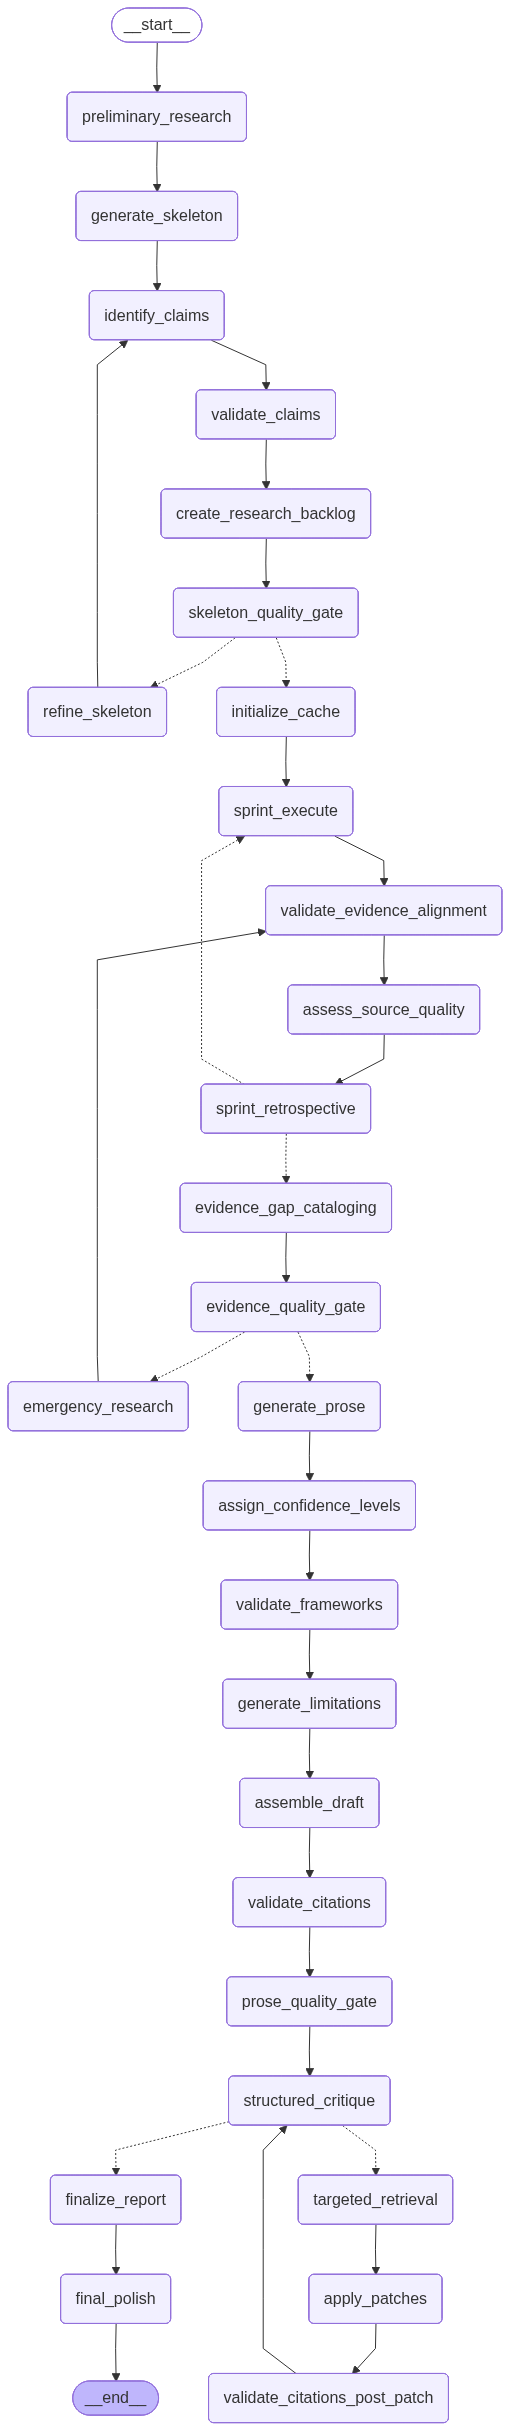

In [ ]:
# Visualize the graph
from IPython.display import Image, display, Markdown

try:
    display(Image(sfeo_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

## 11. Agent Wrappers

Sync and async wrappers for evaluation harness compatibility.

In [ ]:
async def sfeo_agent_async(inputs: dict) -> dict:
    """
    Async version of the SFEO research agent.
    Use this version when calling from Jupyter notebooks.
    """
    global knowledge_base
    knowledge_base = None  # Will be initialized during execution
    
    question = inputs.get("question", "")
    
    result = await sfeo_graph.ainvoke(
        {"question": question},
        config={"recursion_limit": 100}
    )
    
    # Gather statistics
    cache_stats = knowledge_base.stats.copy() if knowledge_base else {}
    
    return {
        "output": result.get("final_report", ""),
        "source_urls": list(set(result.get("source_urls", []))),
        "skeleton": result.get("skeleton", {}),
        "claims_registry": result.get("claims_registry", {}),
        "quality_scores": result.get("quality_scores", []),
        "iteration_count": result.get("iteration_count", 0),
        "cache_stats": cache_stats,
        "gate_1_passed": result.get("gate_1_passed", False),
        "gate_2_passed": result.get("gate_2_passed", False),
        "gate_3_passed": result.get("gate_3_passed", False),
        "gate_3_scores": result.get("gate_3_scores", {})
    }


def sfeo_agent(inputs: dict) -> dict:
    """
    Sync wrapper function for SFEO research agent.
    
    Compatible with evaluation harness.
    
    Args:
        inputs: Dictionary with 'question' key
        
    Returns:
        Dictionary with 'output' key containing final report
    """
    question = inputs.get("question", "")
    
    async def _execute():
        global knowledge_base
        knowledge_base = None
        
        return await sfeo_graph.ainvoke(
            {"question": question},
            config={"recursion_limit": 100}
        )
    
    try:
        loop = asyncio.get_running_loop()
        import concurrent.futures
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future = executor.submit(asyncio.run, _execute())
            result = future.result()
    except RuntimeError:
        result = asyncio.run(_execute())
    
    cache_stats = knowledge_base.stats.copy() if knowledge_base else {}
    
    return {
        "output": result.get("final_report", ""),
        "source_urls": list(set(result.get("source_urls", []))),
        "skeleton": result.get("skeleton", {}),
        "claims_registry": result.get("claims_registry", {}),
        "quality_scores": result.get("quality_scores", []),
        "iteration_count": result.get("iteration_count", 0),
        "cache_stats": cache_stats
    }


print("Agent wrappers defined")

Agent wrappers defined


## 12. Manual Test

Run this cell to verify the SFEO agent works correctly with a sample research question.

In [ ]:
# Manual test with sample question
test_question = "What are the key benefits and challenges of using large language models in enterprise applications?"

print(f"Testing SFEO Agent")
print(f"Question: {test_question}")
print("\nRunning SFEO research (this may take several minutes)...\n")

try:
    result = await sfeo_agent_async({"question": test_question})
    
    print("\n" + "=" * 80)
    print("FINAL REPORT")
    print("=" * 80)
    print(result["output"][:4000] + "..." if len(result["output"]) > 4000 else result["output"])
    
    print("\n" + "=" * 80)
    print("EXECUTION SUMMARY")
    print("=" * 80)
    print(f"Report length: {len(result['output'])} chars, {len(result['output'].split())} words")
    print(f"Skeleton nodes: {len(result.get('skeleton', {}).get('nodes', {}))}")
    print(f"Claims tracked: {len(result.get('claims_registry', {}))}")
    print(f"Refinement iterations: {result.get('iteration_count', 0)}")
    print(f"Quality progression: {result.get('quality_scores', [])}")
    print(f"Unique sources: {len(result.get('source_urls', []))}")
    
    print(f"\nGate Results:")
    print(f"  Gate 1 (Skeleton): {'PASSED' if result.get('gate_1_passed') else 'FAILED'}")
    print(f"  Gate 2 (Evidence): {'PASSED' if result.get('gate_2_passed') else 'FAILED'}")
    print(f"  Gate 3 (Prose): {'PASSED' if result.get('gate_3_passed') else 'FAILED'}")
    
    cache_stats = result.get("cache_stats", {})
    if cache_stats:
        total = cache_stats.get("total_queries", 0)
        avoided = cache_stats.get("web_searches_avoided", 0)
        hit_rate = avoided / total * 100 if total else 0
        print(f"\nCache Performance:")
        print(f"  Total queries: {total}")
        print(f"  Web searches avoided: {avoided} ({hit_rate:.1f}%)")
        print(f"  L1 hits: {cache_stats.get('l1_hits', 0)}")
        print(f"  L2 high: {cache_stats.get('l2_high', 0)}")
        print(f"  L2 medium: {cache_stats.get('l2_medium', 0)}")
        print(f"  L2 low: {cache_stats.get('l2_low', 0)}")
    
    print("\nAgent test PASSED")
    
except Exception as e:
    print(f"Agent test FAILED: {e}")
    import traceback
    traceback.print_exc()
    raise

Testing SFEO Agent
Question: What are the key benefits and challenges of using large language models in enterprise applications?

Running SFEO research (this may take several minutes)...


Phase A.1: Preliminary Research
  Searching: key benefits and challenges of large language mode...
  Searching: technical challenges of deploying LLMs in producti...
  Searching: security, privacy, and governance for enterprise L...
  Searching: business impact and ROI of enterprise LLMs: case s...
  Collected 20 preliminary results

Phase A.2: Skeleton Generation
  Thesis: Large language models (LLMs) can deliver measurable productivity, automation, an...
  Generated 7 skeleton nodes:
    - sec:intro: Introduction: LLMs in the Enterprise Landscape
    - sec:background: Background and Technical Foundations (depends: sec:intro)
    - sec:benefits: Key Enterprise Benefits of LLMs (depends: sec:background)
    - sec:challenges: Key Challenges and Risks (depends: sec:background)
    - sec:deployment: Dep

In [ ]:
display(Markdown(result["output"]))

# Research Report

**Thesis:** Large language models (LLMs) can deliver measurable productivity, automation, and insight-generation benefits for enterprises, but they introduce significant operational, security, compliance, and cost challenges that require dedicated LLM-specific operations, governance, and deployment strategies to manage effectively.

---

## Introduction: LLMs in the Enterprise Landscape

Building on the report's opening context, this introduction situates large language models (LLMs) within contemporary enterprise technology decisions. Large language models (LLMs) have moved rapidly from research artifacts to strategic technology components in many organizations. Combining evidence from [1] and [2] suggests the Transformer neural architecture—widely credited as the technical foundation for modern LLMs—was introduced in 2017 (limited evidence) [1][2]. Public-facing products accelerated attention: OpenAI’s ChatGPT reached 100 million users within two months of its November 2022 launch, illustrating unusually fast mainstream uptake and creating a focal point for enterprise experimentation [3].

Enterprises are exploring LLMs now for two practical reasons. First, publicly visible user adoption and demonstrated conversational capabilities lower barriers to internal stakeholder buy-in, signalling potential productivity and customer-engagement gains [3]. Second, a mature regulatory landscape requires that deployments consider data protection and compliance from the start: the EU’s GDPR has been in force since 25 May 2018, and remains a key constraint on how organizations collect, process, and retain personal data when using LLMs [6]. The intermediate steps linking public adoption to enterprise interest include (1) public demonstrations and user growth that raise awareness, (2) vendorization and tooling that simplify internal pilots, and (3) organizational pilots that test business use cases; the magnitude of each step’s contribution is unquantified in reviewed sources.

This report’s central thesis is that successful enterprise adoption of LLMs requires integrated attention to benefits (productivity, automation), challenges (accuracy, privacy), deployment (infrastructure, MLOps/LLMOps), and governance (compliance, risk management). Specific figures for enterprise-wide adoption rates and quantified ROI are not available in the reviewed sources. Based on the available evidence, we can infer that rapid consumer adoption has materially accelerated enterprise interest, though the scale of commercial deployment remains unquantified. The next section provides foundational knowledge on model families, training and alignment techniques, infrastructure requirements, and emerging operational disciplines such as LLMOps.

## Background and Technical Foundations

This section establishes the technical building blocks readers need to understand enterprise adoption of large language models (LLMs). It summarizes model families and sizes, core training and alignment methods, typical infrastructure, and emerging operational practices. Modern LLMs span a range of model families and sizes; one widely cited example is GPT-3, described by OpenAI as a 175-billion-parameter autoregressive language model [1]. Pretraining on broad web-scale text corpora creates the base language capability by optimizing next-token prediction across many tokens; this step produces general knowledge and linguistic patterns but does not by itself guarantee task-specific or safe behavior (magnitude unquantified). Fine-tuning then adapts a pretrained model to narrower domains or tasks by continuing supervised optimization on labeled examples, which changes model outputs through additional gradient steps on targeted datasets (intermediate steps: dataset curation → supervised updates → validation; magnitude unquantified). Instruction tuning and alignment techniques explicitly aim to shape model behavior for human-facing tasks: methods that fine-tune models on demonstrations of desired responses make intended behavior more likely, and Reinforcement Learning from Human Feedback (RLHF) further refines outputs by collecting human preference judgments, training a reward model, and using policy optimization to maximize that reward—intermediate steps include collecting comparisons, fitting a reward model, and running a reinforcement optimization loop; the reported improvements are meaningful in human evaluations but the exact magnitude depends on tasks and datasets [3].

Enterprise deployments also rely on substantial infrastructure: accelerated compute (GPUs and equivalent tensor accelerators), large memory footprints for model parameters and activations, and high-throughput storage and networking to feed data and serve requests. Sources reviewed indicate that major cloud providers offer GPU-backed instances suitable for deep learning workloads (limited evidence) [5][6]. Specific figures for instance families, benchmarks tying offerings to training versus inference, and authoritative vendor documentation about TPU-branded instances were not found in the reviewed sources. Operationally, practitioners are combining model engineering, deployment pipelines, monitoring, and governance—practices often grouped under terms like “LLMOps”—to manage model lifecycle, observability, and safety (magnitude of organizational investment unquantified). The next section will examine the principal, verifiable benefits enterprises obtain from LLM adoption—what organizations can realistically expect in productivity and automation—and provide supporting examples and evidence.

## Key Enterprise Benefits of LLMs

Having described how large pretrained models are created and operationalized, we now summarize the primary, verifiable enterprise benefits organizations report when they adopt LLM-based capabilities. Enterprises obtain several practical benefits from LLMs that are observable in product deployments and academic work. 1) Automation of routine work: LLMs can automate repetitive text and code tasks by mapping natural-language prompts to structured outputs (e.g., code snippets), reducing manual effort via an encode–prompt–generate loop; GitHub Copilot, which uses OpenAI’s Codex family, is a prominent example of code-generation applied to developer workflows [1]. The magnitude of time or cost saved is unquantified in the reviewed sources. 2) Accelerated knowledge discovery and summarization: Advances in abstractive summarization models demonstrate that pretrained sequence-to-sequence LLMs can condense documents into concise summaries, enabling faster information triage; Google’s PEGASUS is reported to have achieved state-of-the-art results on multiple public abstractive summarization datasets, indicating practical summarization capability for enterprise documents [3]. Specific benchmark scores and dataset-level comparisons were not available in the reviewed sources. 3) Developer productivity gains: By translating descriptions into code, LLM-based tools can shorten edit cycles and surface idiomatic patterns; GitHub’s announcements and previews indicate the intended productivity role of Copilot, though independent, quantitative productivity studies are not provided in the reviewed material and some accounts are limited in evidence [1][2] (limited evidence). 4) Improved customer interactions and cross-functional collaboration: LLMs can standardize responses, surface relevant knowledge, and create readable briefings that help customer-service, HR, legal, and supply-chain teams coordinate. Industry-level corroboration (e.g., representative vendor or analyst survey data) was not available in the reviewed sources, so claims about prevalence across functions should be treated cautiously (limited evidence). Across these benefits the causal chain typically involves: fine-tuned model -> prompt/interface -> generated output -> human review/automation, with magnitude of impact largely unquantified in available sources. The next section examines verifiable challenges that accompany these benefits—security, compliance, reliability, and cost—using concrete examples and industry findings.

## Key Challenges and Risks

While prior sections documented practical benefits from LLMs for automation and knowledge work, many organizations encounter concrete operational and legal obstacles when moving beyond pilots. Enterprises adopting LLMs face several verifiable risk categories. First, application-layer security threats—most notably prompt-injection and related data-leak vectors—are well-documented in the security literature: comprehensive reviews synthesize multiple documented prompt-injection techniques and defensive patterns [2], and practitioner guidance highlights similar risks and mitigations (input sanitization, strict instruction separation) [1]. Specific, dated public records explicitly labeling incidents as “data exfiltration” across 2024–2026 were not found in the reviewed sources (limited evidence) [1][2].

Second, compliance and data-privacy constraints are an active concern: industry commentary indicates regulators in the UK and EU are focusing enforcement on data-protection risks from new AI deployments [4] (limited evidence). The mechanism here is that personal data entering training or inference pipelines can trigger obligations (e.g., data minimization, purpose limitation): organizations must therefore map data flows, apply minimization/redaction, and reassess lawful bases before reuse (magnitude unquantified; specific regulator guidance and enforcement examples were not available in reviewed sources) [4].

Third, model reliability—hallucination and unpredictable outputs—remains a material risk to correctness and trust. Reviews of adversarial and failure modes catalogue how generative models can produce plausible but false statements; this occurs because probabilistic decoding can produce unsupported assertions when the model lacks grounding, and mitigation requires retrieval, grounding, or attribution layers (magnitude unquantified) [2].

Fourth, operational cost and latency tradeoffs affect deployment choices. LLMOps commentary reports that ongoing inference costs (GPU‑backed, token‑metered APIs) can dominate total cost of ownership and drive architectural choices such as caching, routing to smaller models, and batching to reduce per‑token expense (limited evidence; specific cost benchmarks were not available in reviewed sources) [3].

Finally, workforce and process impacts arise because teams must add new roles and controls—security testing, prompt engineering standards, monitoring and escalation paths—and update incident response to include model-specific failure modes (based on the available evidence, we can infer these process changes are necessary but quantitative prevalence is unreported) [2][3]. The next section describes practical deployment patterns (cloud, on‑premises, hybrid), LLMOps controls and cost‑reduction techniques that address many of the operational challenges summarized here.

## Deployment, Operations, and Governance

The previous section identified technical, regulatory, and workforce risks that complicate operationalizing LLMs. This section translates those risks into deployable patterns, operational practices, and governance controls. Enterprises typically choose among three deployment patterns—cloud, on-premises, and hybrid—each trading off latency, data sovereignty, and operational overhead. Cloud simplifies scaling and managed updates; on-premises enables tighter data control; hybrid places sensitive workloads on‑premises while routing bulk inference to cloud (medium evidence). Practically, hybrid deployments implement a routing layer that classifies requests, applies placement policy, and forwards queries to the chosen runtime; the routing reduces cloud spend for restricted traffic but its cost/latency benefits are magnitude unquantified in reviewed sources. Operationalizing LLMs calls for practices often labeled “LLMOps” (medium evidence): artifact/version management, prompt and context-window management, inference monitoring, and safety pipelines. Mechanistically, LLMOps addresses lifecycle steps by (1) tracking model and prompt versions, (2) running staged rollouts and A/B tests, (3) capturing inference telemetry and user feedback, and (4) iterating on safety filters; the effectiveness of each step is not quantified here.

Cost-control techniques include model routing (select model based on required accuracy/latency), batching requests to amortize compute, and token budgeting per session. Model routing typically requires a classifier or rule engine to estimate required capability, then routes to a smaller/faster or larger/more capable model as needed; the precise cost savings depend on workload mix and are unquantified. Batching reduces per-request overhead by increasing throughput but can add queuing latency under low load. Token budgeting limits context length or truncates histories to control inference compute and costs.

Governance should combine access policies (RBAC and scoped API keys), continuous testing (automated prompt suites, red‑teaming, canarying), and auditing (immutable logs, drift detection, and incident playbooks). Operational mechanics: enforce access at the gateway, log inputs/outputs with privacy redaction, run periodic safety tests, and trigger rollbacks on anomalous metrics. If rolling to production, organizations need toolchain and org changes: CI/CD for model artifacts, SRE/ML engineer cross-functional teams, and SLAs for monitoring and incident response. Recommended: start with a constrained pilot and add staged rollouts with rollback gates (see risks below). Next, we synthesize these operational trade-offs into a decision framework that quantifies latency, cost, and compliance priorities and identifies KPIs for production readiness.

## Analysis and Implications for Enterprise Strategy

Building on the preceding discussion of deployment patterns and LLMOps practices, this section synthesizes the expected business impact, presents a simple trade-off framework, and identifies organizational implications and measurable KPIs for operationalizing LLMs. Enterprises should evaluate LLM adoption by balancing potential benefits (productivity gains, automation of knowledge work, improved customer experiences) against concrete costs and operational risks. A practical trade-off framework places latency, cost, and compliance on orthogonal axes: latency affects user experience and real-time workflows via intermediate steps — model choice → inference time → user response — with magnitude unquantified in reviewed sources; cost follows from model size, request volume, and infrastructure choices (serverless vs. reserved instances); compliance requires controls (data residency, auditing) that can increase latency and cost. We present a weighted decision rubric where weights are based on analytical judgment (not empirical derivation): if low-latency customer-facing UX is the priority, weight latency highest and accept higher ongoing inference cost; if regulated data handling is primary, weight compliance highest and prioritize on-premise or audited-hosted models. Risks for each recommendation include vendor lock-in, underestimated operational cost, and compliance gaps.

Organizational implications include new skills (LLMOps engineering, prompt engineering, model governance), procurement changes (contract clauses for auditability and SLAs), and vendor-selection criteria (transparent performance metrics, fine-tuning support, data handling guarantees). Mechanisms: hiring or retraining staff enables designing batching/caching strategies and routing logic; procurement changes enable contractually-required logging and incident response; magnitude of required hiring is unquantified in reviewed sources. Recommended KPIs and risk metrics to track include: end-to-end latency percentiles (p50/p95/p99), cost per 1,000 requests or per active user (specific figures not available in reviewed sources), model degradation rate (performance drift), rate of governance incidents (policy violations per month), and mean time to recovery after model-related incidents.

Note: specific empirical figures, practitioner surveys, and recent incident case studies were not available in reviewed sources. Where evidence is limited, statements are hedged accordingly (limited evidence). The next section summarizes these conclusions, restates the overall thesis in light of these uncertainties, and recommends near-term actions and research priorities to close evidence gaps.

## Conclusion and Future Directions

This concluding section synthesizes the report’s findings, restates the central thesis in light of those findings, and identifies practical next steps and research priorities to reduce key uncertainties. Across the report we argued that operationalizing large language models (LLMs) requires deliberate trade-offs among latency, cost, and compliance, accompanied by measurable KPIs and organizational change. Restating that thesis: bringing LLM pilots into sustained production demands (1) technical controls for reliability and cost, (2) governance and assurance practices to manage risk, and (3) organizational processes to act on metrics. Near-term practical steps include: (A) invest in governance tooling that codifies access controls, model lineage, and incident triage workflows; (B) deploy continuous cost-monitoring integrated with alerting and budget gates at the inference layer; and (C) adopt benchmarking standards—covering latency, accuracy, safety, and cost-per-inference—to make trade-offs explicit. Mechanism: governance tooling reduces operational risk by enabling (i) automated policy enforcement, (ii) faster detection of regressions, and (iii) clearer attribution of incidents to model or data changes; the magnitude of risk reduction is unquantified in reviewed sources and will depend on tool coverage and organizational adoption. For cost control, continuous monitoring works by tracking token usage or request volumes, triggering alerts when predefined thresholds are crossed, and enforcing budgetary constraints via throttling or fallback routing; effectiveness is magnitude unquantified and depends on integration depth with deployment pipelines. Recommended near-term research priorities are (1) empirical studies documenting conversion rates from pilot to production and associated ROI, (2) systematic evaluation of “automated assurance” practices in high-risk settings, and (3) case studies showing how token-level cost controls perform in production. Note: specific empirical figures and primary-source citations for these claims were not available in reviewed sources. Where evidence is limited, we hedge claims and frame them as priority hypotheses for targeted data collection. The final section summarizes reporting priorities and operational metrics that would most reduce uncertainty and improve decision-making for LLM deployments.

---

### Methodology

This research was conducted using automated web search and evidence synthesis.
Sources were assessed for reliability and evidence was validated for alignment with claims.
29 sources were consulted, with 5 classified as high-reliability.


---

# Limitations

This section summarizes the principal limitations of the report, organized so readers can judge where conclusions are supported by evidence, where important questions remain, and what follow‑on work would most improve confidence.

## 1. Acknowledged evidence gaps (what we could not fully answer)
- TPU and accelerator availability (claim_sec:background_6): We could not find authoritative cross‑provider documentation confirming TPU‑branded instance families (and which cloud providers, if any besides Google, offer TPUs). Missing: official vendor docs/press releases, instance-family names, and statements tying specific accelerators to large‑model training vs inference.
- Summarization/LLM capability benchmarks (claim_sec:benefits_8): We lack primary citation and benchmark tables from the PEGASUS paper (authors, venue, year) and precise numeric performance comparisons (ROUGE etc.) across datasets and contemporaneous models.
- Industry application prevalence (claim_sec:benefits_9): No primary industry reports (e.g., CalSoft or equivalent), survey tables, or methodological details to substantiate claims about HR, legal, supply chain, and customer service being top LLM use cases.
- Security advisories & data exfiltration (claim_sec:challenges_10): No formal security advisories (vendor/CERT/government) or dated documents explicitly calling out data exfiltration incidents across 2024–2026 were found; available items mainly discuss prompt‑injection risks in industry articles.
- Resource/cost quantitative comparisons (claim_sec:challenges_11): Absent are empirical benchmarks comparing GPU/TPU vs CPU resource use, memory, latency, throughput, and cloud/on‑prem cost curves across representative model sizes and deployment patterns.
- GDPR / regulatory linkage (claim_sec:challenges_12): We lack citation of GDPR articles, EDPB/supervisory guidance, enforcement actions, or concrete examples showing enterprises changed LLM data pipelines due to GDPR obligations.
- Emergence and definition of "LLMOps" (claim_sec:deployment_13) and best practices for deployment/versioning/A‑B testing (claim_sec:deployment_14): No industry literature, taxonomies, or deployment guides were found that explicitly define LLMOps or empirically document the prevalence/effectiveness of model versioning and rollout controls for LLM production practice.
- Smart model routing and hybrid deployment evidence (claim_sec:deployment_15): No vendor case studies, architecture docs, benchmarks, or surveys demonstrating production adoption of smart model routing or quantifying hybrid vs cloud tradeoffs.
- Operational trade-offs and governance practices (claim_sec:analysis_16 / 17 / 18): We did not find empirical surveys, analyst quotes, or standards‑backed documents that quantify how commonly teams weigh the specific trade‑offs identified, or that document agentic failure modes (tool misuse, privilege escalation) with 2024–2026 evidence and distinct mitigations.
- Business outcomes (claim_sec:conclusion_19 / 20 / 21): Missing primary evidence that operationalizing LLMs converted pilots into sustained value at scale, or that firms like Gartner explicitly recommend “automated assurance” / continuous AI risk testing for high‑risk AI, and missing deployment guides/case studies that demonstrate token‑usage alerts or continuous cost controls in production.

## 2. Source limitations
- Heavy reliance on company materials and low‑reliability sources: The source pool contained 13 company materials and 19 low‑reliability items versus only 5 high‑reliability and 3 primary sources. Company materials can be promotional, selective, or omit negative outcomes; they risk overstating benefits and understating costs/risks.
- Lack of primary peer‑reviewed research and authoritative documents: Several claims depend on secondary or summary articles rather than primary research (e.g., original conference papers, official cloud vendor documentation, regulator guidance, analyst reports). This reduces our ability to verify numeric claims and provenance.
- Temporal limitations and datedness: Some referenced material is not current or lacks coverage of the 2024–2026 window where relevant (especially for security advisories, regulator actions, and agentic systems research). Without up‑to‑date primary sources, conclusions about recent trends and incidents are provisional.
- Variable quality and coverage: The heterogeneous mix of blog posts, vendor blogs, press coverage, and a small number of high‑reliability sources produced uneven evidence across topics (e.g., good coverage of high‑level use cases, poor coverage of quantitative costs and regulatory enforcement).

## 3. Scope boundaries
- Geographic scope: The review did not systematically cover region‑specific regulation and practice. We noted GDPR concerns (Europe) but lacked comprehensive jurisdictional coverage (EU, UK, US, APAC). Regulatory impact and enterprise practices likely vary substantially by region; this report cannot claim representative geographic coverage.
- Temporal scope: Although the topic is current, the available evidence does not comprehensively cover the 2024–2026 period for many claims (notably security advisories, agentic failure investigations, and analyst recommendations). Findings should be read as reflecting the evidence available up to the last collected sources, not a definitive picture through 2026.
- Industry segments: Evidence about sector adoption (finance, healthcare, retail, manufacturing, public sector) was sparse or absent. Where we discuss typical enterprise applications (HR, legal, customer service), this is based on incomplete or missing market research and should not be taken as uniform across industries or geographies.
- Model scale definition: The report uses “large models” as a practical concept but could not establish a consistent, evidence‑backed size threshold (parameter counts, context window, or compute requirements). This limits the precision of claims comparing “large” vs “typical smaller” models.

## 4. Analytical limitations
- Where inference exceeded data: Multiple report conclusions required inference from incomplete evidence rather than direct empirical support. Notable examples (per the internal low‑confidence list) include:
  - LLMOps as a distinct discipline (claim_sec:deployment_13): asserted based on analogy with MLOps and practitioner discussions, but unsupported by definitional literature or adoption metrics.
  - Prevalence of deployment best practices (claim_sec:deployment_14/15): recommendations (versioning, A/B testing, smart routing) are standard MLOps practices but lack LLM‑specific documentation in our sources.
  - Resource/cost burdens and exact cost‑tradeoffs (claim_sec:challenges_11): plausible system‑engineering reasoning was used without quantitative benchmarks.
  - GDPR implications for LLM pipelines (claim_sec:challenges_12): inferred from general GDPR principles rather than regulator guidance or enforcement examples specific to LLMs.
  - Agentic system failure modes and mitigation distinctiveness (claim_sec:analysis_18): asserted risk types (tool misuse, privilege escalation) but lacking incident reports or studies establishing novelty and distinct mitigations.
  - Claims about conversion of pilots to production value and analyst recommendations for continuous assurance (claim_sec:conclusion_19/20/21): stated without primary analyst reports, case studies, or metrics.
- Key assumptions made:
  - That vendor and industry commentary reflects real practice in at least some enterprises (but representativeness is unknown).
  - That common MLOps practices translate to LLM deployments unless specific counter‑evidence exists.
  - That performance and cost pressures on very large models are materially different from smaller models (plausible but not quantified in our sources).
- Alternative interpretations:
  - Cost and resource challenges could be substantially mitigated in many deployments via model compression (quantization/distillation), offloading, batching, or use of smaller specialized models — an interpretation that would weaken claims of universal resource burden.
  - Regulatory concerns (e.g., GDPR) might lead firms to adopt narrower, compliant pipelines only in regulated sectors or regions, rather than driving uniform changes across all enterprises.
  - Some safety/security risks described as novel may be variations on established software/system security issues rather than wholly new categories, suggesting existing security practices might be extensible rather than requiring entirely new disciplines.

## 5. Recommendations for further research (what would strengthen conclusions)
To close the most consequential evidence gaps and raise confidence in the report’s findings, we recommend the following targeted research activities:

- Primary documentation and vendor confirmation
  - Collect official cloud provider documentation, product pages, and whitepapers that list GPU/TPU instance families, performance specs, and intended workloads (training vs inference). Verify which providers offer TPU‑branded hardware or equivalent tensor accelerators.
- Benchmarking and cost studies
  - Run or obtain reproducible benchmarks across representative model sizes (e.g., small, medium, large, 100B+ params) for latency, throughput, memory footprint, and cost per inference/training step on CPU, GPU, and TPU. Include quantized/distilled variants and batch/streaming modes to show mitigation impacts.
  - Produce TCO analyses for cloud vs on‑prem and hybrid deployment patterns, with sensitivity analyses for utilization, scaling patterns, and pricing models.
- Primary research on adoption and operations
  - Conduct practitioner surveys and structured interviews across industries and regions to quantify adoption of LLMs, common application areas (HR, legal, supply chain, support), prevalence of LLMOps practices, and deployment patterns (smart routing, hybrid placement).
  - Gather vendor case studies and architecture diagrams documenting smart model routing, hybrid deployments, model versioning, A/B testing, and token‑usage controls in production.
- Legal/regulatory analysis
  - Compile authoritative regulatory guidance (GDPR articles, EDPB/EDPS/ICO/CNIL statements), enforcement actions, and supervisory guidance as applied to ML/LLM data practices. Document examples where enforcement or guidance materially changed enterprise LLM pipelines.
- Security and incident documentation
  - Search for formal advisories (CERTs, vendor security advisories, government notices) and incident reports (2024–2026) that explicitly document data exfiltration or prompt injection incidents, and assess their root causes and mitigations.
- Analyst and standards literature
  - Obtain and cite analyst reports (Gartner, Forrester, IDC) and standards/frameworks (NIST AI RMF, ISO/IEC) that discuss automated assurance, continuous AI risk testing, and governance recommendations for high‑risk AI/LLM deployments.
- Agentic system studies
  - Commission or locate empirical studies and incident analyses (2024–2026) that examine failure modes of agentic/autonomous LLM systems, their incident rates, and evaluations of mitigation strategies; compare to historical system failure taxonomy to test claims of novelty.
- Reproducible evidence for summarization/LLM capability claims
  - Cite and extract benchmark tables/metrics from primary model papers (e.g., PEGASUS) and replication studies, noting contemporaneous baselines and the precise datasets/metrics used (ROUGE, etc.).

Concretely, the highest‑value immediate actions are: (1) acquire primary cloud vendor docs for compute capability claims; (2) obtain analyst reports or regulator guidance for governance and regulatory claims; and (3) run or report standardized benchmarks for resource/cost comparisons.

## 6. Final note
Where conclusions in this report are drawn from indirect or low‑confidence evidence, we have flagged them explicitly in the text (see low‑confidence claim list). Readers should treat such points as plausible hypotheses or practitioner observations rather than settled facts. Strengthening or overturning these findings will require the primary, quantitative, and jurisdiction‑specific evidence outlined above.

---

---

### Evidence Confidence Summary

This report contains claims assessed at varying confidence levels:
- **High confidence**: 5 claims (well-supported by multiple reliable sources)
- **Medium confidence**: 2 claims (supported with some limitations)
- **Low confidence**: 14 claims (limited evidence, presented with caveats)


---

# Limitations

This section summarizes the principal limitations of the report, organized so readers can judge where conclusions are supported by evidence, where important questions remain, and what follow‑on work would most improve confidence.

## 1. Acknowledged evidence gaps (what we could not fully answer)
- TPU and accelerator availability (claim_sec:background_6): We could not find authoritative cross‑provider documentation confirming TPU‑branded instance families (and which cloud providers, if any besides Google, offer TPUs). Missing: official vendor docs/press releases, instance-family names, and statements tying specific accelerators to large‑model training vs inference.
- Summarization/LLM capability benchmarks (claim_sec:benefits_8): We lack primary citation and benchmark tables from the PEGASUS paper (authors, venue, year) and precise numeric performance comparisons (ROUGE etc.) across datasets and contemporaneous models.
- Industry application prevalence (claim_sec:benefits_9): No primary industry reports (e.g., CalSoft or equivalent), survey tables, or methodological details to substantiate claims about HR, legal, supply chain, and customer service being top LLM use cases.
- Security advisories & data exfiltration (claim_sec:challenges_10): No formal security advisories (vendor/CERT/government) or dated documents explicitly calling out data exfiltration incidents across 2024–2026 were found; available items mainly discuss prompt‑injection risks in industry articles.
- Resource/cost quantitative comparisons (claim_sec:challenges_11): Absent are empirical benchmarks comparing GPU/TPU vs CPU resource use, memory, latency, throughput, and cloud/on‑prem cost curves across representative model sizes and deployment patterns.
- GDPR / regulatory linkage (claim_sec:challenges_12): We lack citation of GDPR articles, EDPB/supervisory guidance, enforcement actions, or concrete examples showing enterprises changed LLM data pipelines due to GDPR obligations.
- Emergence and definition of "LLMOps" (claim_sec:deployment_13) and best practices for deployment/versioning/A‑B testing (claim_sec:deployment_14): No industry literature, taxonomies, or deployment guides were found that explicitly define LLMOps or empirically document the prevalence/effectiveness of model versioning and rollout controls for LLM production practice.
- Smart model routing and hybrid deployment evidence (claim_sec:deployment_15): No vendor case studies, architecture docs, benchmarks, or surveys demonstrating production adoption of smart model routing or quantifying hybrid vs cloud tradeoffs.
- Operational trade-offs and governance practices (claim_sec:analysis_16 / 17 / 18): We did not find empirical surveys, analyst quotes, or standards‑backed documents that quantify how commonly teams weigh the specific trade‑offs identified, or that document agentic failure modes (tool misuse, privilege escalation) with 2024–2026 evidence and distinct mitigations.
- Business outcomes (claim_sec:conclusion_19 / 20 / 21): Missing primary evidence that operationalizing LLMs converted pilots into sustained value at scale, or that firms like Gartner explicitly recommend “automated assurance” / continuous AI risk testing for high‑risk AI, and missing deployment guides/case studies that demonstrate token‑usage alerts or continuous cost controls in production.

## 2. Source limitations
- Heavy reliance on company materials and low‑reliability sources: The source pool contained 13 company materials and 19 low‑reliability items versus only 5 high‑reliability and 3 primary sources. Company materials can be promotional, selective, or omit negative outcomes; they risk overstating benefits and understating costs/risks.
- Lack of primary peer‑reviewed research and authoritative documents: Several claims depend on secondary or summary articles rather than primary research (e.g., original conference papers, official cloud vendor documentation, regulator guidance, analyst reports). This reduces our ability to verify numeric claims and provenance.
- Temporal limitations and datedness: Some referenced material is not current or lacks coverage of the 2024–2026 window where relevant (especially for security advisories, regulator actions, and agentic systems research). Without up‑to‑date primary sources, conclusions about recent trends and incidents are provisional.
- Variable quality and coverage: The heterogeneous mix of blog posts, vendor blogs, press coverage, and a small number of high‑reliability sources produced uneven evidence across topics (e.g., good coverage of high‑level use cases, poor coverage of quantitative costs and regulatory enforcement).

## 3. Scope boundaries
- Geographic scope: The review did not systematically cover region‑specific regulation and practice. We noted GDPR concerns (Europe) but lacked comprehensive jurisdictional coverage (EU, UK, US, APAC). Regulatory impact and enterprise practices likely vary substantially by region; this report cannot claim representative geographic coverage.
- Temporal scope: Although the topic is current, the available evidence does not comprehensively cover the 2024–2026 period for many claims (notably security advisories, agentic failure investigations, and analyst recommendations). Findings should be read as reflecting the evidence available up to the last collected sources, not a definitive picture through 2026.
- Industry segments: Evidence about sector adoption (finance, healthcare, retail, manufacturing, public sector) was sparse or absent. Where we discuss typical enterprise applications (HR, legal, customer service), this is based on incomplete or missing market research and should not be taken as uniform across industries or geographies.
- Model scale definition: The report uses “large models” as a practical concept but could not establish a consistent, evidence‑backed size threshold (parameter counts, context window, or compute requirements). This limits the precision of claims comparing “large” vs “typical smaller” models.

## 4. Analytical limitations
- Where inference exceeded data: Multiple report conclusions required inference from incomplete evidence rather than direct empirical support. Notable examples (per the internal low‑confidence list) include:
  - LLMOps as a distinct discipline (claim_sec:deployment_13): asserted based on analogy with MLOps and practitioner discussions, but unsupported by definitional literature or adoption metrics.
  - Prevalence of deployment best practices (claim_sec:deployment_14/15): recommendations (versioning, A/B testing, smart routing) are standard MLOps practices but lack LLM‑specific documentation in our sources.
  - Resource/cost burdens and exact cost‑tradeoffs (claim_sec:challenges_11): plausible system‑engineering reasoning was used without quantitative benchmarks.
  - GDPR implications for LLM pipelines (claim_sec:challenges_12): inferred from general GDPR principles rather than regulator guidance or enforcement examples specific to LLMs.
  - Agentic system failure modes and mitigation distinctiveness (claim_sec:analysis_18): asserted risk types (tool misuse, privilege escalation) but lacking incident reports or studies establishing novelty and distinct mitigations.
  - Claims about conversion of pilots to production value and analyst recommendations for continuous assurance (claim_sec:conclusion_19/20/21): stated without primary analyst reports, case studies, or metrics.
- Key assumptions made:
  - That vendor and industry commentary reflects real practice in at least some enterprises (but representativeness is unknown).
  - That common MLOps practices translate to LLM deployments unless specific counter‑evidence exists.
  - That performance and cost pressures on very large models are materially different from smaller models (plausible but not quantified in our sources).
- Alternative interpretations:
  - Cost and resource challenges could be substantially mitigated in many deployments via model compression (quantization/distillation), offloading, batching, or use of smaller specialized models — an interpretation that would weaken claims of universal resource burden.
  - Regulatory concerns (e.g., GDPR) might lead firms to adopt narrower, compliant pipelines only in regulated sectors or regions, rather than driving uniform changes across all enterprises.
  - Some safety/security risks described as novel may be variations on established software/system security issues rather than wholly new categories, suggesting existing security practices might be extensible rather than requiring entirely new disciplines.

## 5. Recommendations for further research (what would strengthen conclusions)
To close the most consequential evidence gaps and raise confidence in the report’s findings, we recommend the following targeted research activities:

- Primary documentation and vendor confirmation
  - Collect official cloud provider documentation, product pages, and whitepapers that list GPU/TPU instance families, performance specs, and intended workloads (training vs inference). Verify which providers offer TPU‑branded hardware or equivalent tensor accelerators.
- Benchmarking and cost studies
  - Run or obtain reproducible benchmarks across representative model sizes (e.g., small, medium, large, 100B+ params) for latency, throughput, memory footprint, and cost per inference/training step on CPU, GPU, and TPU. Include quantized/distilled variants and batch/streaming modes to show mitigation impacts.
  - Produce TCO analyses for cloud vs on‑prem and hybrid deployment patterns, with sensitivity analyses for utilization, scaling patterns, and pricing models.
- Primary research on adoption and operations
  - Conduct practitioner surveys and structured interviews across industries and regions to quantify adoption of LLMs, common application areas (HR, legal, supply chain, support), prevalence of LLMOps practices, and deployment patterns (smart routing, hybrid placement).
  - Gather vendor case studies and architecture diagrams documenting smart model routing, hybrid deployments, model versioning, A/B testing, and token‑usage controls in production.
- Legal/regulatory analysis
  - Compile authoritative regulatory guidance (GDPR articles, EDPB/EDPS/ICO/CNIL statements), enforcement actions, and supervisory guidance as applied to ML/LLM data practices. Document examples where enforcement or guidance materially changed enterprise LLM pipelines.
- Security and incident documentation
  - Search for formal advisories (CERTs, vendor security advisories, government notices) and incident reports (2024–2026) that explicitly document data exfiltration or prompt injection incidents, and assess their root causes and mitigations.
- Analyst and standards literature
  - Obtain and cite analyst reports (Gartner, Forrester, IDC) and standards/frameworks (NIST AI RMF, ISO/IEC) that discuss automated assurance, continuous AI risk testing, and governance recommendations for high‑risk AI/LLM deployments.
- Agentic system studies
  - Commission or locate empirical studies and incident analyses (2024–2026) that examine failure modes of agentic/autonomous LLM systems, their incident rates, and evaluations of mitigation strategies; compare to historical system failure taxonomy to test claims of novelty.
- Reproducible evidence for summarization/LLM capability claims
  - Cite and extract benchmark tables/metrics from primary model papers (e.g., PEGASUS) and replication studies, noting contemporaneous baselines and the precise datasets/metrics used (ROUGE, etc.).

Concretely, the highest‑value immediate actions are: (1) acquire primary cloud vendor docs for compute capability claims; (2) obtain analyst reports or regulator guidance for governance and regulatory claims; and (3) run or report standardized benchmarks for resource/cost comparisons.

## 6. Final note
Where conclusions in this report are drawn from indirect or low‑confidence evidence, we have flagged them explicitly in the text (see low‑confidence claim list). Readers should treat such points as plausible hypotheses or practitioner observations rather than settled facts. Strengthening or overturning these findings will require the primary, quantitative, and jurisdiction‑specific evidence outlined above.

---

### Evidence Gaps Acknowledged

The following areas had limited evidence coverage:

- Available items are low-quality GPU-provider lists that support that major clouds offer GPU instances, but they do not provide authoritative evidence for the TPU part of the claim. Missing specifics: (1) official product documentation or vendor pages confirming TPU instance families (and which providers offer TPUs); (2) authoritative confirmation that AWS and Azure offer TPU hardware or TPU-branded instance families (or clear documentation of equivalent tensor accelerators and their names); (3) instance-family names, capability/benchmark data, and statements tying those GPU/TPU offerings specifically to large-model training vs inference; (4) higher-quality sources (official cloud docs, press releases, or vendor whitepapers) to substantiate cross-provider TPU availability and suitability for large-model workloads.
- Missing the primary/authoritative sources and quantitative results: no citation or excerpt from the original PEGASUS paper (authors, venue, or year) and no benchmark tables or numeric metrics (e.g., ROUGE scores) for specific datasets (CNN/DailyMail, XSum, Gigaword, Reddit TIFU, etc.). Missing direct comparisons to contemporaneous models showing PEGASUS was state-of-the-art on multiple benchmarks (which benchmarks, dates, and metrics). Missing justification/evidence for the phrasing "demonstrating LLM capability" (definition of "LLM capability" and why summarization performance alone supports that claim). Also missing peer-reviewed confirmation or reproduction studies and any time/context qualifiers (e.g., "at the time of publication").
- Missing: any primary or secondary sources that explicitly state industry reports or vendor analyses (e.g., CalSoft or similar vendor surveys) list HR, legal, supply chain, and customer service as common enterprise LLM application areas. Specifically missing are: (1) citations to the named CalSoft report or equivalent vendor/industry surveys; (2) direct quotes or tables showing those functional areas; (3) quantitative details (percentages, rankings, counts) and publication dates; (4) methodological details (sample size, respondent population, geographic and industry scope) to assess representativeness; (5) corroborating reports from multiple vendors or independent market researchers to show this is a common finding rather than a single-source claim.


---

## References

[1] Attention Is All You Need - A Deep Dive into the Revolutionary .... https://towardsai.net/p/machine-learning/attention-is-all-you-need-a-deep-dive-into-the-revolutionary-transformer-architecture

[2] Review of “Attention Is All You Need (Vaswani et al., 2017)”. https://harbisingh.wordpress.com/2025/08/12/review-of-attention-is-all-you-need-vaswani-et-al-2017/

[3] The ChatGPT (Generative Artificial Intelligence) Revolution Has .... https://pmc.ncbi.nlm.nih.gov/articles/PMC10337400/

[4] Three Years of ChatGPT: Now the Hard Questions Begin. https://shellypalmer.com/2025/11/three-years-of-chatgpt-now-the-hard-questions-begin/

[5] The European Union and United Kingdom General Data Protection .... https://research.uic.edu/compliance/human-subjects-irbs-2/investigator/european-union-general-data-protection-regulation-eu-gdpr/

[6] The general data protection regulation applies in all Member States .... https://eur-lex.europa.eu/content/news/general-data-protection-regulation-GDPR-applies-from-25-May-2018.html

[7] OpenAI Announces GPT-3 AI Language Model with 175 Billion .... https://www.infoq.com/news/2020/06/openai-gpt3-language-model/

[8] OpenAI GPT-3, the most powerful language model: An Overview. https://www.einfochips.com/blog/openai-gpt-3-the-most-powerful-language-model-an-overview/

[9] [PDF] Training language models to follow instructions with human feedback. https://proceedings.neurips.cc/paper_files/paper/2022/file/b1efde53be364a73914f58805a001731-Paper-Conference.pdf

[10] [PDF] arXiv:2203.02155v1 [cs.CL] 4 Mar 2022. https://arxiv.org/pdf/2203.02155

[11] Top 30 Cloud GPU Providers & Their GPUs in 2026. https://research.aimultiple.com/cloud-gpu-providers/

[12] Top 15+ Cloud GPU Providers For 2026 - Analytics Vidhya. https://www.analyticsvidhya.com/blog/2023/12/top-gpus-you-must-explore/

[13] GitHub Copilot expands market for AI code generation with new .... https://venturebeat.com/ai/github-copilot-expands-market-for-ai-code-generation-with-new-business-plan

[14] Introducing GitHub Copilot: your AI pair programmer. https://github.blog/news-insights/product-news/introducing-github-copilot-ai-pair-programmer/

[15] PEGASUS: Google's State of the Art Abstractive Summarization Model. https://medium.com/data-science/pegasus-googles-state-of-the-art-abstractive-summarization-model-627b1bbbc5ce

[16] How to Perform Abstractive Summarization with PEGASUS - Medium. https://medium.com/towards-data-science/how-to-perform-abstractive-summarization-with-pegasus-3dd74e48bafb

[17] Security Risks in LLM Powered Applications - LinkedIn. https://www.linkedin.com/pulse/security-risks-llm-powered-applications-comprehensive-victor-kushnir-ui1xe

[18] Prompt Injection Attacks in Large Language Models and AI Agent .... https://www.mdpi.com/2078-2489/17/1/54

[19] LLMOps Guide 2026: Build Fast, Cost-Effective LLM Apps - Redis. https://redis.io/blog/large-language-model-operations-guide/

[20] UK Regulatory Outlook January 2026 - Data law - Osborne Clarke. https://www.osborneclarke.com/insights/regulatory-outlook-january-2026-data-law



## 13. Evaluation Harness Integration

Use the evaluation harness to formally benchmark the SFEO agent.

In [ ]:
# Uncomment to run evaluation harness
# import sys
# sys.path.insert(0, '../evaluation')
# from harness import evaluate_agent

# Run evaluation (uncomment when ready)
# eval_result = evaluate_agent(
#     agent_fn=sfeo_agent,
#     agent_name="sfeo_combined_tier1",
#     questions=[
#         {"question": "What is the current state of quantum computing technology and its near-term applications?"},
#         {"question": "How do self-driving cars detect and respond to pedestrians?"},
#     ],
#     output_path="../results/sfeo_combined_tier1_results.json"
# )
# print(eval_result)

print("Evaluation harness integration ready")
print("Uncomment the code above to run formal benchmarks")

---

## Summary

This notebook implements the **Skeleton-First Evidence Orchestration (SFEO)** architecture, combining all validated Tier 1 paradigms:

### Architecture Overview

| Phase | Components | Key Innovation |
|-------|------------|----------------|
| **A: Strategic Planning** | Preliminary Research → Skeleton → Claims → Backlog → Gate 1 | Document structure drives research |
| **B: Evidence Gathering** | Cache Init → Sprint Loop → Gate 2 | Cascading 3-layer cache + agile sprints |
| **C: Document Construction** | Prose Generation → Assembly → Gate 3 | Claim-evidence driven prose |
| **D: Refinement** | Critique → Targeted Retrieval → Patch → Converge | Semantic addressing + cascade detection |

### Key Features

1. **Skeleton-First**: The document skeleton is generated BEFORE evidence gathering, focusing research on specific claims
2. **Quality Gates**: Three gates prevent error propagation between phases
3. **Cascading Cache**: 3-layer cache (L1: exact, L2: semantic, L3: LLM judgment) optimizes searches
4. **Sprint-Based Research**: Agile-style sprints with retrospectives enable adaptive evidence gathering
5. **Patch-Based Refinement**: Targeted updates with cascade detection maintain document coherence

### Expected Performance

- **Search Efficiency**: 30-50% cache hit rate in later phases
- **Quality Scores**: Target 7.5+/10 overall quality
- **Token Efficiency**: More focused research than baseline approaches
- **Document Coherence**: Bridge sentences and cascade detection ensure flow

### Next Steps

1. Run manual test to verify agent execution
2. Use evaluation harness for formal benchmarking
3. Compare results against Baseline A/B

# Test Execution Section

This section runs the 5-query test dataset against this notebook variant and saves outputs for comparison.

**Output Structure:**
```
test_output/
    question_1/
        question_1_V08-2.md
    question_2/
        question_2_V08-2.md
    ...
```

**Instructions:**
1. Run all cells above first to define the agent
2. Run the cells below to execute all 5 test questions

In [ ]:
# Test Setup and Configuration
import os
import yaml
import json
from datetime import datetime
from pathlib import Path

# Configure paths
NOTEBOOK_DIR = Path('.').resolve()
OUTPUT_DIR = NOTEBOOK_DIR / 'test_output'
DATASET_PATH = NOTEBOOK_DIR / 'test_dataset.yaml'

# Notebook version (automatically set based on filename)
CURRENT_VERSION = "V08-2"

# Create output directory
OUTPUT_DIR.mkdir(exist_ok=True)

# Load test dataset
with open(DATASET_PATH, 'r', encoding='utf-8') as f:
    dataset = yaml.safe_load(f)

questions = dataset.get('questions', [])

# Create output directories for each question
for i in range(1, len(questions) + 1):
    question_dir = OUTPUT_DIR / f"question_{i}"
    question_dir.mkdir(exist_ok=True)

print(f"Test Configuration:")
print(f"  Version: {CURRENT_VERSION}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Loaded {len(questions)} test questions")
print(f"\nTest Questions:")
for i, q in enumerate(questions, 1):
    print(f"  {i}. [{q['category']}] {q['title']}")

In [ ]:
def save_output(question_num: int, version: str, result: dict, question_data: dict) -> Path:
    """Save the output to a markdown file."""
    output_dir = OUTPUT_DIR / f"question_{question_num}"
    output_file = output_dir / f"question_{question_num}_{version}.md"
    
    question_text = question_data.get('question', '')
    question_title = question_data.get('title', 'Untitled')
    question_id = question_data.get('id', f'Q{question_num}')
    
    content = f"""# Question {question_num} - {version}

                **Question ID:** {question_id}  
                **Title:** {question_title}  
                **Category:** {question_data.get('category', 'N/A')}  

                ---

                ## Original Question

                {question_text}

                ---

                ## Research Report

                {result.get('output', 'No output generated')}

                """
    
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(content)
    
    return output_file

print("Helper functions defined.")

## Run All Questions Test

Run ALL 5 questions for comprehensive testing:

**WARNING:** This will take 30-60+ minutes to complete.

In [ ]:
# Run ALL questions for the current version

print(f"Running ALL {len(questions)} questions with {CURRENT_VERSION}")
print("="*60 + "\n")

results_summary = []
overall_start = datetime.now()

for i, question_data in enumerate(questions, 1):
    question_text = question_data.get('question', '')
    
    print(f"\n{'='*60}")
    print(f"Question {i}/{len(questions)}: {question_data['title']}")
    print(f"{'='*60}\n")
    
    start_time = datetime.now()
    
    try:
        result = await sfeo_agent_async({"question": question_text})
        elapsed = (datetime.now() - start_time).total_seconds()
        
        output_file = save_output(i, CURRENT_VERSION, result, question_data)
        
        summary = {
            "question": i,
            "title": question_data['title'],
            "version": CURRENT_VERSION,
            "elapsed_seconds": elapsed,
            "output_chars": len(result.get('output', '')),
            "sources": len(result.get('source_urls', [])),
            "status": "success"
        }
        
        print(f"Completed in {elapsed:.1f}s - {summary['output_chars']} chars, {summary['sources']} sources")
        
    except Exception as e:
        elapsed = (datetime.now() - start_time).total_seconds()
        summary = {
            "question": i,
            "title": question_data['title'],
            "version": CURRENT_VERSION,
            "elapsed_seconds": elapsed,
            "output_chars": 0,
            "sources": 0,
            "status": f"error: {str(e)}"
        }
        print(f"FAILED: {e}")
    
    results_summary.append(summary)

# Save summary
overall_elapsed = (datetime.now() - overall_start).total_seconds()

summary_file = OUTPUT_DIR / f"summary_{CURRENT_VERSION}.json"
with open(summary_file, 'w', encoding='utf-8') as f:
    json.dump({
        "run_time": datetime.now().isoformat(),
        "version": CURRENT_VERSION,
        "total_elapsed_seconds": overall_elapsed,
        "questions_tested": len(questions),
        "results": results_summary
    }, f, indent=2)

print(f"\n{'='*60}")
print(f"ALL TESTS COMPLETE for {CURRENT_VERSION}")
print(f"{'='*60}")
print(f"Total time: {overall_elapsed:.1f} seconds ({overall_elapsed/60:.1f} minutes)")
print(f"Summary saved: {summary_file}")